# Projet de Modélisation Statistique
### Prévision de la consommation électrique

##### Pauline Mendras et Maïlys Pedrono

### Objectif du Projet

L'objectif du projet est de construire un modèle de prévision de la consommation électrique en France, à travers les modèles additifs généralisés, aussi appelés modèles GAM. Pour cela, notre projet est structuré de la manière suivante:
* ouverture et nettoyage des données
* sélection et ajout de nouvelles variables explicatives
* analyse descriptive et visuelle des données
* construction de modèles de prévision: modèle linéaire, modèles GAM, modèle GAM par instant
* protocole de validation du modèle sélectionné


In [3]:
#Importations nécessaires
library(readr, warn.conflict=FALSE)
library(readxl)
library(tidyr)
library(dplyr)
library(stringr)
library(purrr)
library(chron)
library(data.table)
library(zoo)

library(ggplot2)
library(ggthemes)
library(repr)

library(mgcv)
library(gamclass)
library(mgcViz)
library(visreg)

In [3]:
#Définition du répertoire
setwd("C:/Users/Pauline/Documents/Github/Seminaire-Modelisation-Stat/Data")

### Ouverture et nettoyage des données

Nous disposons des données suivantes:
* données d'apprentissage avec la consommation électrique et des données météorologiques de 2012 à 2020
* données de test avec des données météorologiques de 2021
* données de références avec la consommation électrique de 2021
Les données météorologiques correspondent à la Température, l'Humidité et la Nébulosité.
Pour les cas échéants, nous disposons de la consommation électrique pour chaque demi-horaire (toutes les 30 minutes) et des données météorologiques toutes les trois heures.

Afin d'effectuer des statistiques descriptives et modélisation les plus précises possibles, nous décidons de constituer trois types de bases de données:
* des bases de données non indicées: bases de données originelles qui nous serviront pour la partie Modélisation et interpolation linéaire
* bases de données indicées par 1: bases de données réduites à toutes les trois heures, pour effectuer les statistiques descriptives sur les données météorologiques
* base de donnée indicée par 0: base de donnée d'apprentissage agrégée à la date et à la consommation électique afin de conserver les demi-horaires, pour effectuer les analyses descriptives les plus précises possibles sur les données temporelles (saisonnalités)

In [4]:
#Données originelles, non indicées
data_test <- read.csv("data_test.csv")
data_train <- read.csv("data_train.csv")
benchmark <- read.csv("benchmark.csv")

In [5]:
#Bases de données indicées par 1, données toutes les trois heures
data_test_1 <- data_test %>% drop_na()
data_train_1 <- data_train %>% drop_na()

In [6]:
#Base de données d'apprentissage indicée par 0
data_train_0 <-  subset(data_train,select=c(DateTime,Consumption))

#### Nettoyage des bases de données

Pour chaque base de données, on crée une variable pour l'année, le mois, le jour, le jour de la semaine et l'heure.

In [7]:
data_train = data_train %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

data_test = data_test %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)


data_train_0 = data_train_0 %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

data_train_1 = data_train_1 %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

data_test_1 = data_test_1 %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

benchmark = benchmark %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

In [8]:
data_train$Date = as.Date(data_train$Date, format = "%Y-%m-%d")
data_train["Weekday"] =  weekdays(data_train$Date)

data_test$Date = as.Date(data_test$Date, format = "%Y-%m-%d")
data_test["Weekday"] =  weekdays(data_test$Date)

data_train_0$Date = as.Date(data_train_0$Date, format = "%Y-%m-%d")
data_train_0["Weekday"] =  weekdays(data_train_0$Date)

data_train_1$Date = as.Date(data_train_1$Date, format = "%Y-%m-%d")
data_train_1["Weekday"] =  weekdays(data_train_1$Date)

data_test_1$Date = as.Date(data_test_1$Date, format = "%Y-%m-%d")
data_test_1["Weekday"] =  weekdays(data_test_1$Date)

benchmark$Date = as.Date(benchmark$Date, format = "%Y-%m-%d")
benchmark["Weekday"] =  weekdays(benchmark$Date)

#### Ajout de nouvelles variables explicatives

Nous ajoutons les variables explicatives suivantes:
* jours fériés
* vacances scolaires
* jours ouvrés
* température lissée
* température retardée

##### Jours fériés

Variable binaire égale à 1 si le jour est un jour férié, 0 sinon \
Données issues du site data.gouv.

In [9]:
jours_feries <- read.csv("jours_feries_metropole.csv")

In [10]:
jours_feries$date = as.Date(jours_feries$date, format = "%Y-%m-%d")
jours_feries = jours_feries %>%
    filter(format(date, format = "%Y") > 2011) %>%
    select (-zone,-annee)

In [11]:
jours_feries = rename(jours_feries,Date=date)

In [12]:
data_train = left_join(data_train,jours_feries)

data_test = left_join(data_test,jours_feries)

data_train_0 = left_join(data_train_0,jours_feries)

data_train_1 = left_join(data_train_1,jours_feries)

data_test_1 = left_join(data_test_1,jours_feries)

Joining, by = "Date"
Joining, by = "Date"
Joining, by = "Date"
Joining, by = "Date"
Joining, by = "Date"


In [13]:
data_train$nom_jour_ferie[is.character(data_train$nom_jour_ferie) & is.na(data_train$nom_jour_ferie)] = 0
data_train = rename(data_train, jour_ferie = nom_jour_ferie)

data_test$nom_jour_ferie[is.character(data_test$nom_jour_ferie) & is.na(data_test$nom_jour_ferie)] = 0
data_test = rename(data_test, jour_ferie = nom_jour_ferie)

data_train_0$nom_jour_ferie[is.character(data_train_0$nom_jour_ferie) & is.na(data_train_0$nom_jour_ferie)] = 0
data_train_0 = rename(data_train_0, jour_ferie = nom_jour_ferie)

data_train_1$nom_jour_ferie[is.character(data_train_1$nom_jour_ferie) & is.na(data_train_1$nom_jour_ferie)] = 0
data_train_1 = rename(data_train_1, jour_ferie = nom_jour_ferie)

data_test_1$nom_jour_ferie[is.character(data_test_1$nom_jour_ferie) & is.na(data_test_1$nom_jour_ferie)] = 0
data_test_1 = rename(data_test_1, jour_ferie = nom_jour_ferie)

##### Vacances scolaires

Variable binaire égale à 1 si en période scolaire, 0 sinon \
Données issues du site data.gouv

In [14]:
holidays <- read.csv("data_holidays.csv")

In [15]:
holidays$date = as.Date(holidays$date, format = "%Y-%m-%d")
holidays = holidays %>%
    filter(format(date, format = "%Y") > 2011) %>%
    select (-nom_vacances)

In [16]:
holidays = rename(holidays,Date=date)
holidays = rename(holidays,Holidays_A=vacances_zone_a)
holidays = rename(holidays,Holidays_B=vacances_zone_b)
holidays = rename(holidays,Holidays_C=vacances_zone_c)

In [17]:
data_train = left_join(data_train,holidays,"Date")

data_test = left_join(data_test,holidays,"Date")

data_train_0 = left_join(data_train_0,holidays,"Date")

data_train_1 = left_join(data_train_1,holidays,"Date")

data_test_1 = left_join(data_test_1,holidays,"Date")

In [18]:
#Ajout d'une variable par zone scolaire A, B ou C
data_train$Holidays_A <- as.integer(as.logical(data_train$Holidays_A))
data_train$Holidays_B <- as.integer(as.logical(data_train$Holidays_B))
data_train$Holidays_C <- as.integer(as.logical(data_train$Holidays_C))

data_test$Holidays_A <- as.integer(as.logical(data_test$Holidays_A))
data_test$Holidays_B <- as.integer(as.logical(data_test$Holidays_B))
data_test$Holidays_C <- as.integer(as.logical(data_test$Holidays_C))

data_train_0$Holidays_A <- as.integer(as.logical(data_train_0$Holidays_A))
data_train_0$Holidays_B <- as.integer(as.logical(data_train_0$Holidays_B))
data_train_0$Holidays_C <- as.integer(as.logical(data_train_0$Holidays_C))

data_train_1$Holidays_A <- as.integer(as.logical(data_train_1$Holidays_A))
data_train_1$Holidays_B <- as.integer(as.logical(data_train_1$Holidays_B))
data_train_1$Holidays_C <- as.integer(as.logical(data_train_1$Holidays_C))

data_test_1$Holidays_A <- as.integer(as.logical(data_test_1$Holidays_A))
data_test_1$Holidays_B <- as.integer(as.logical(data_test_1$Holidays_B))
data_test_1$Holidays_C <- as.integer(as.logical(data_test_1$Holidays_C))

In [19]:
#Ajout d'une variable globale Holidays = 1 si au moins une des zones est en vacances
data_train$Holidays <- 0
data_train$Holidays[data_train$Holidays_A==1 | data_train$Holidays_B==1 | data_train$Holidays_B==1] <- 1

data_test$Holidays <- 0
data_test$Holidays[data_test$Holidays_A==1 | data_test$Holidays_B==1 | data_test$Holidays_B==1] <- 1

data_train_0$Holidays <- 0
data_train_0$Holidays[data_train_0$Holidays_A==1 | data_train_0$Holidays_B==1 | data_train_0$Holidays_B==1] <- 1

data_train_1$Holidays <- 0
data_train_1$Holidays[data_train_1$Holidays_A==1 | data_train_1$Holidays_B==1 | data_train_1$Holidays_B==1] <- 1

data_test_1$Holidays <- 0
data_test_1$Holidays[data_test_1$Holidays_A==1 | data_test_1$Holidays_B==1 | data_test_1$Holidays_B==1] <- 1

##### Jours ouvrés

Variable binaire égale à 1 en jour ouvré, 0 sinon

In [20]:
data_train_0 <- data_train_0 %>%
  mutate(Jour_ouvre = case_when(
    data_train_0$Holidays == 1 ~ 0,
    data_train_0$jour_ferie != 0 ~ 0,
    data_train_0$Weekday == "lundi" ~ 1,
    data_train_0$Weekday == "mardi" ~ 1,
    data_train_0$Weekday == "mercredi" ~ 1,
    data_train_0$Weekday == "jeudi" ~ 1,
    data_train_0$Weekday == "vendredi" ~ 1,
    data_train_0$Weekday == "samedi" ~ 0,
    data_train_0$Weekday == "dimanche" ~ 0,
    ))

##### Température lissée 

Nous effectuons un lissage exponentiel simple à la variable Température.

Nous choisissons un facteur de lissage égale à 0.1, afin d'augmenter le lissage et de réduire l'incidence des valeurs récentes. En effet, nous supposons qu'un écart de température n'entraine pas un changement de consommation électrique immédiat, mais que celui-ci a lieu avec un effet retardement, d'où un poids plus important pour les valeurs passées de température.

Nous choisissons un effet retard d'une demi-journée.

In [21]:
alpha = 0.1

n = nrow(data_train_1)
for (i in 1:4){
data_train_1$Temperature_lissee[i] <- data_train_1$Temperature[i]
}
for (i in 5:n) {
     data_train_1$Temperature_lissee[i] <- alpha*data_train_1$Temperature[i]+(1-alpha)*data_train_1$Temperature_lissee[i-4]
}

##### Température retardée

Comme dit précédemment, le changement de consommation électrique suite à un écart de température se fait avec un effet retardement.

Nous estimons cet effet retard à une demi-journée.

In [22]:
n = nrow(data_train_1)
data_train_1$Temperature_retardee <- 0
for (i in 1:4) {
    data_train_1$Temperature_retardee[i] <- data_train_1$Temperature[i]
}
for (i in 5:n){
    data_train_1$Temperature_retardee[i] <- data_train_1$Temperature[i]-data_train_1$Temperature[i-4]
}

##### Ajout de variables normalisées

In [37]:
data_train_1$Temperature_normalized <- (data_train_1$Temperature - mean(data_train_1$Temperature)) / sd(data_train_1$Temperature)
data_train_1$Consumption_normalized <- (data_train_1$Consumption - mean(data_train_1$Consumption)) / sd(data_train_1$Consumption)
data_train_1$Nebulosity_normalized <- (data_train_1$Nebulosity - mean(data_train_1$Nebulosity)) / sd(data_train_1$Nebulosity)
data_train_1$Humidity_normalized <- (data_train_1$Humidity - mean(data_train_1$Humidity)) / sd(data_train_1$Humidity)

### Analyse descriptive des données

Dans cette partie, nous effectuons l'analyse descriptive et visuelle de chaque variable explicative.

##### Etude de la Température

`geom_smooth()` using formula 'y ~ x'



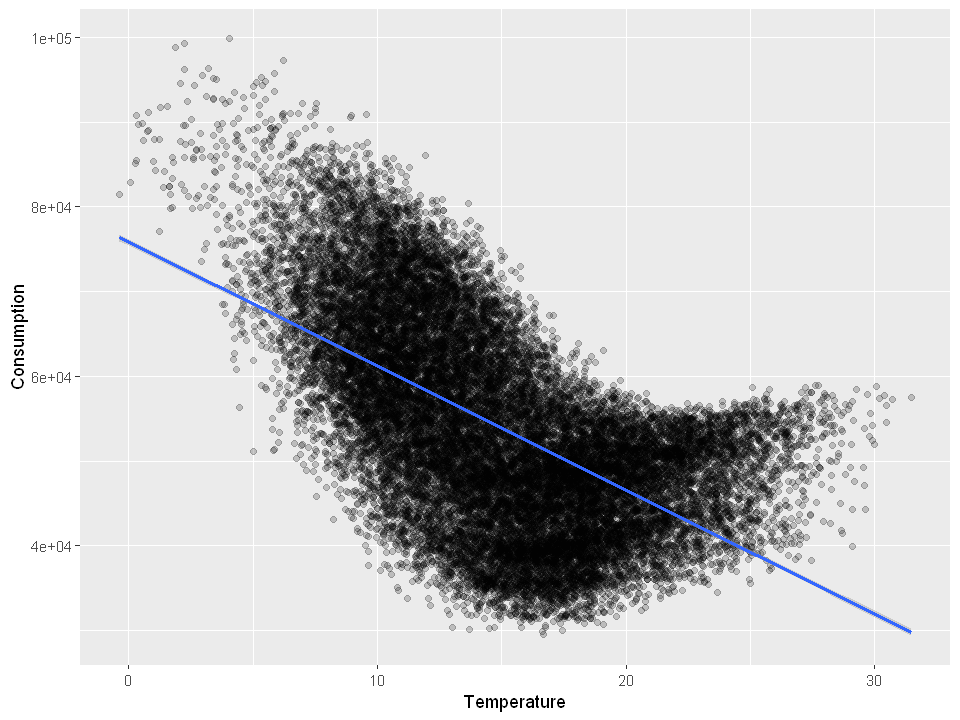

In [35]:
#Corrélogramme Consommation électrique - Température
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data_train_1, aes(x = Temperature, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")

Nous observons une corrélation négative entre la consommation électrique et la température. Ce résultat parait cohérent: plus la température diminue, plus la consommation électrique augmente.

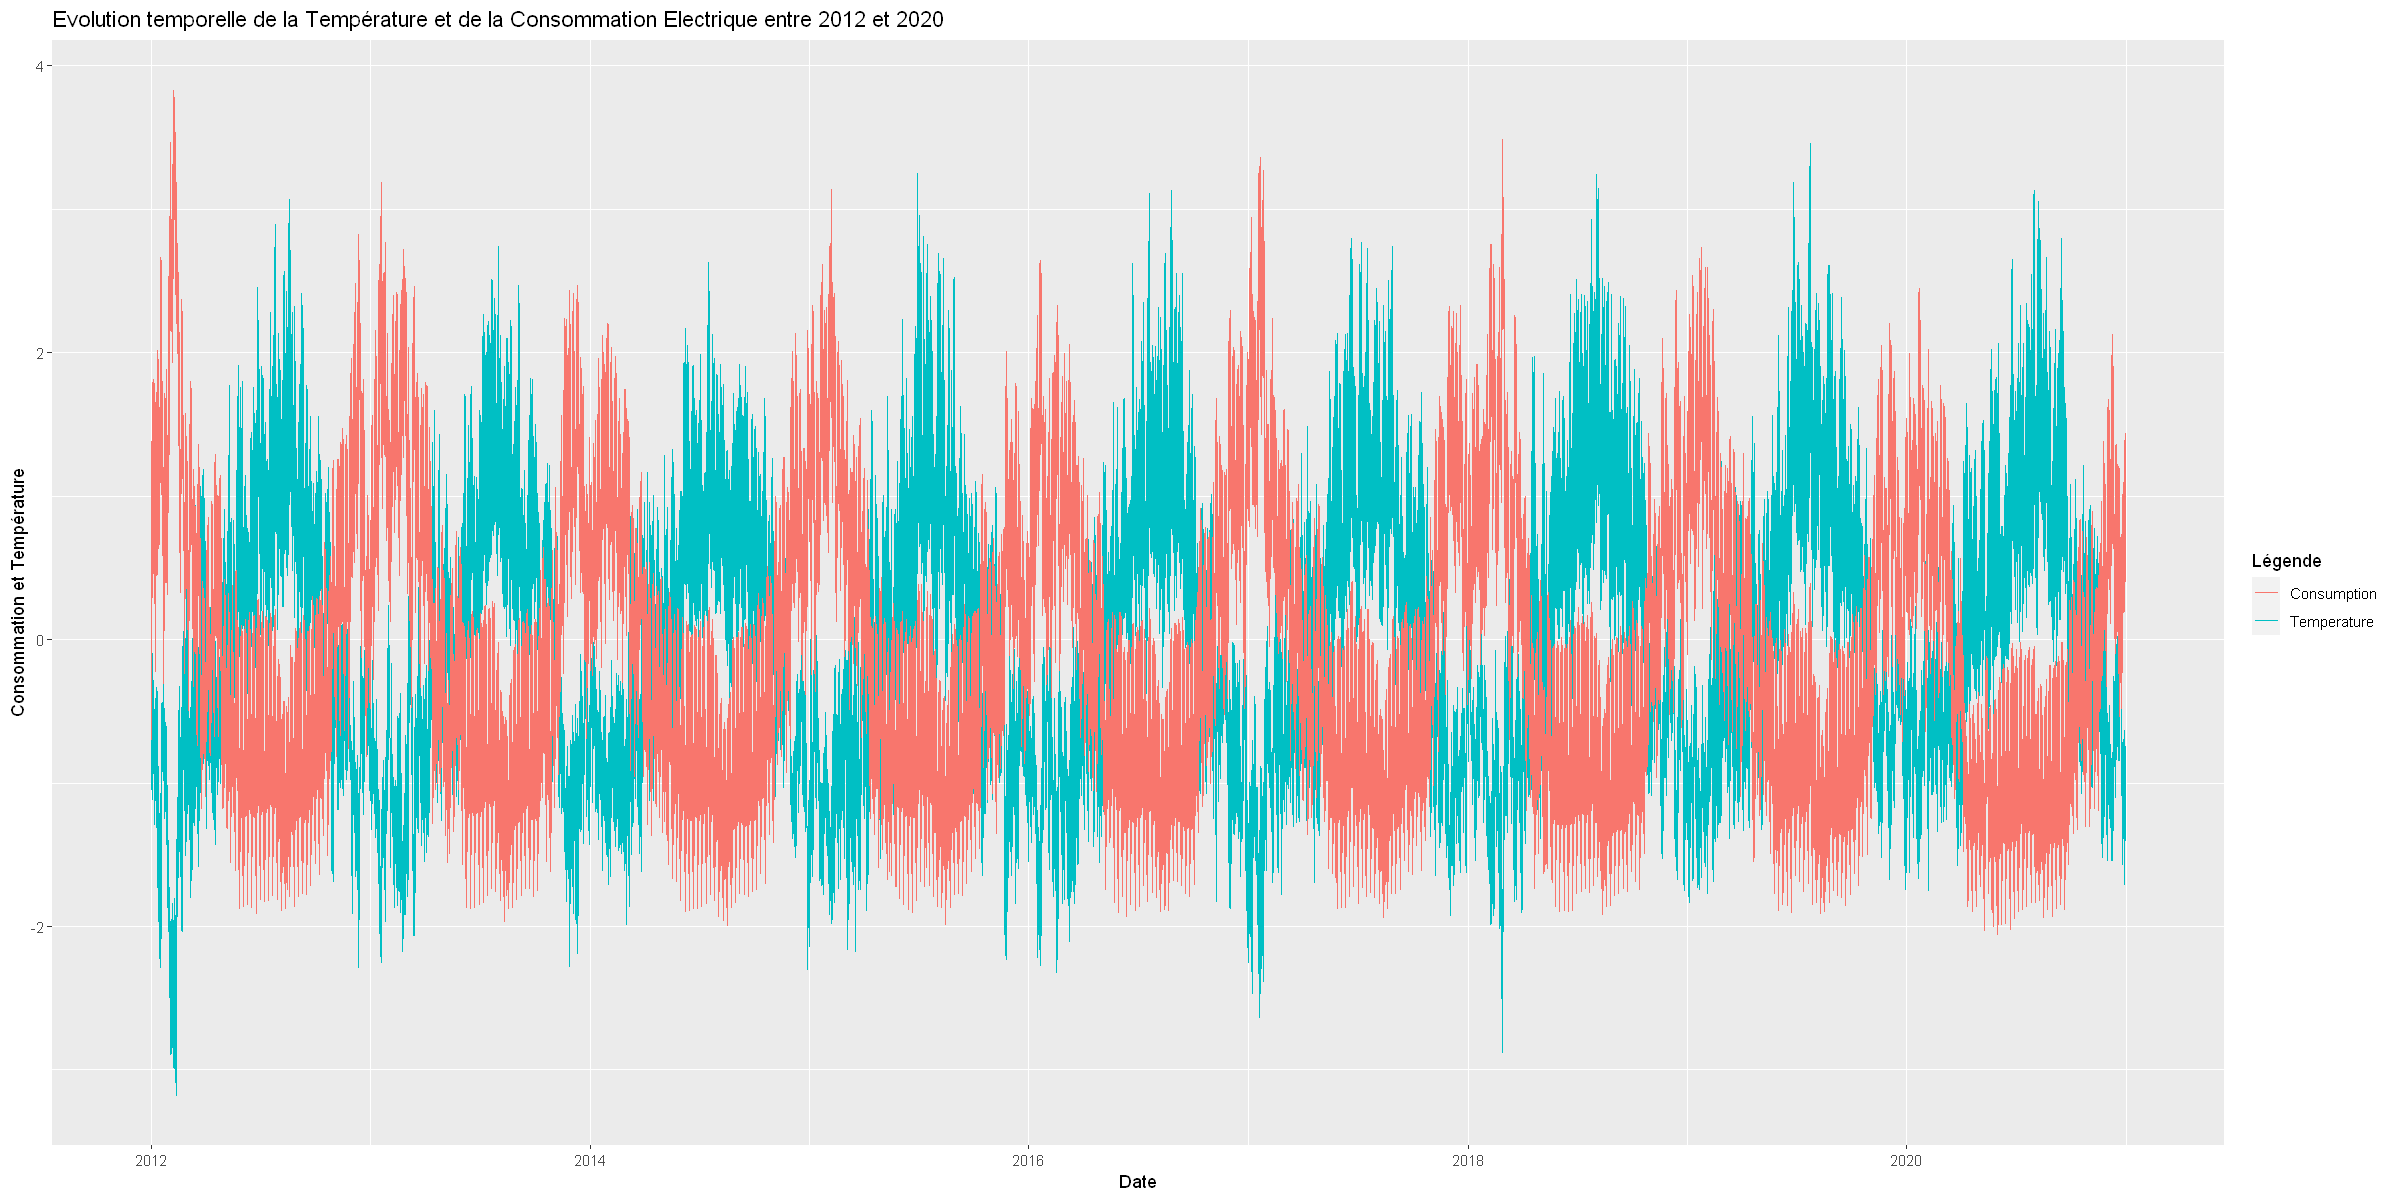

In [38]:
#Etude de l'évolution temporelle Température-Consommation entre 2012 et 2020
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_1, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Température')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle de la Température et de la Consommation Electrique entre 2012 et 2020") +
    ylab("Consommation et Température")

In [39]:
#Pour une meilleure visualiation, nous étudions cette relation sur l'année 2012 uniquement
data_train_2012 <- subset(data_train_1, Year == 2012)

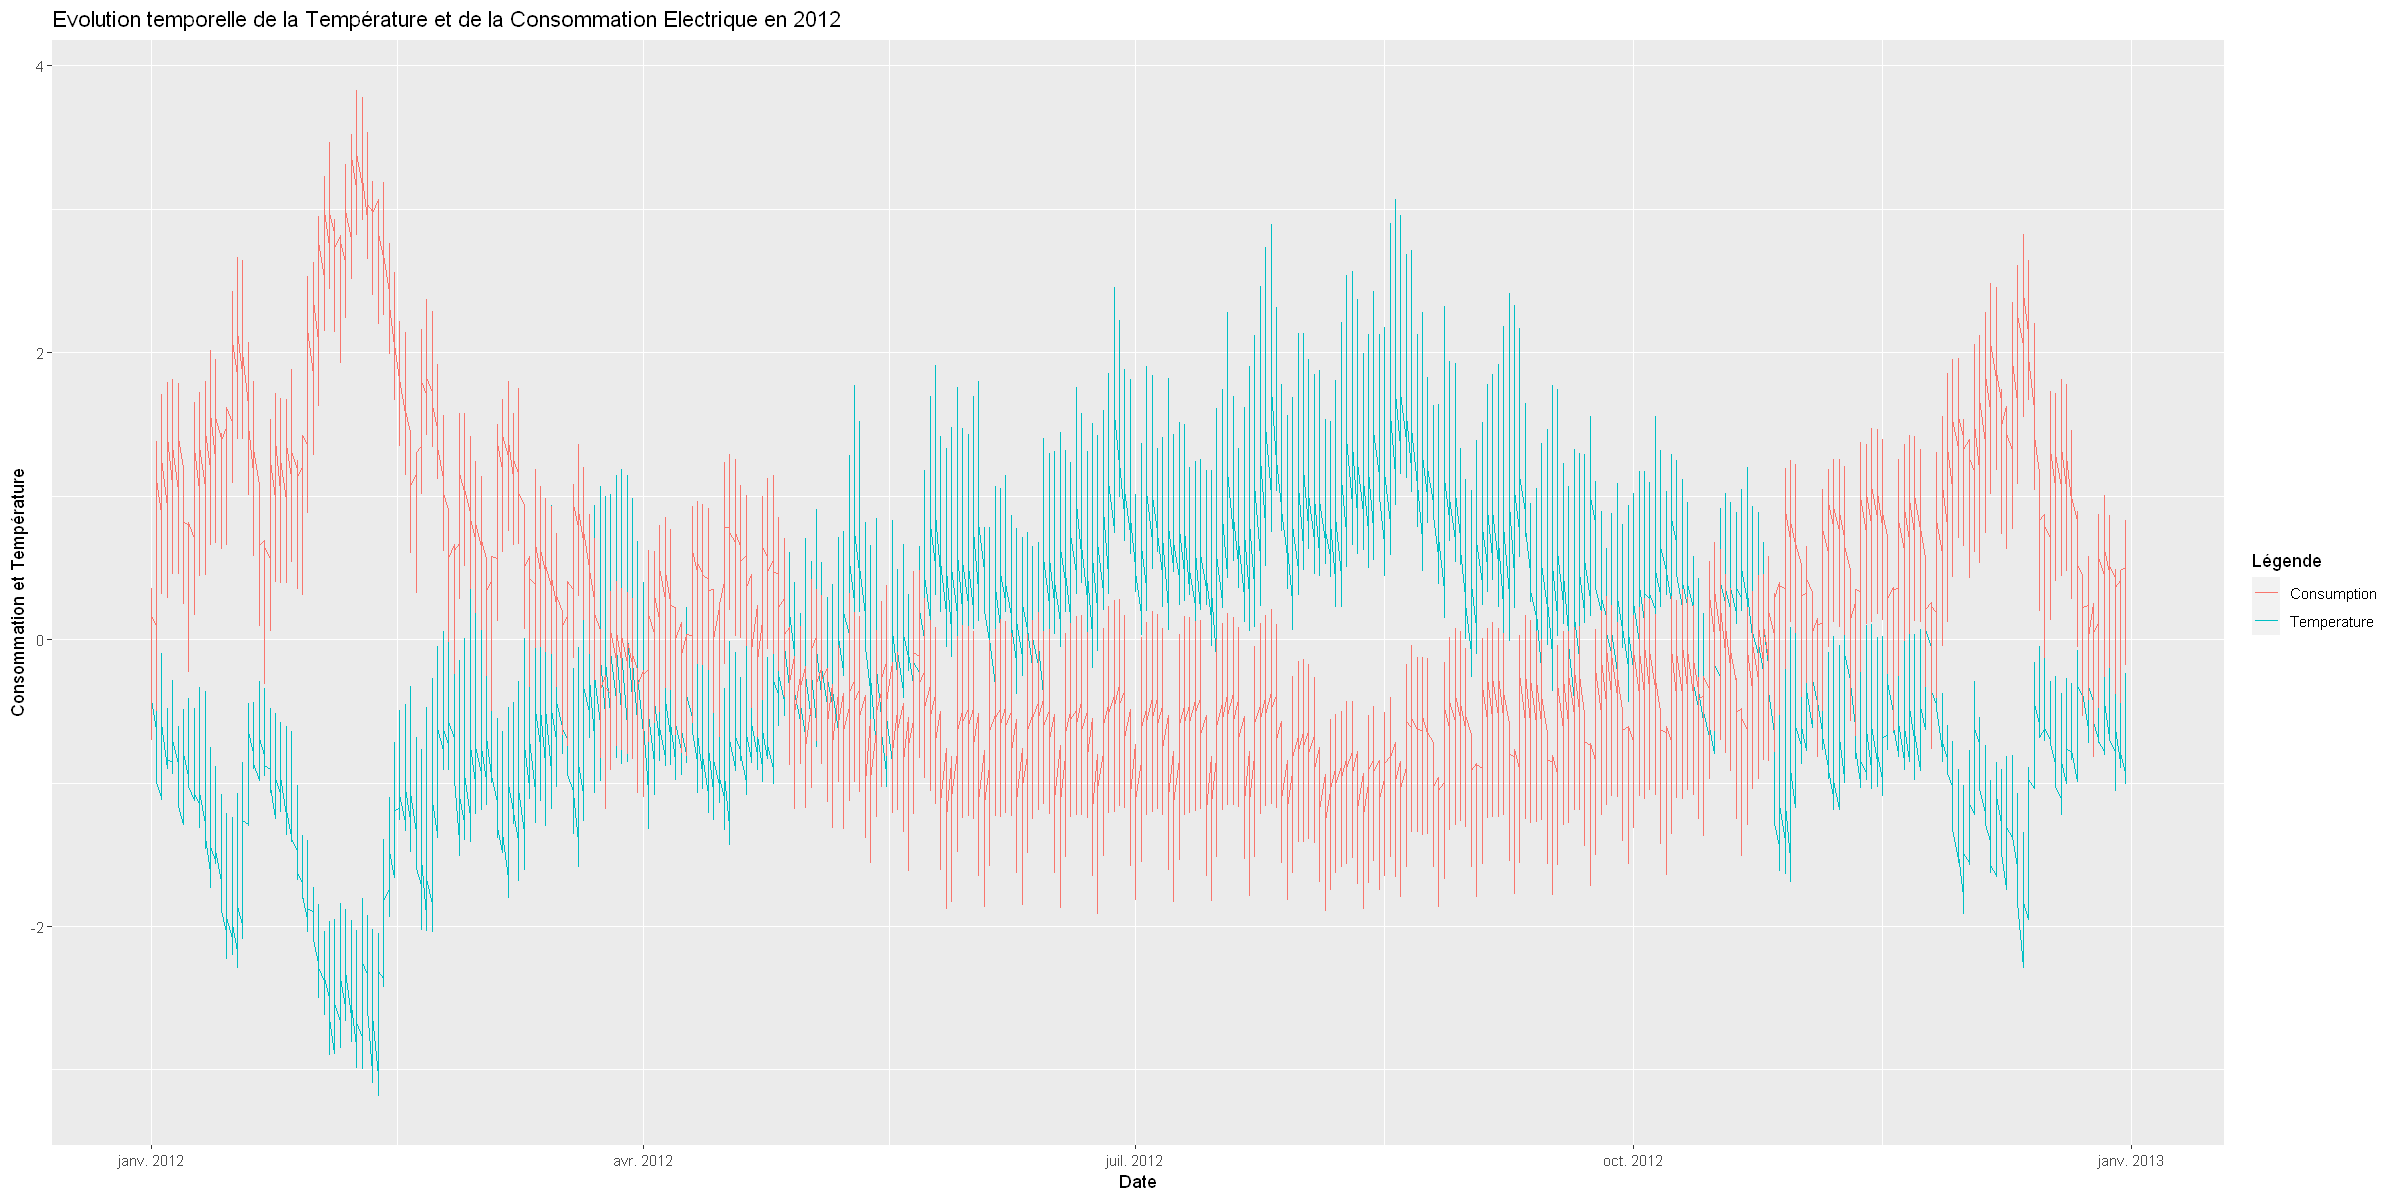

In [43]:
#Etude de l'évolution temporelle Température-Consommation en 2012
ggplot(data_train_2012, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Température')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle de la Température et de la Consommation Electrique en 2012") +
    ylab("Consommation et Température")

Pour une analyse plus précise, nous décidons de construire une base annuelle "type": base annuelle agrégée par mois/jour/horaire de l'année et moyenne des données de consommation électrique et météorologiques sur les 9 années étudiées.

In [42]:
data_train_1_type <- data_train_1 %>%
   group_by(Month, Day, Time) %>% 
   summarise_at(vars("Consumption", "Temperature", "Nebulosity", "Humidity"), mean)

data_train_1_type$Date = paste(data_train_1_type$Month, data_train_1_type$Day, sep="-")
data_train_1_type$Date = as.Date(data_train_1_type$Date, format = "%m-%d")
data_train_1_type <- data_train_1_type %>% select(Date, everything())
data_train_1_type <- data_train_1_type %>% drop_na()

data_train_1_type$Temperature_normalized <- (data_train_1_type$Temperature - mean(data_train_1_type$Temperature)) / sd(data_train_1_type$Temperature)
data_train_1_type$Consumption_normalized <- (data_train_1_type$Consumption - mean(data_train_1_type$Consumption)) / sd(data_train_1_type$Consumption)
data_train_1_type$Nebulosity_normalized <- (data_train_1_type$Nebulosity - mean(data_train_1_type$Nebulosity)) / sd(data_train_1_type$Nebulosity)
data_train_1_type$Humidity_normalized <- (data_train_1_type$Humidity - mean(data_train_1_type$Humidity)) / sd(data_train_1_type$Humidity)

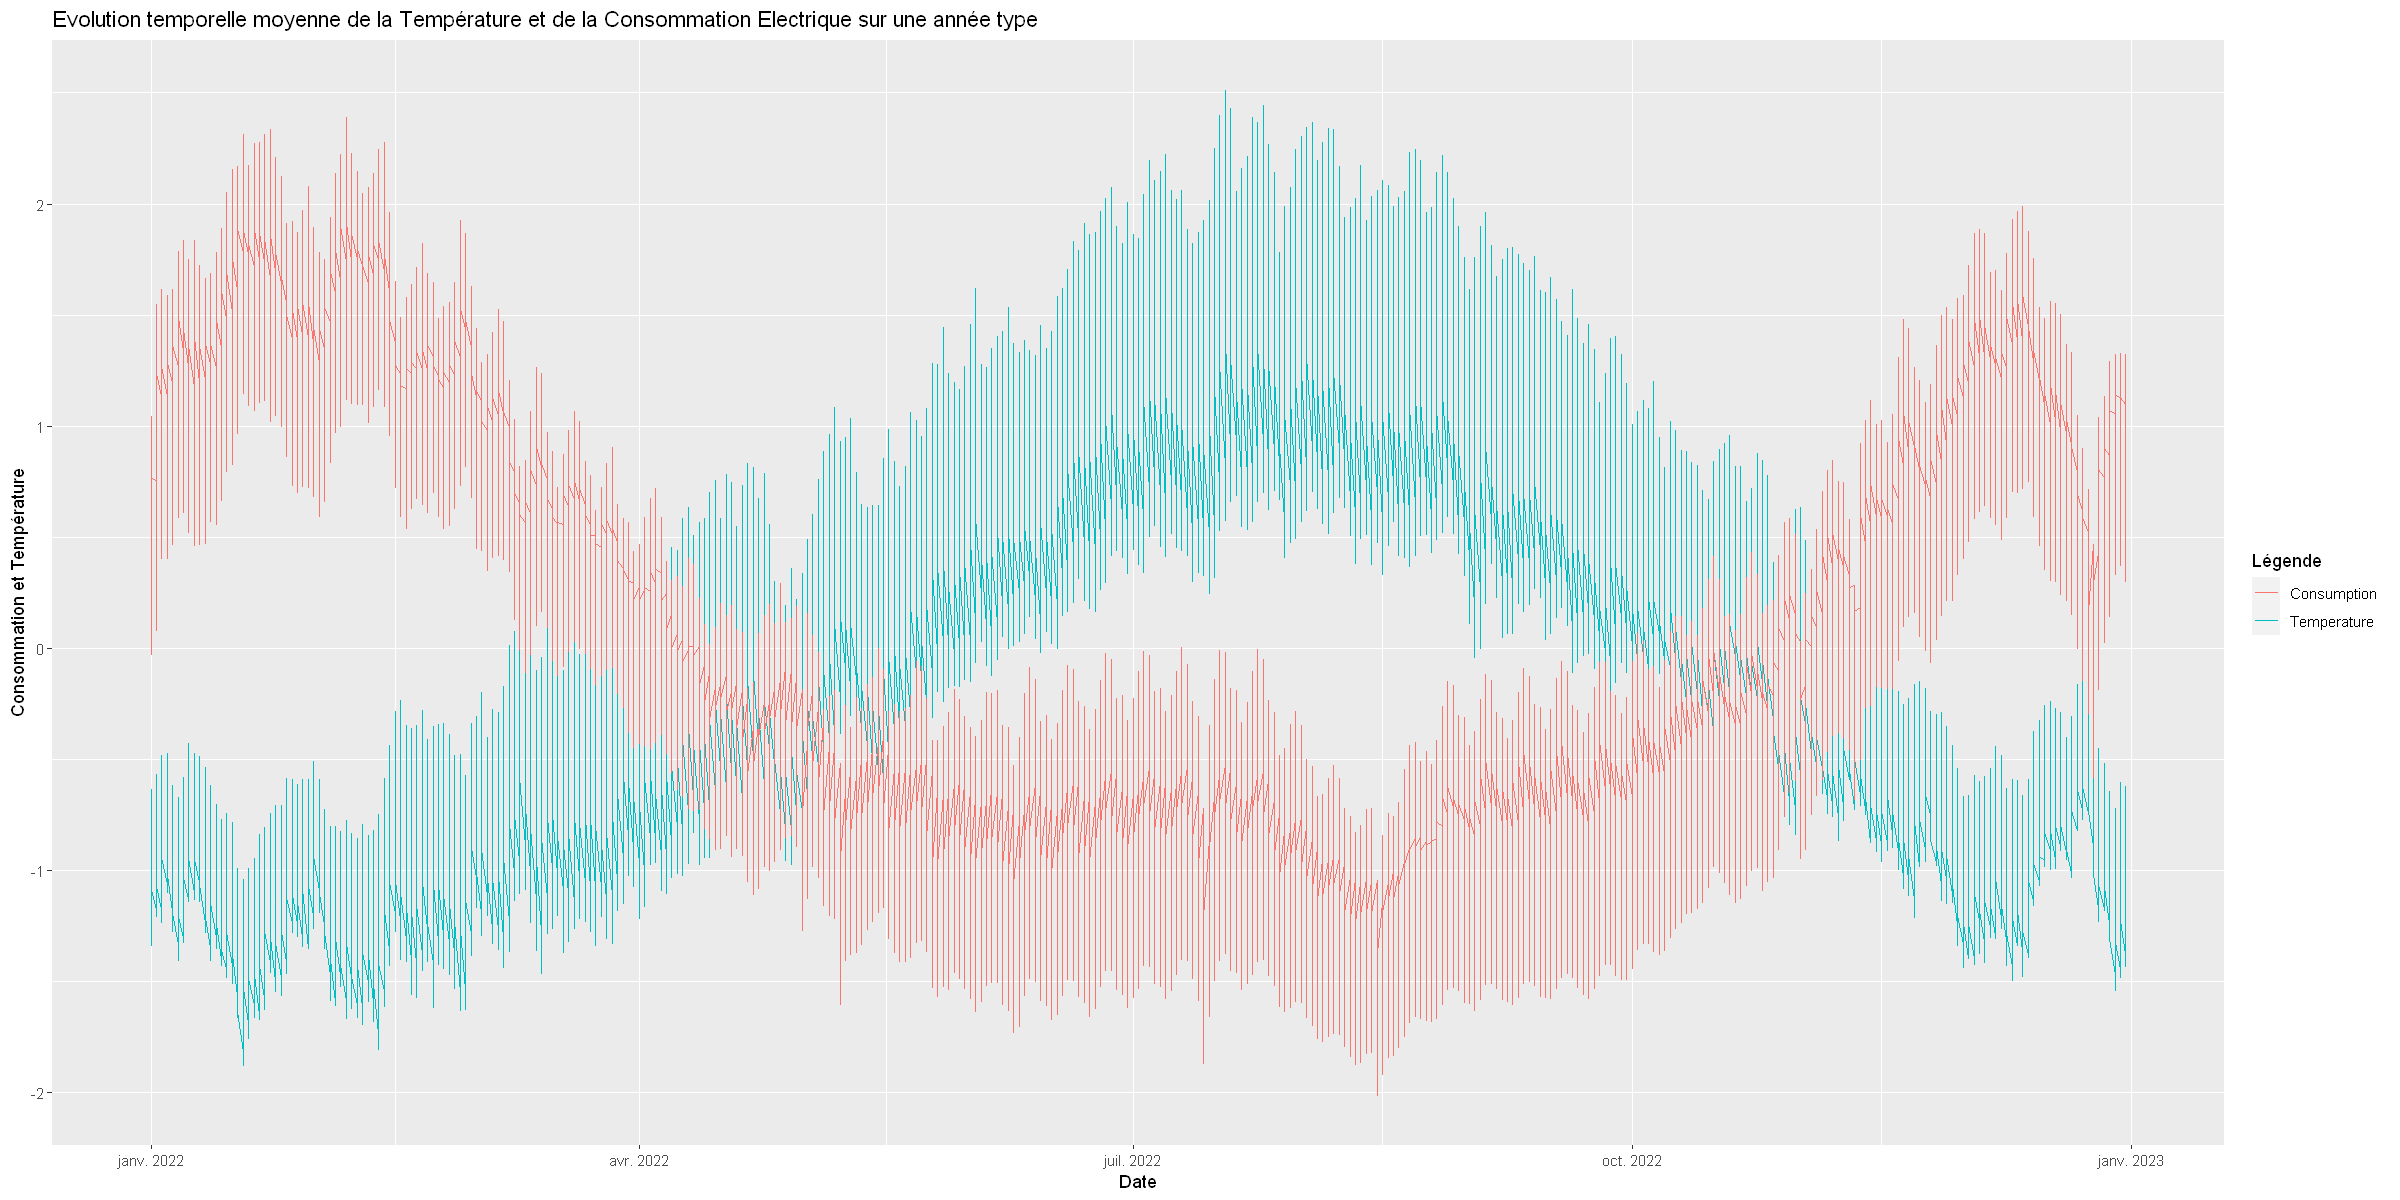

In [44]:
#Etude de l'évolution temporelle Température-Consommation sur une année "type"
ggplot(data_train_1_type, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Température')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Température et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Température")

Pour obtenir une représentation visuelle plus aérée, nous agrégeons par jour de l'année.

In [45]:
data_train_1_type_notime <- data_train_1_type %>%
   group_by(Date) %>% 
   summarise_at(vars("Consumption", "Temperature", "Nebulosity", "Humidity"), mean)

data_train_1_type_notime$Temperature_normalized <- (data_train_1_type_notime$Temperature - mean(data_train_1_type_notime$Temperature)) / sd(data_train_1_type_notime$Temperature)
data_train_1_type_notime$Consumption_normalized <- (data_train_1_type_notime$Consumption - mean(data_train_1_type_notime$Consumption)) / sd(data_train_1_type_notime$Consumption)
data_train_1_type_notime$Nebulosity_normalized <- (data_train_1_type_notime$Nebulosity - mean(data_train_1_type_notime$Nebulosity)) / sd(data_train_1_type_notime$Nebulosity)
data_train_1_type_notime$Humidity_normalized <- (data_train_1_type_notime$Humidity - mean(data_train_1_type_notime$Humidity)) / sd(data_train_1_type_notime$Humidity)

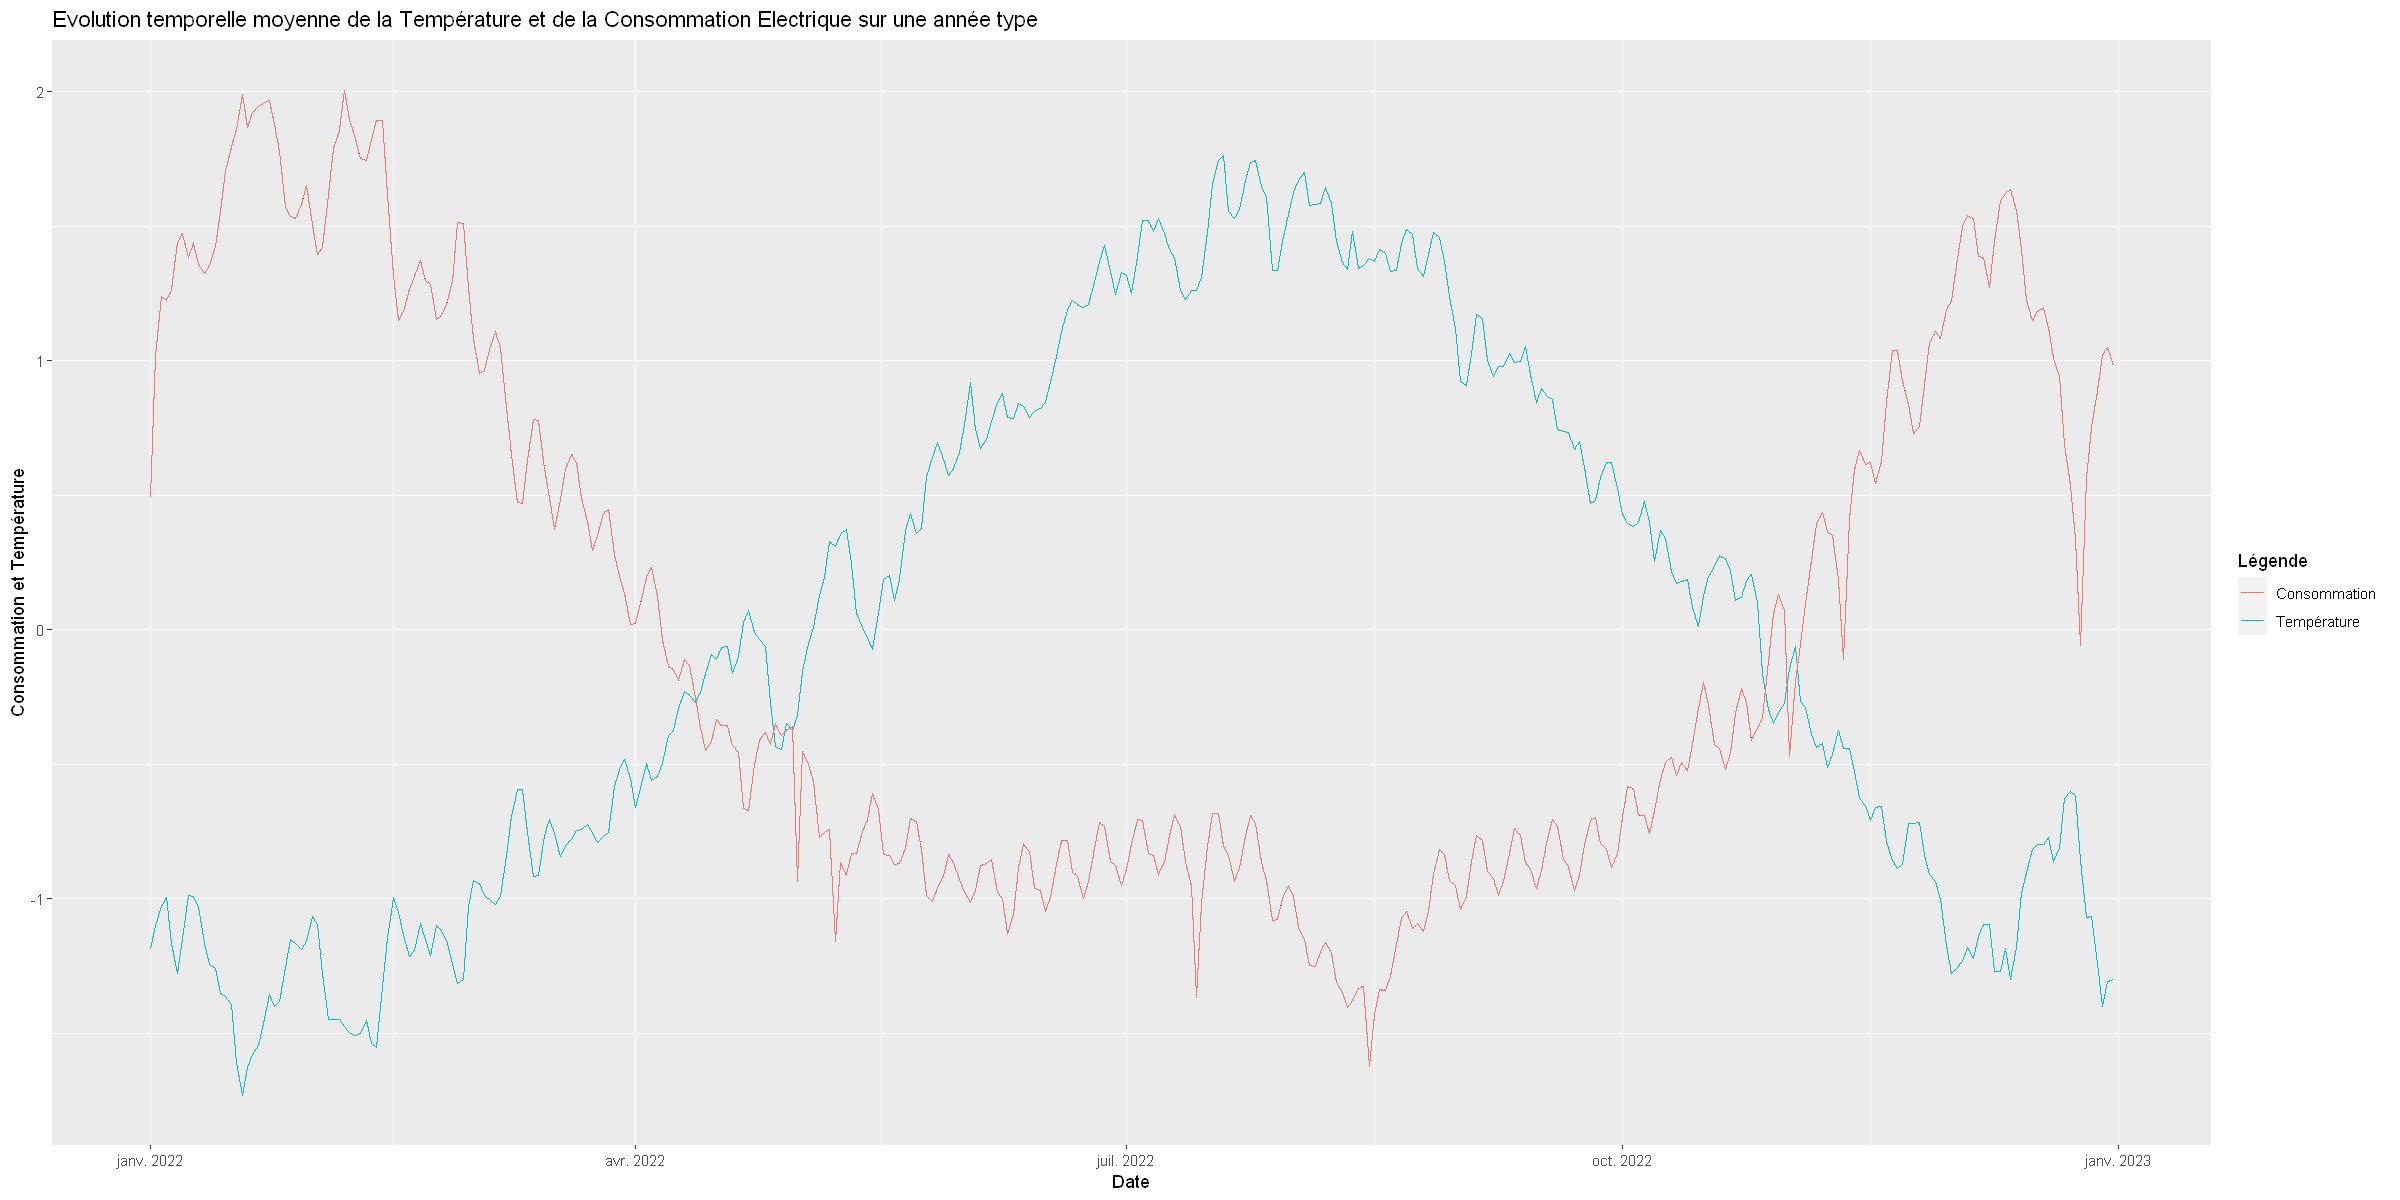

In [46]:
#Etude de l'évolution temporelle Température-Consommation électrique, avec données agrégées par jour
ggplot(data_train_1_type_notime, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Température')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Température et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Température")

Nous constatons clairement à travers notre corrélogramme et nos différents graphiques, que la corrélation entre la température et la consommation électrique est négative. Ces deux variables ont une évolution temporelle antagoniste sur l'année.

##### Etude de la Température lissée

`geom_smooth()` using formula 'y ~ x'



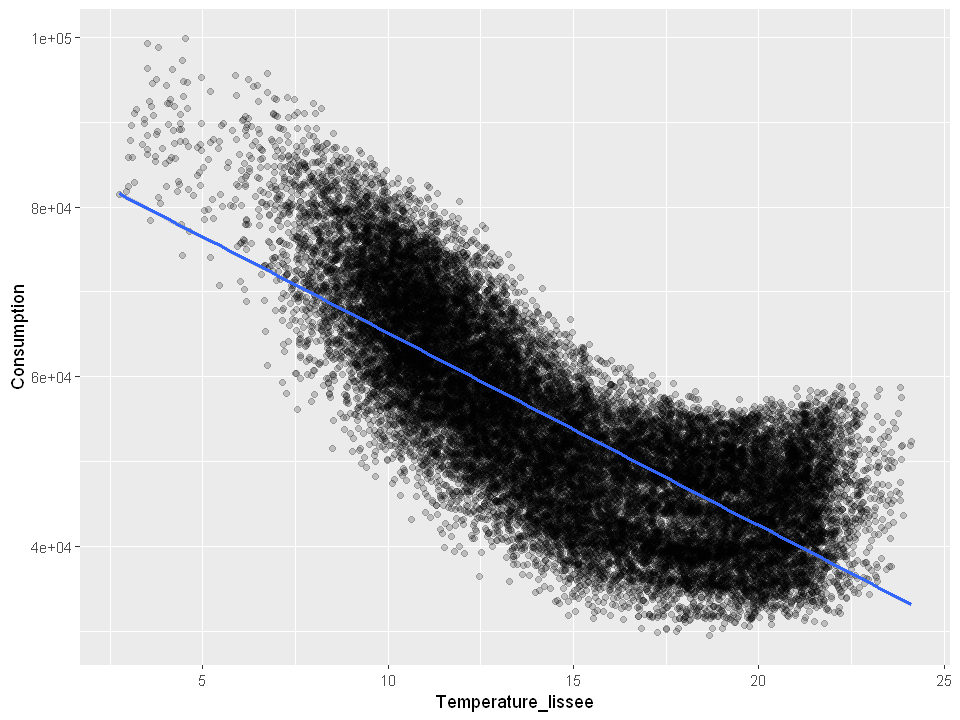

In [113]:
#Correlogramme Température lissée - Consommation électrique
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data_train_1, aes(x = Temperature_lissee, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")

Comme pour la température, nous constatons une corrélation négative entre la température lissée et la consommation électrique, ce qui parait cohérent.

##### Etude de la Température retardée

`geom_smooth()` using formula 'y ~ x'



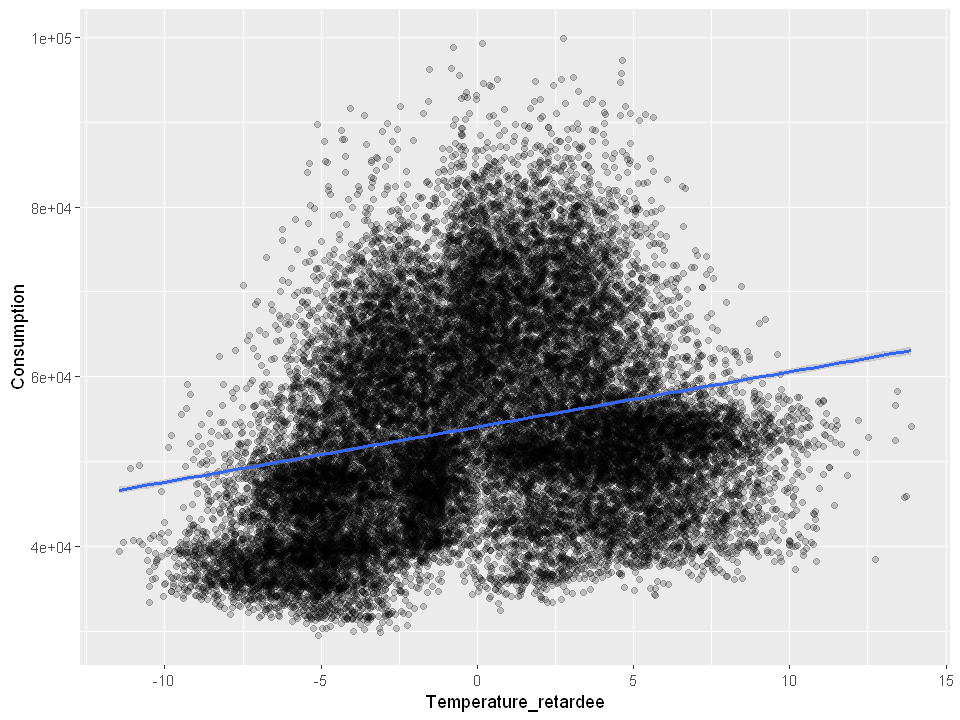

In [114]:
ggplot(data_train_1, aes(x = Temperature_retardee, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")

Nous constatons étrangement une faible corrélation positive. Mais le nuage de points important pourrait montrer que cette corrélation est peu significative. Nous ne retiendrons pas cette variable.

##### Etude de la Nébulosité 

`geom_smooth()` using formula 'y ~ x'



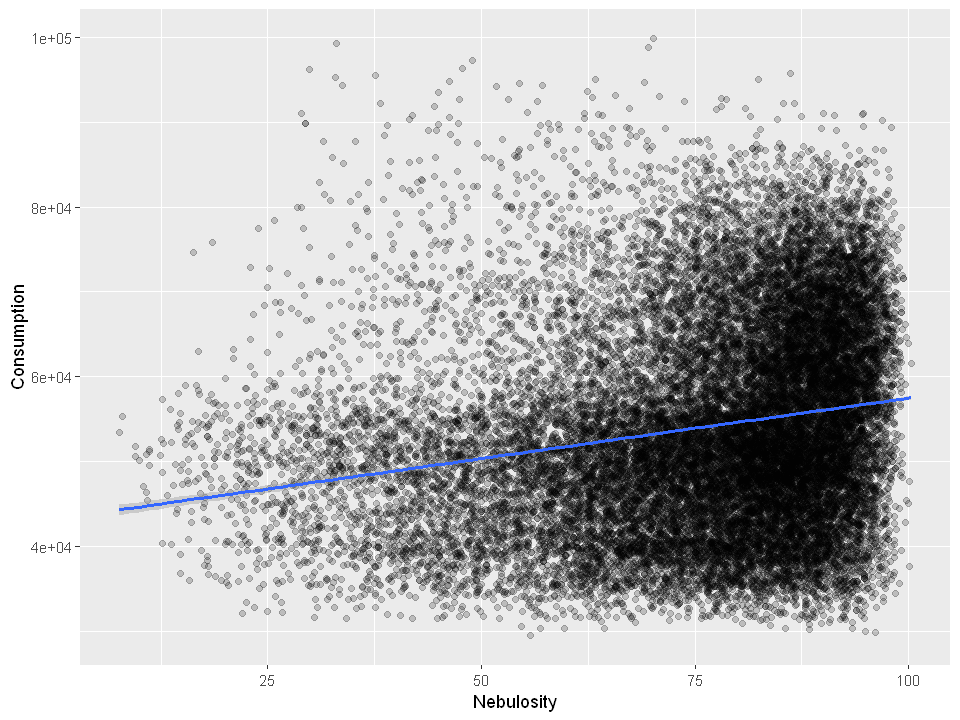

In [47]:
#Corrélogramme Nebulosité - Consommation électrique
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data_train_1, aes(x = Nebulosity, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")

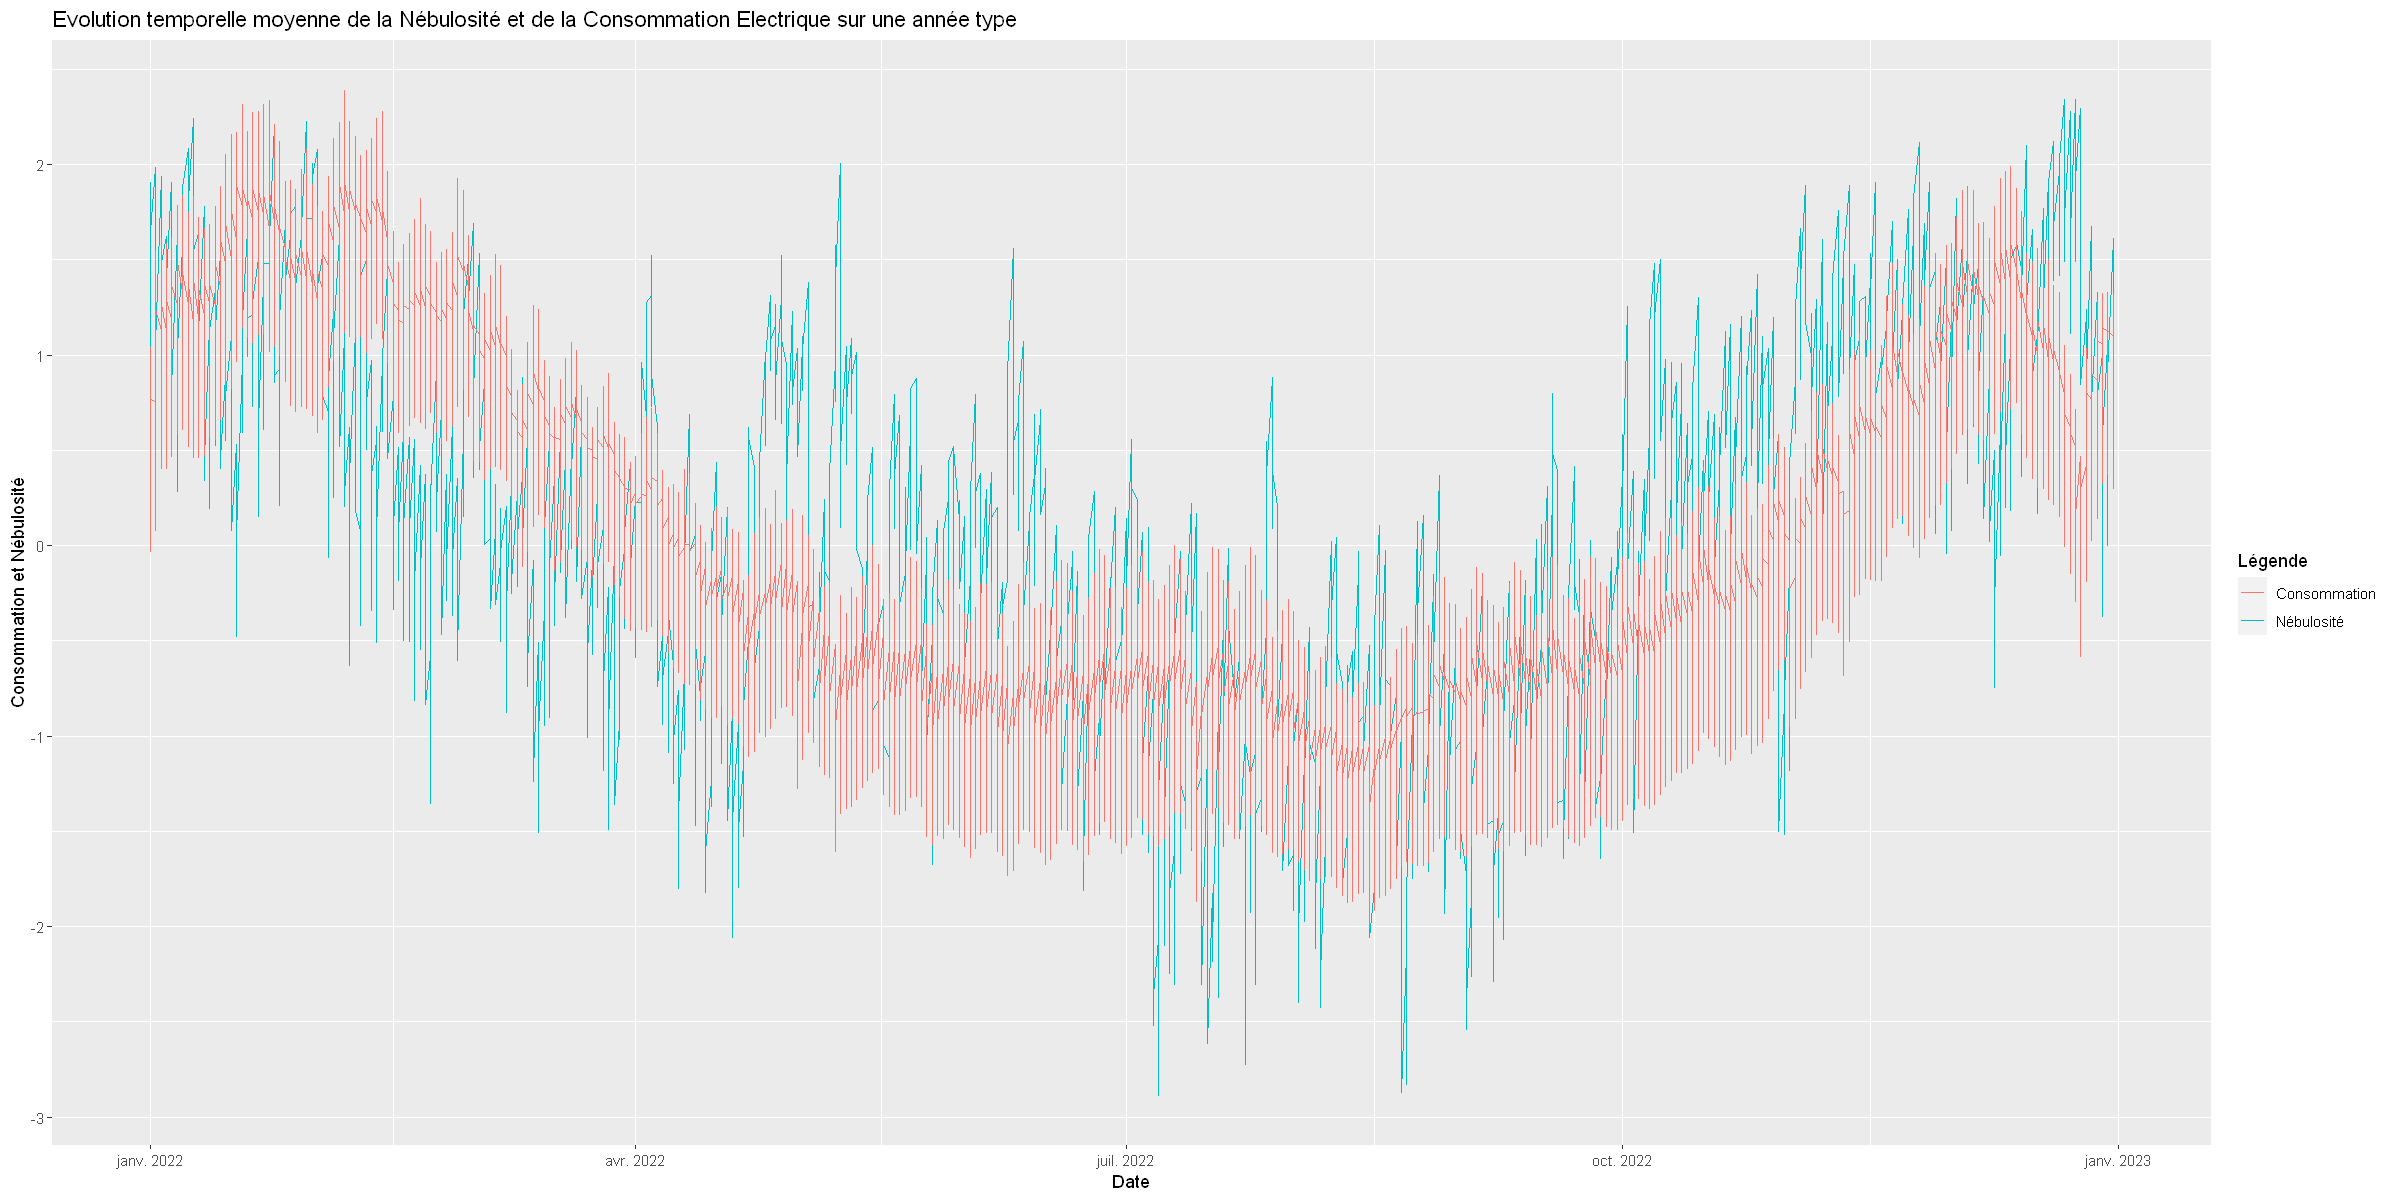

In [48]:
#Etude de l'évolution temporelle Nébulosité - Consommation sur une année "type"
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_1_type, aes(x=Date, y=Nebulosity_normalized, group = 1, color = 'Nébulosité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Nébulosité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Nébulosité")

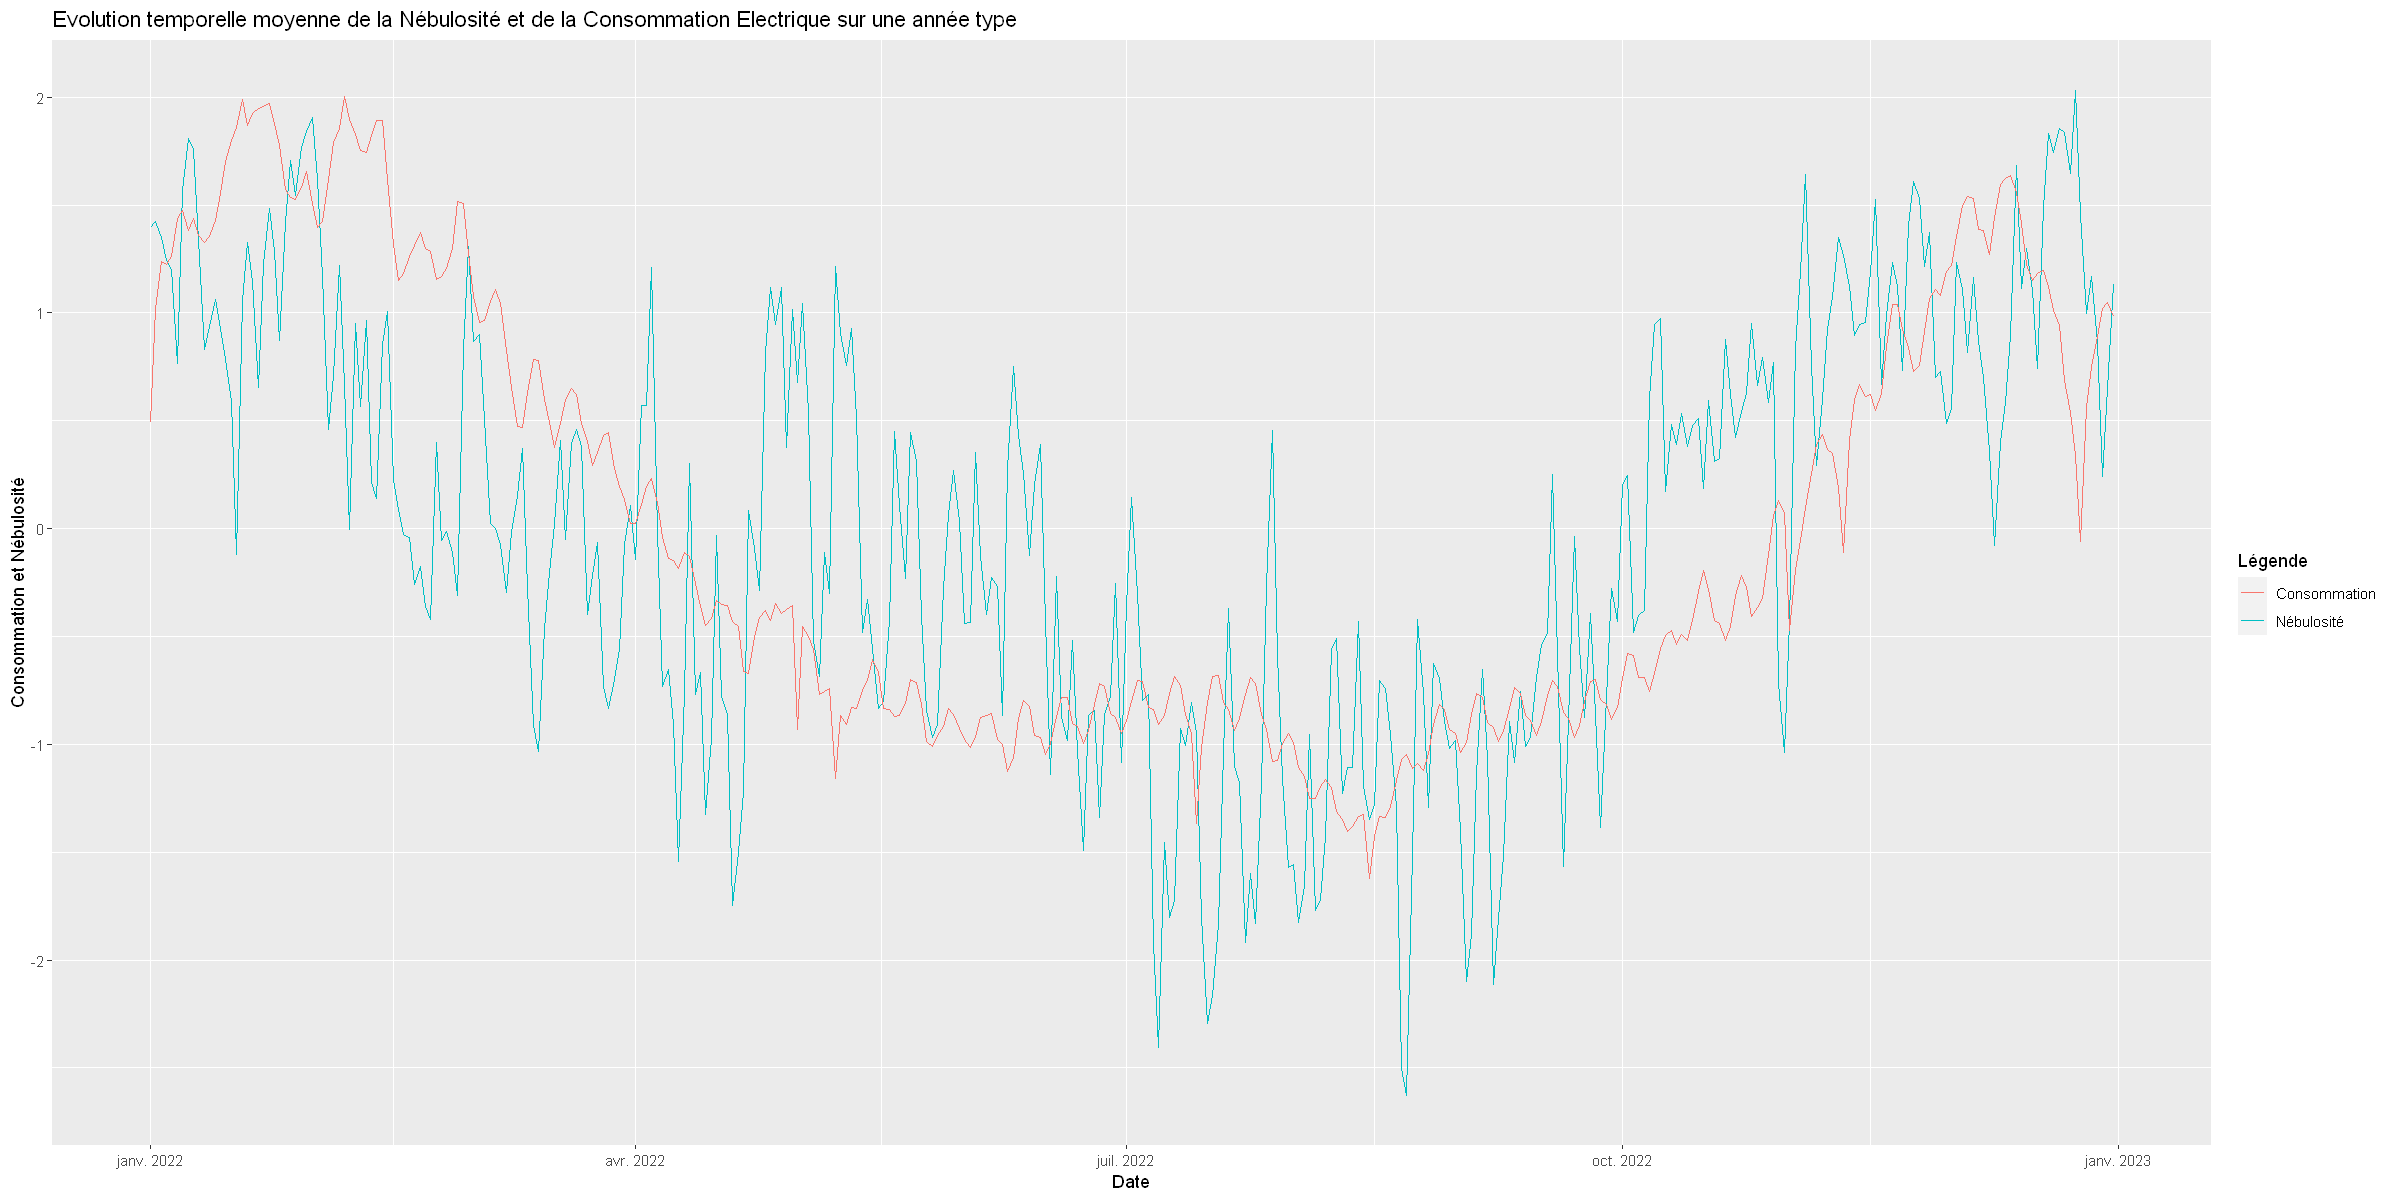

In [49]:
#Etude de l'évolution temporelle Nébulosité - Consommation, avec données agrégées par jour
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_1_type_notime, aes(x=Date, y=Nebulosity_normalized, group = 1, color = 'Nébulosité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Nébulosité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Nébulosité")

Nous constatons que la nébulosité et la consommation électrique ont une corrélation positive et partagent une même trajectoire temporelle.

##### Etude de l'Humidité

`geom_smooth()` using formula 'y ~ x'



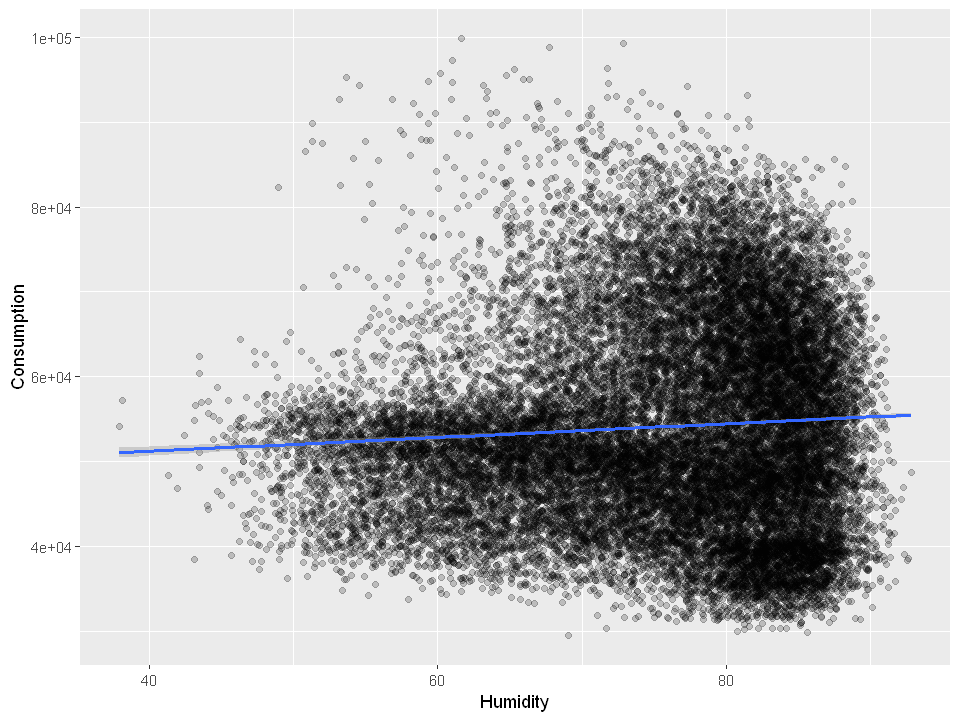

In [50]:
#Corrélogramme Humidité - Consommation électrique
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data_train_1, aes(x = Humidity, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")

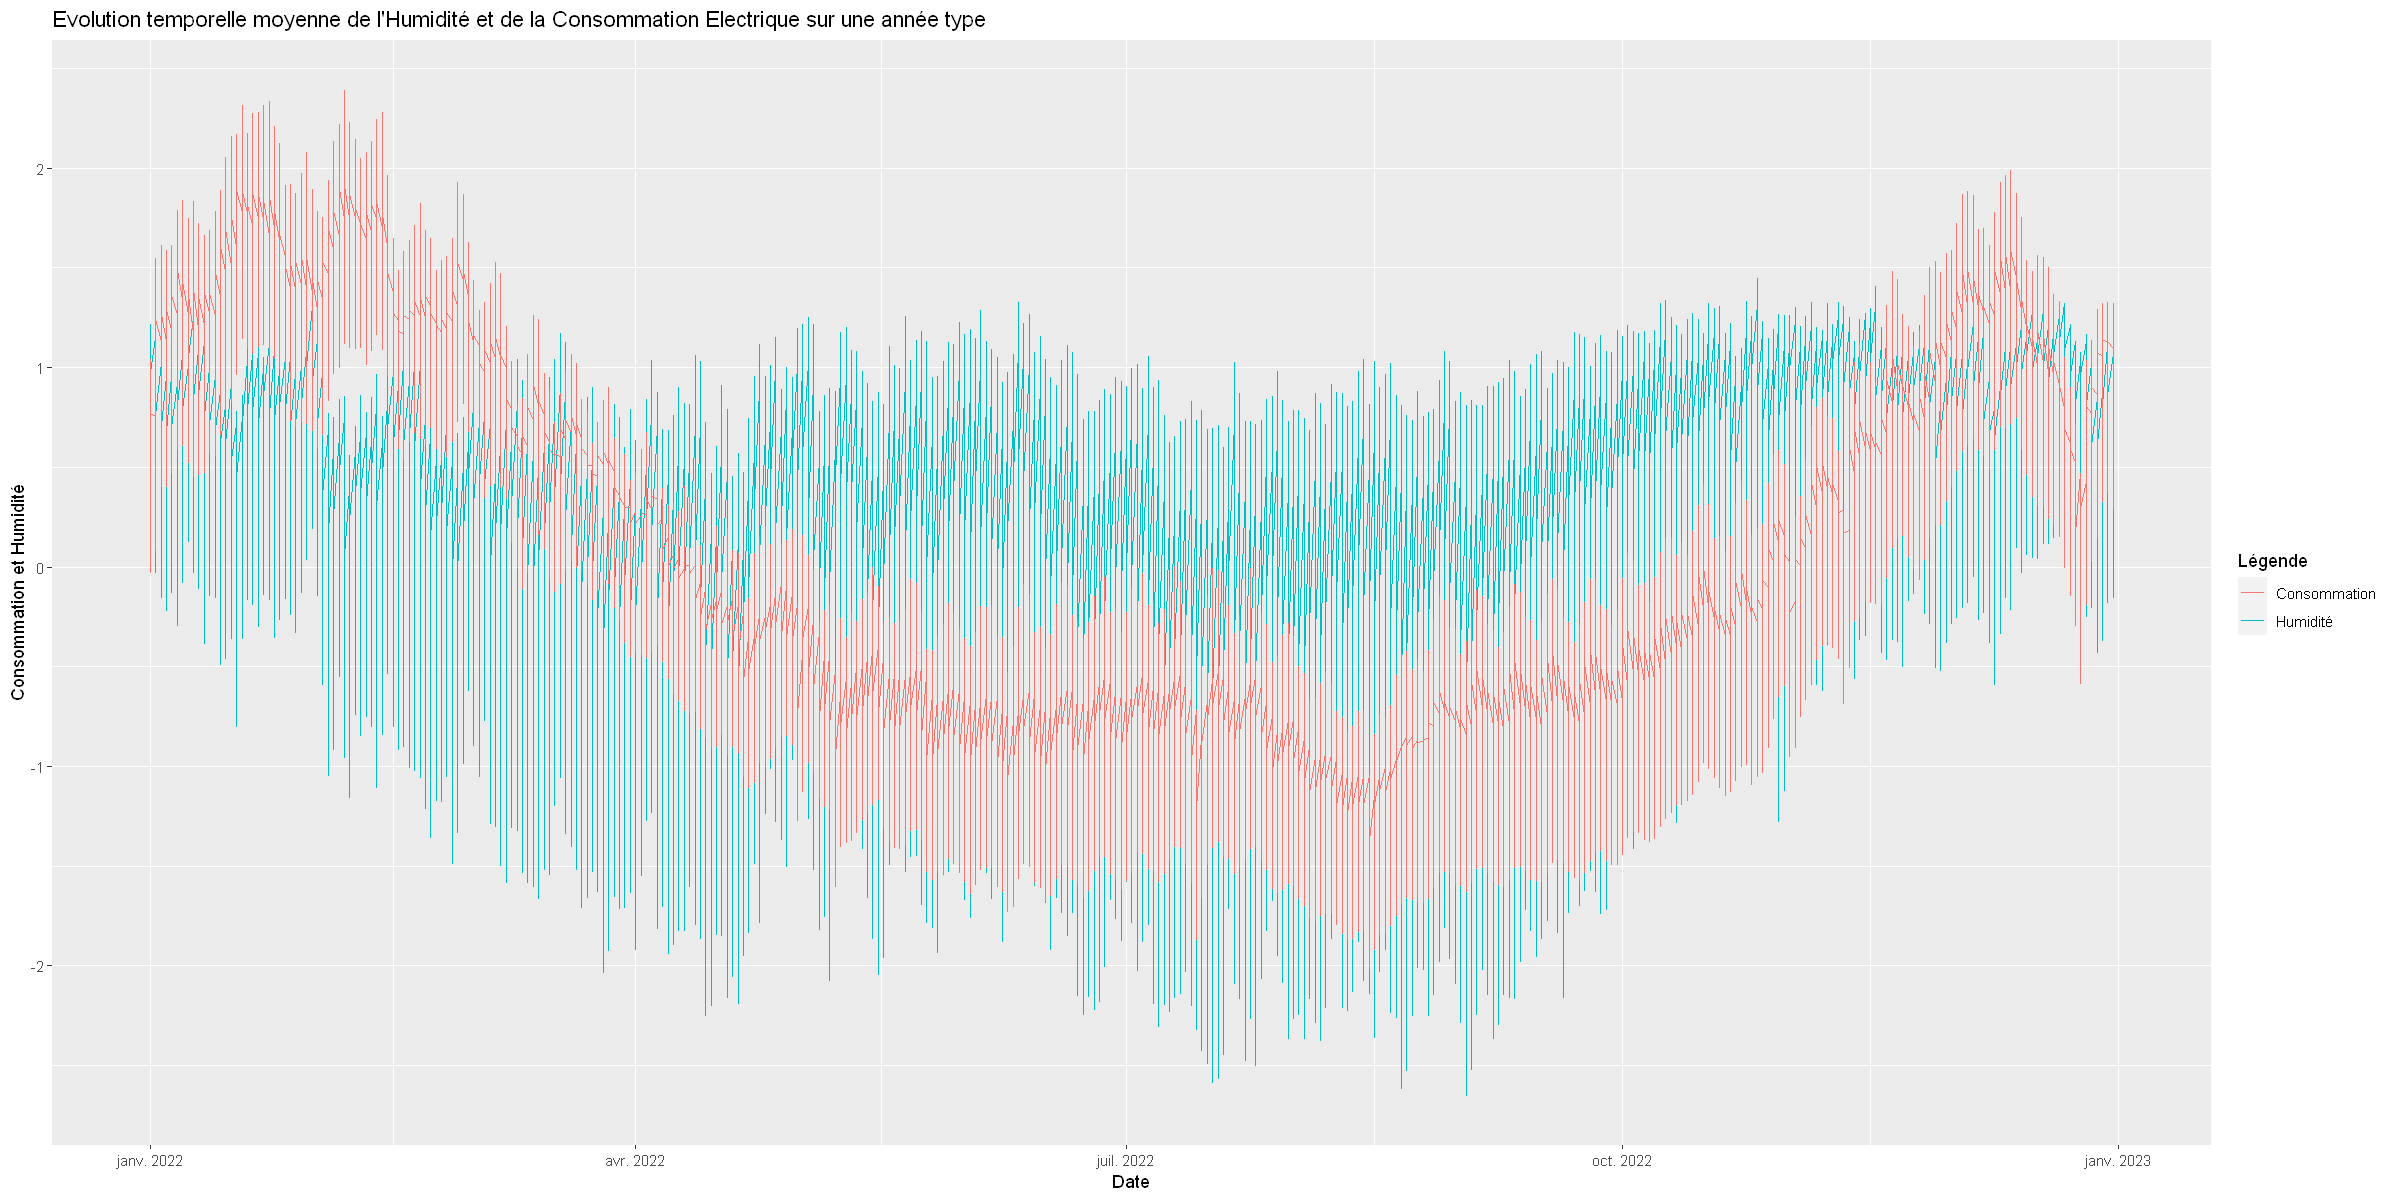

In [51]:
#Etude de l'évolution temporelle Humidité - Consommation sur une année "type"
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_1_type, aes(x=Date, y=Humidity_normalized, group = 1, color = 'Humidité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de l'Humidité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Humidité")

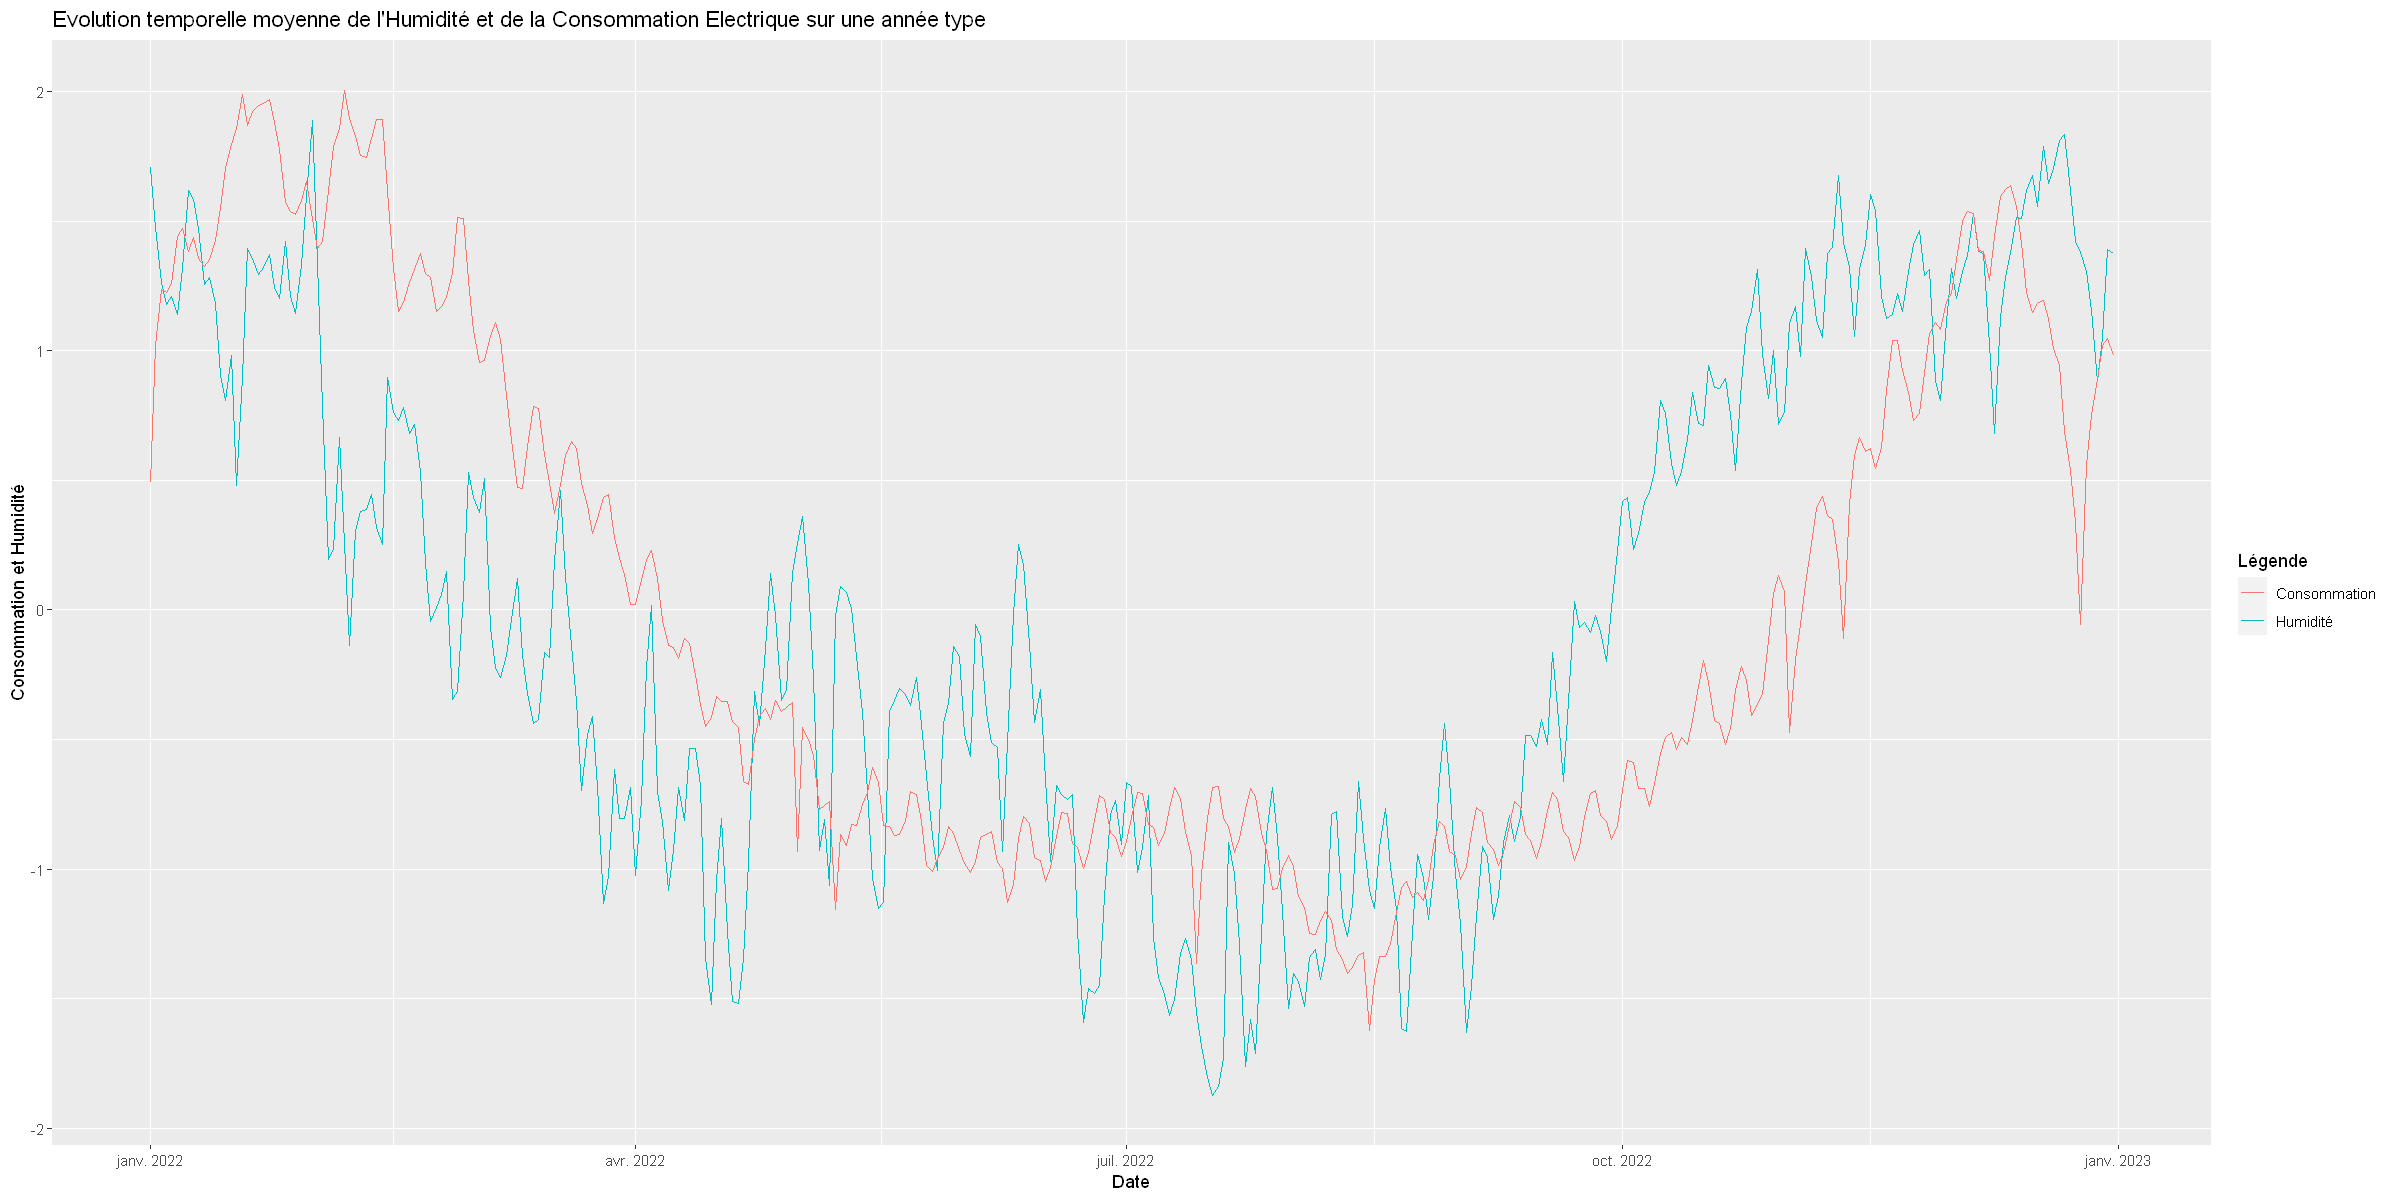

In [52]:
#Etude de l'évolution temporelle Nébulosité - Consommation, avec données agrégées par jour
ggplot(data_train_1_type_notime, aes(x=Date, y=Humidity_normalized, group = 1, color = 'Humidité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de l'Humidité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Humidité")

Les graphiques montrent que l'humidité suit la même trajectoire temporelle que la consommation électrique. Le corrélogramme souligne en effet une corrélation positive, mais moindre qu'avec la nébulosité.

##### Etude de la saisonnalité annuelle

A partir de maintenant, nous utiliserons la base données data_train_0 pour notre analyse des données temporelles. \
De même que précédemment, nous agrégeons cette base par jour pour avoir une représentation graphique plus aérée.

In [53]:
data_train_0_notime <- data_train_0 %>%
   group_by(Date) %>% 
   summarise_at(vars("Consumption"), mean)

data_train_0_notime = data_train_0_notime %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

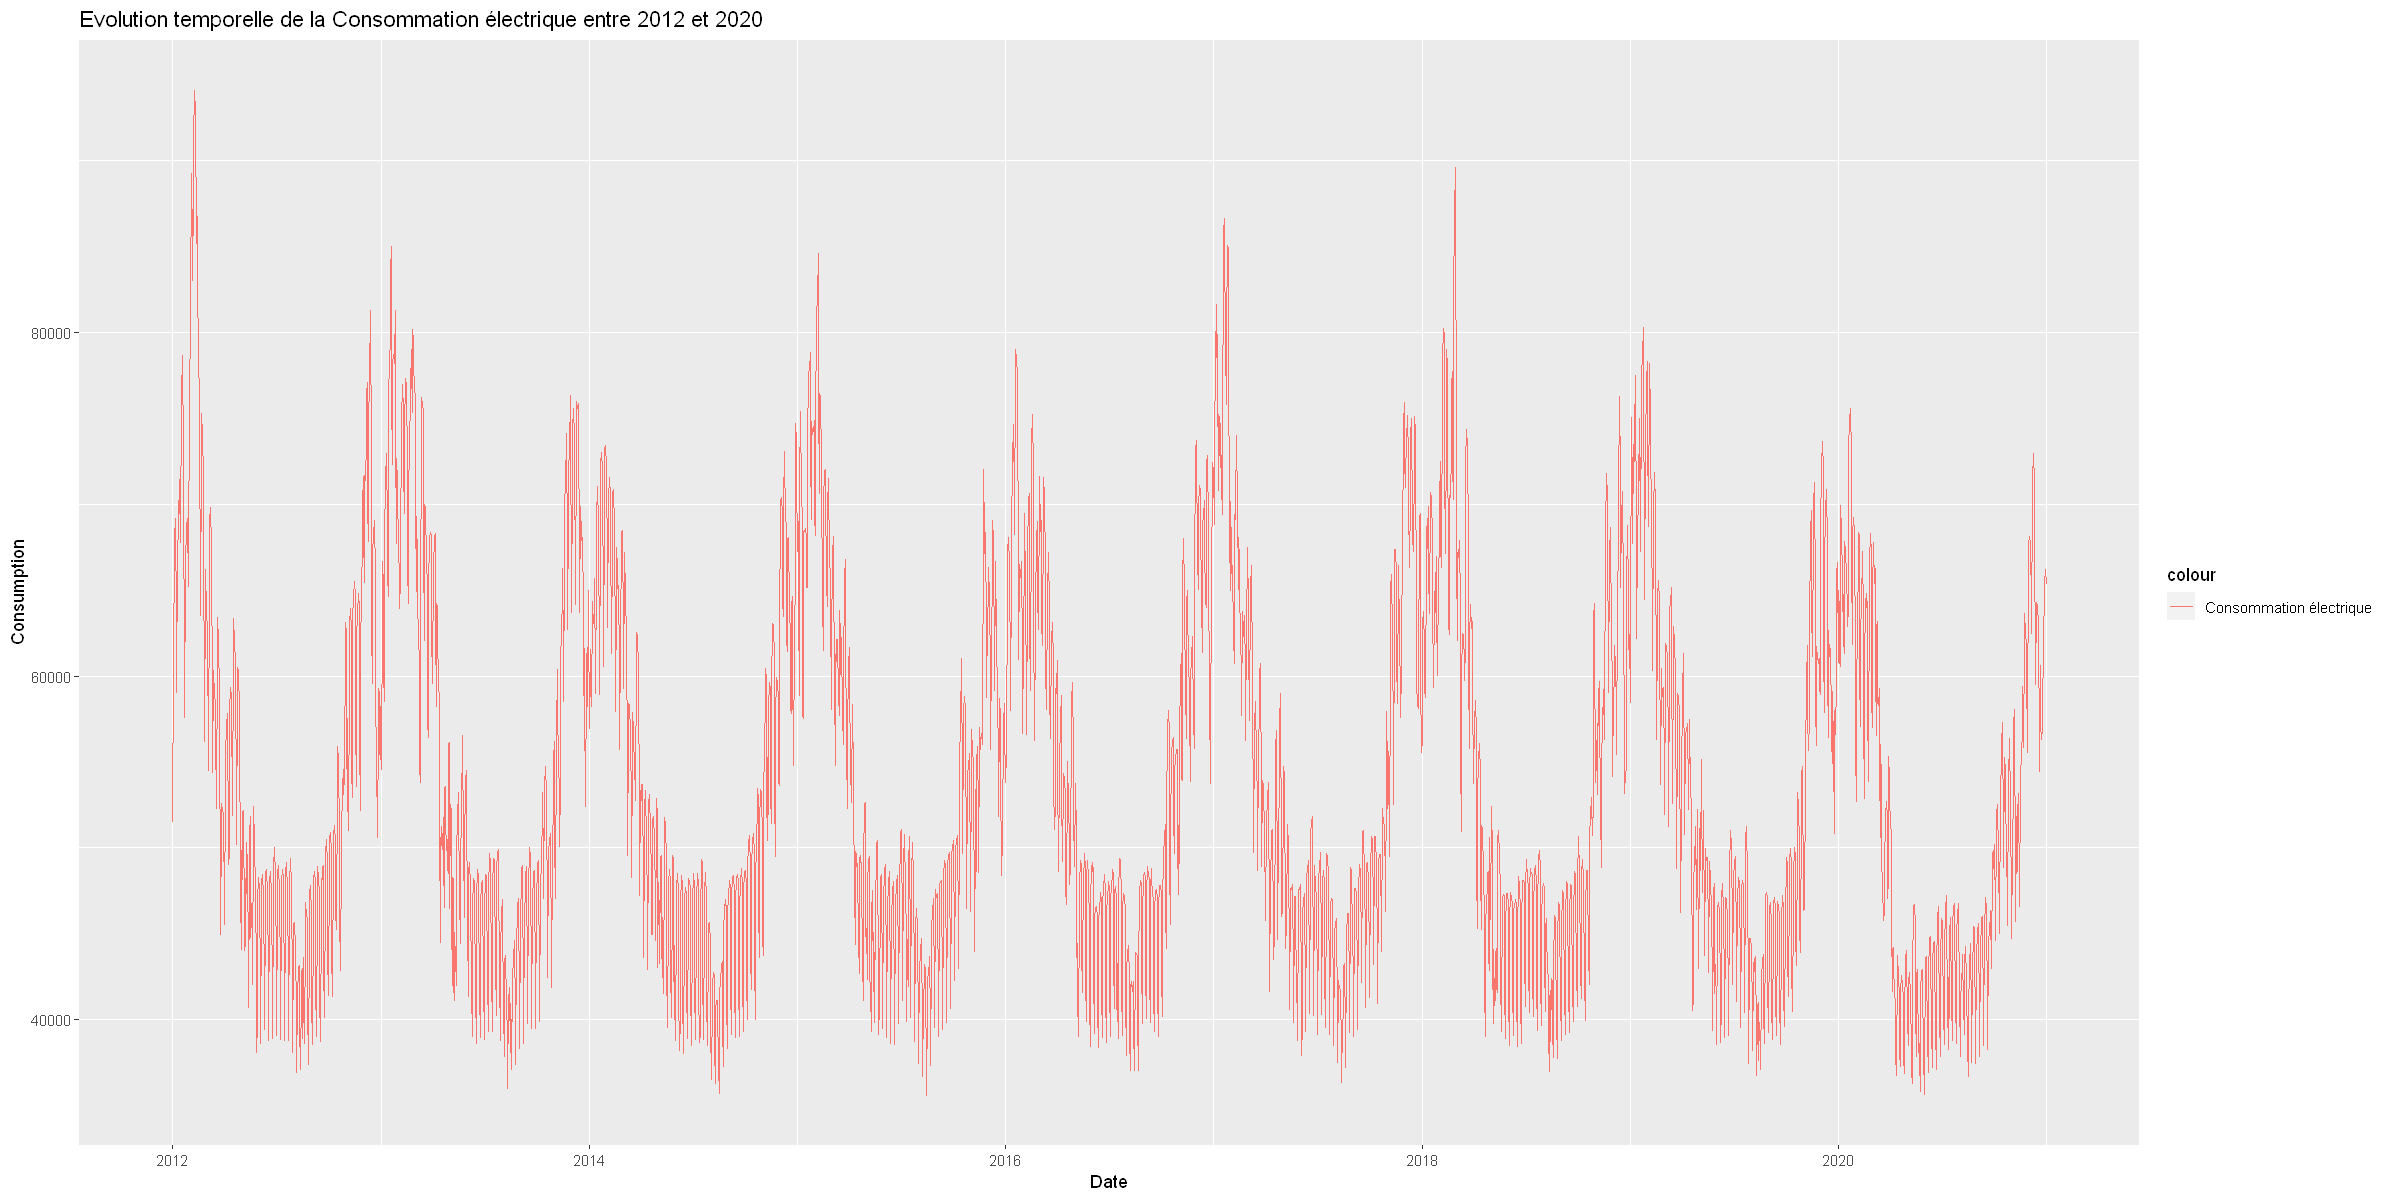

In [54]:
#Représentation graphique de la consommation électrique par jour entre 2012 et 2020
ggplot(data_train_0_notime, aes(Date, Consumption, colour="Consommation électrique")) + geom_line() + ggtitle("Evolution temporelle de la Consommation électrique entre 2012 et 2020")

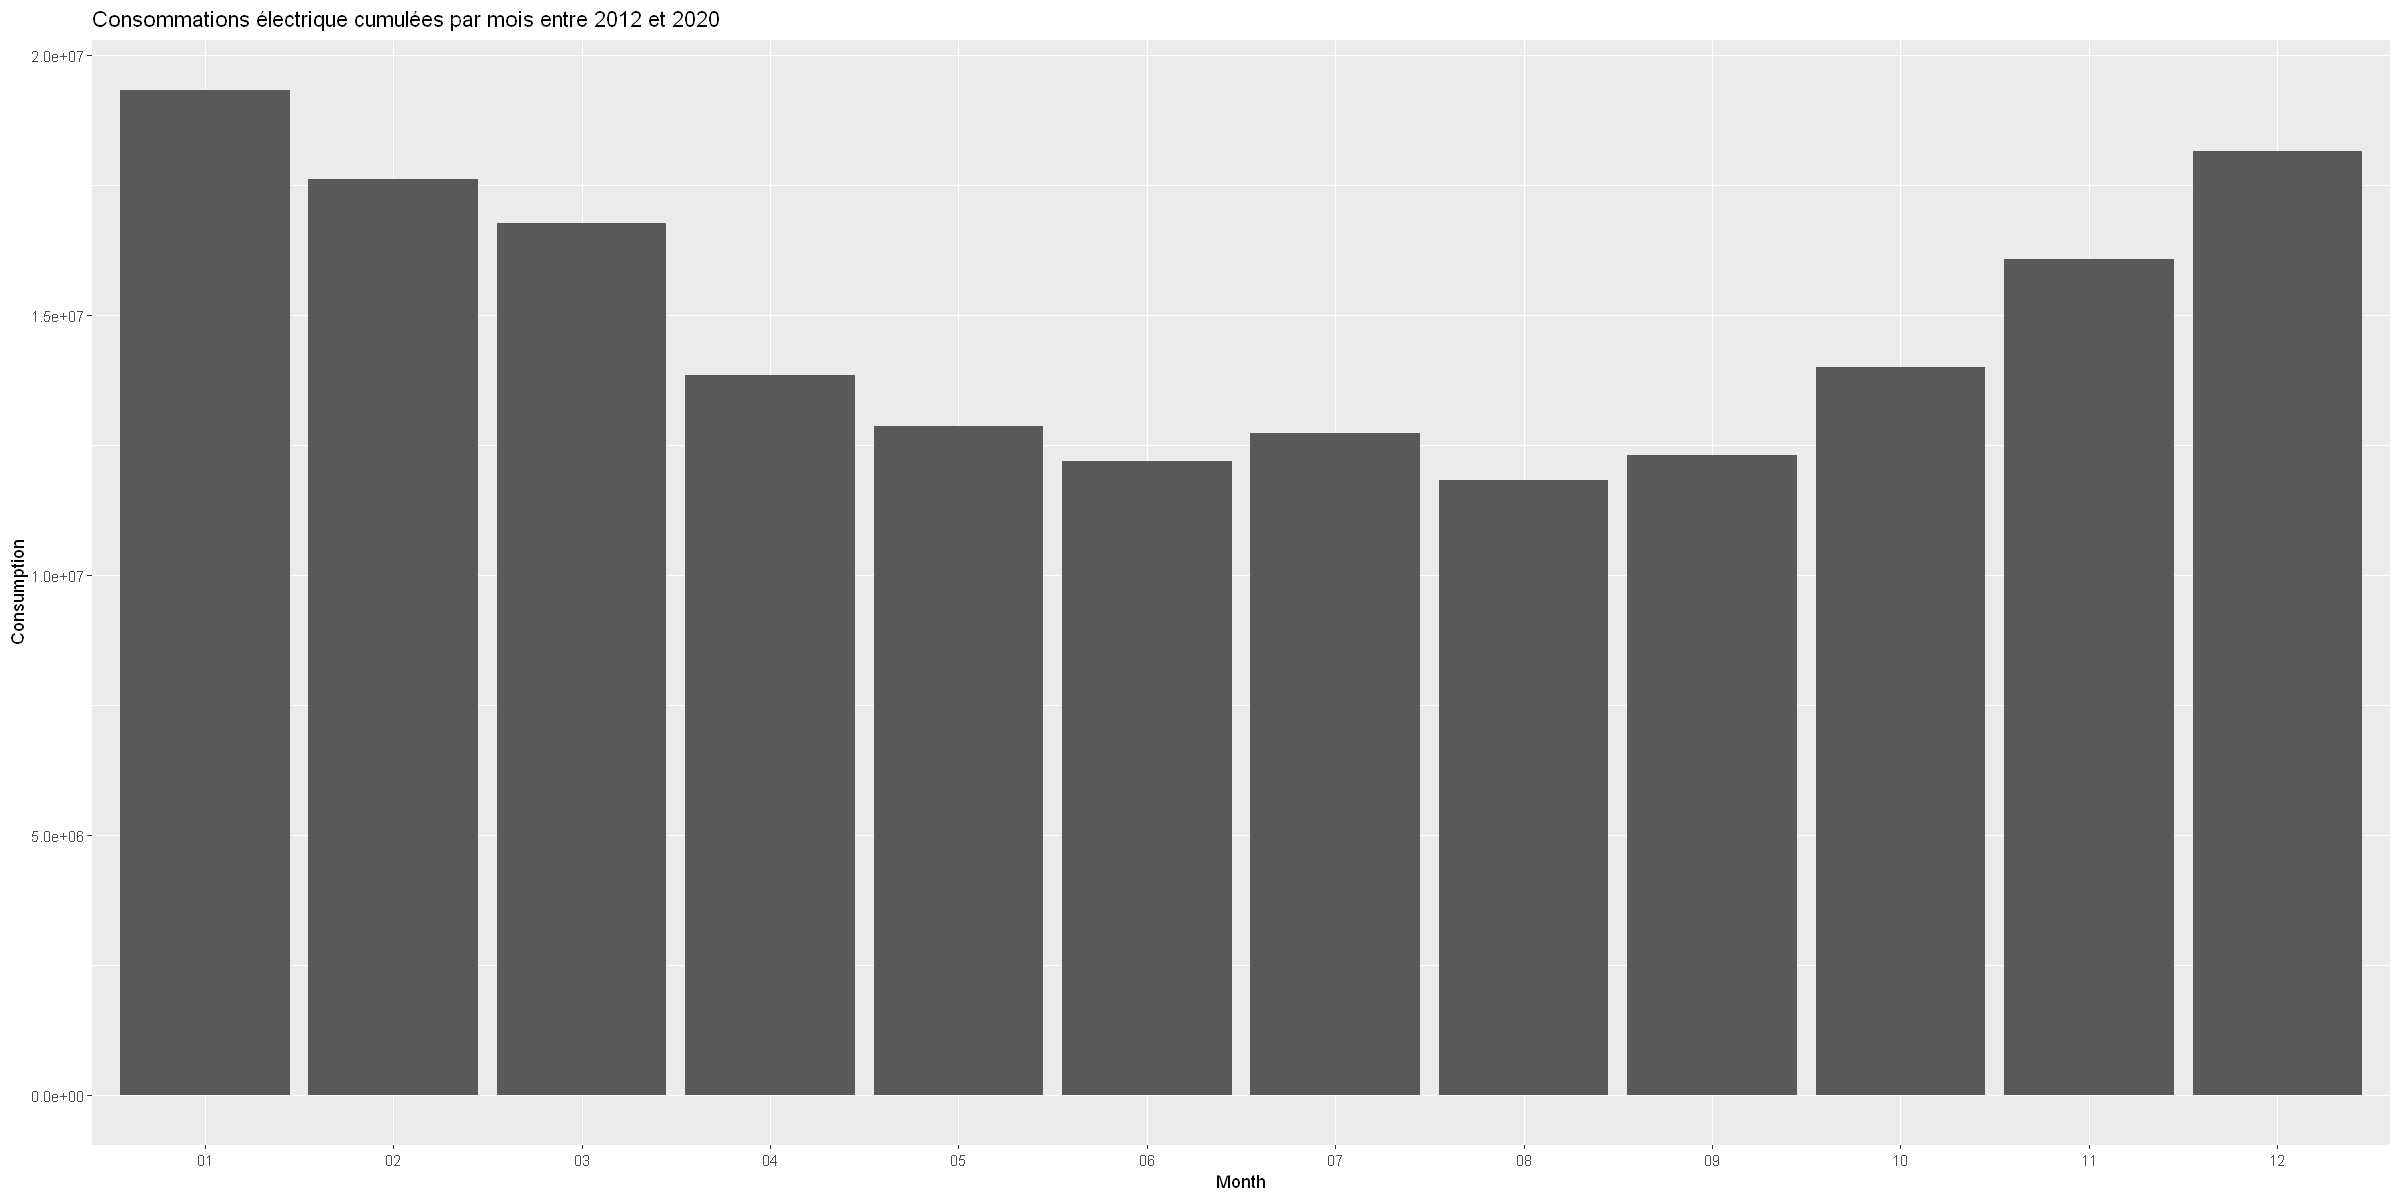

In [57]:
#Consommations électriques cumulées par mois entre 2012 et 2020
ggplot(data_train_0_notime,aes(Month,Consumption)) + geom_bar(stat = "identity") + ggtitle("Consommations électrique cumulées par mois entre 2012 et 2020")

Comme précédemment, nous créons une base de données annuelle "type" à partir de la base data_train_0.

In [56]:
data_train_0_type <- data_train_0 %>%
   group_by(Month, Day, Time) %>% 
   summarise_at(vars("Consumption"), mean)

data_train_0_type$Date = paste(data_train_0_type$Month, data_train_0_type$Day, sep="-")
data_train_0_type$Date = as.Date(data_train_0_type$Date, format = "%m-%d")
data_train_0_type <- data_train_0_type %>% select(Date, everything())
data_train_0_type <- data_train_0_type %>% drop_na()

data_train_0_type_notime <- data_train_0_type %>%
   group_by(Date) %>% 
   summarise_at(vars("Consumption"), mean)

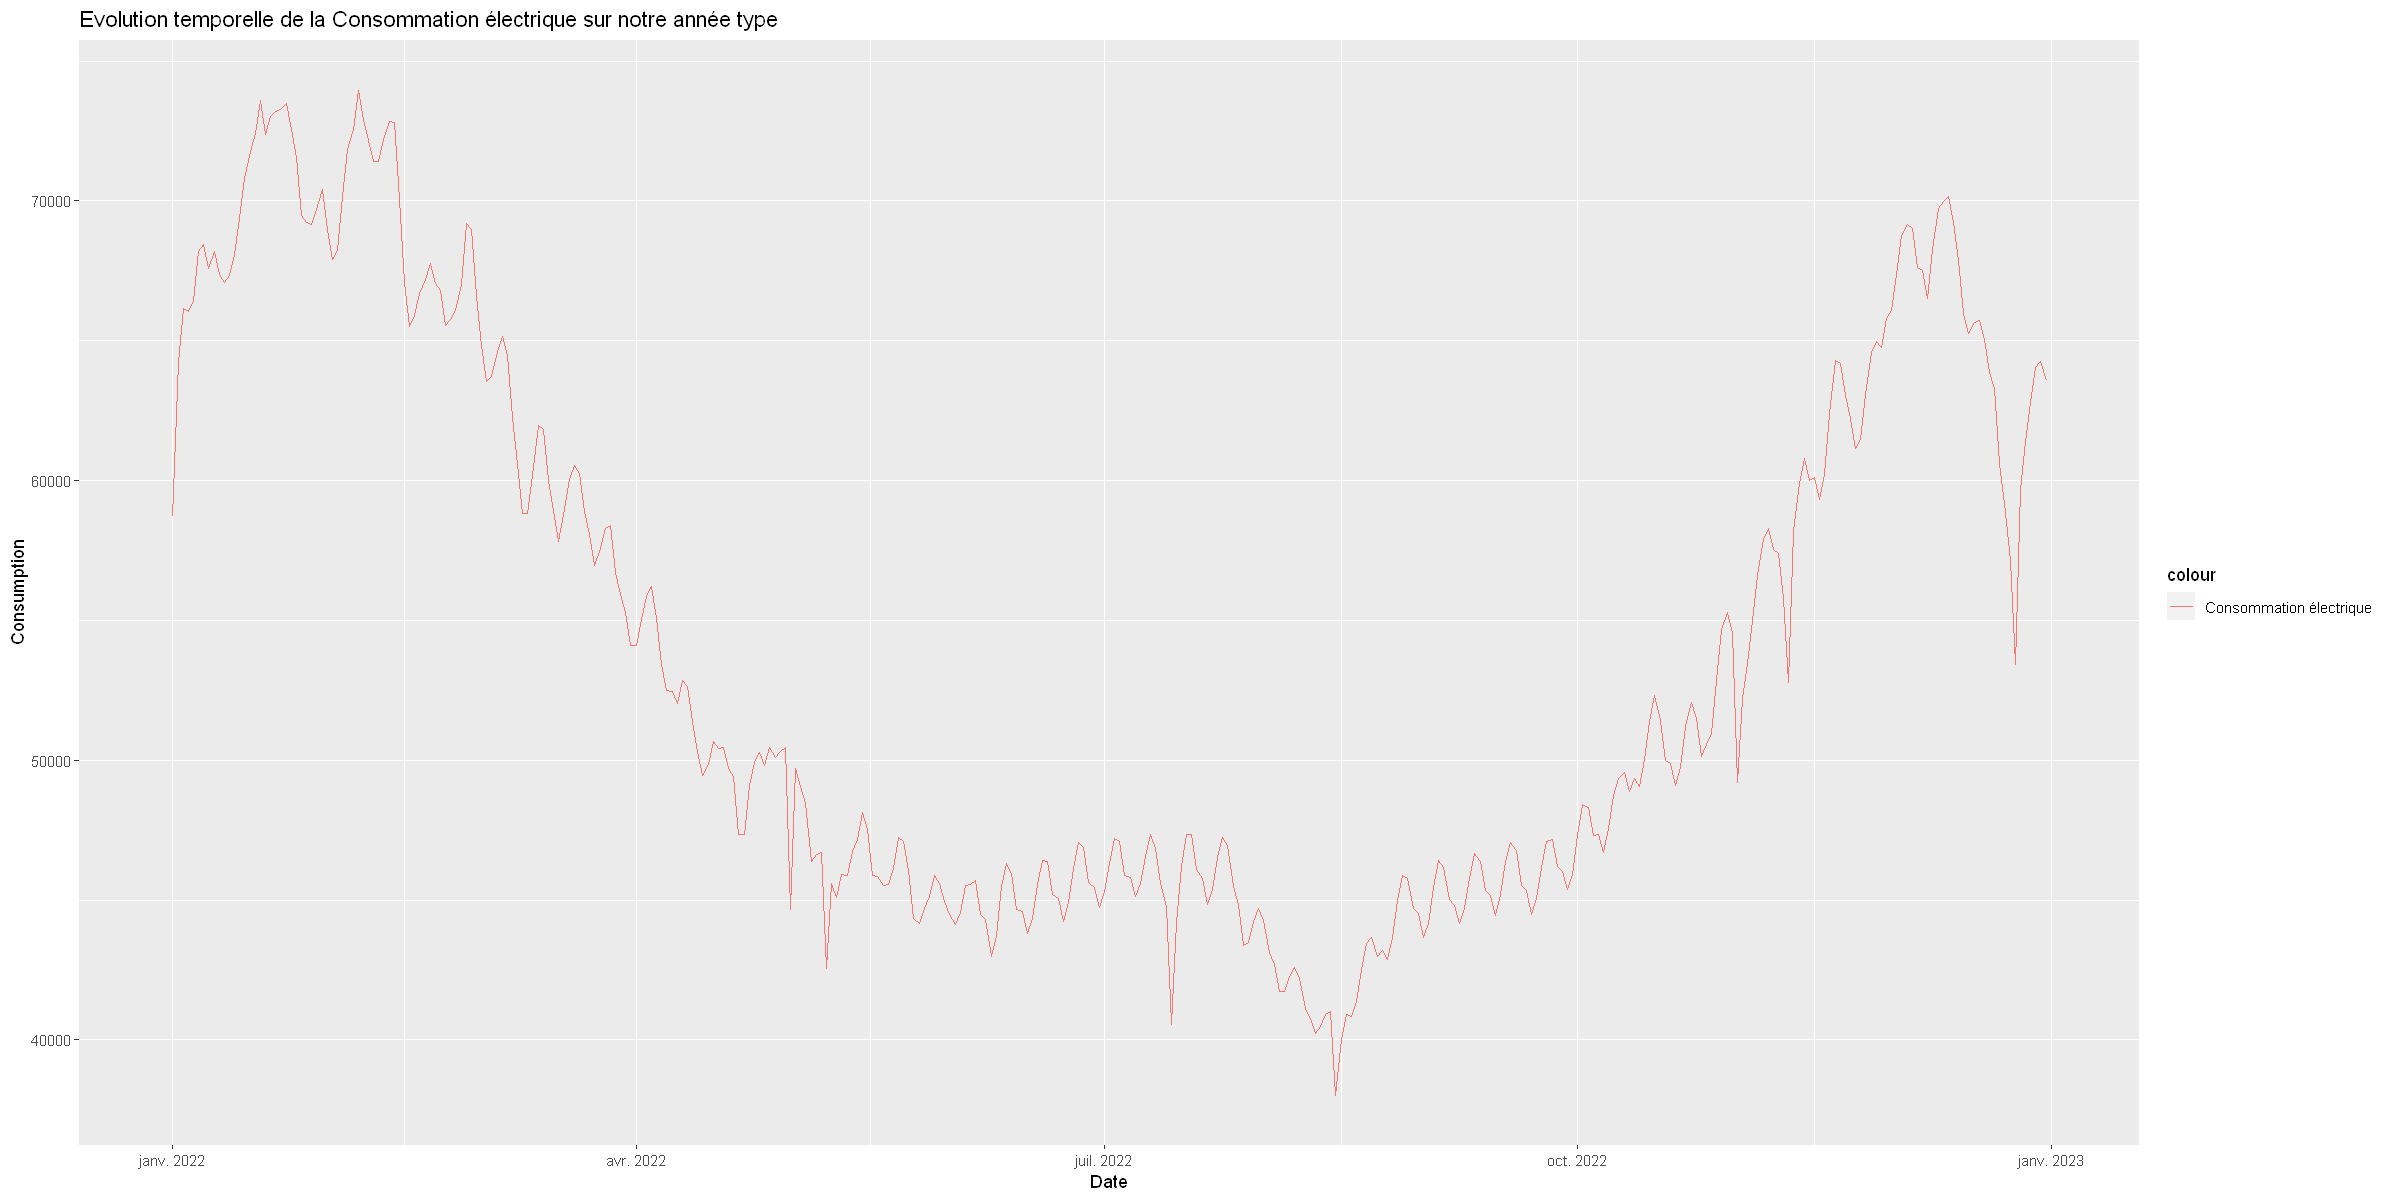

In [58]:
#Représentation graphique de la consommation électrique par jour sur notre année type
ggplot(data_train_0_type_notime, aes(Date, Consumption, colour="Consommation électrique")) + geom_line() + ggtitle("Evolution temporelle de la Consommation électrique sur notre année type")

Nous observons clairement une saisonnalité annuelle, avec plus de consommation électrique en hiver dont un pic à la hausse entre novembre et février, et moins de consommation électrique en été avec un pic à la baisse observé entre juin et août. Ces résultats paraissent cohérents, notamment en lien avec les résultats obtenus sur la température.

##### Etude de la saisonnalité mensuelle

A partir de notre base annuelle type, nous créons de manière similaire une mois type: base de donnée agrégée par le numéro du jour du mois.

In [59]:
data_train_0_type_notime = data_train_0_type_notime %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

data_train_0_month_type <- data_train_0_type_notime %>%
                group_by(Day) %>%
                summarise_at(vars("Consumption"), mean)

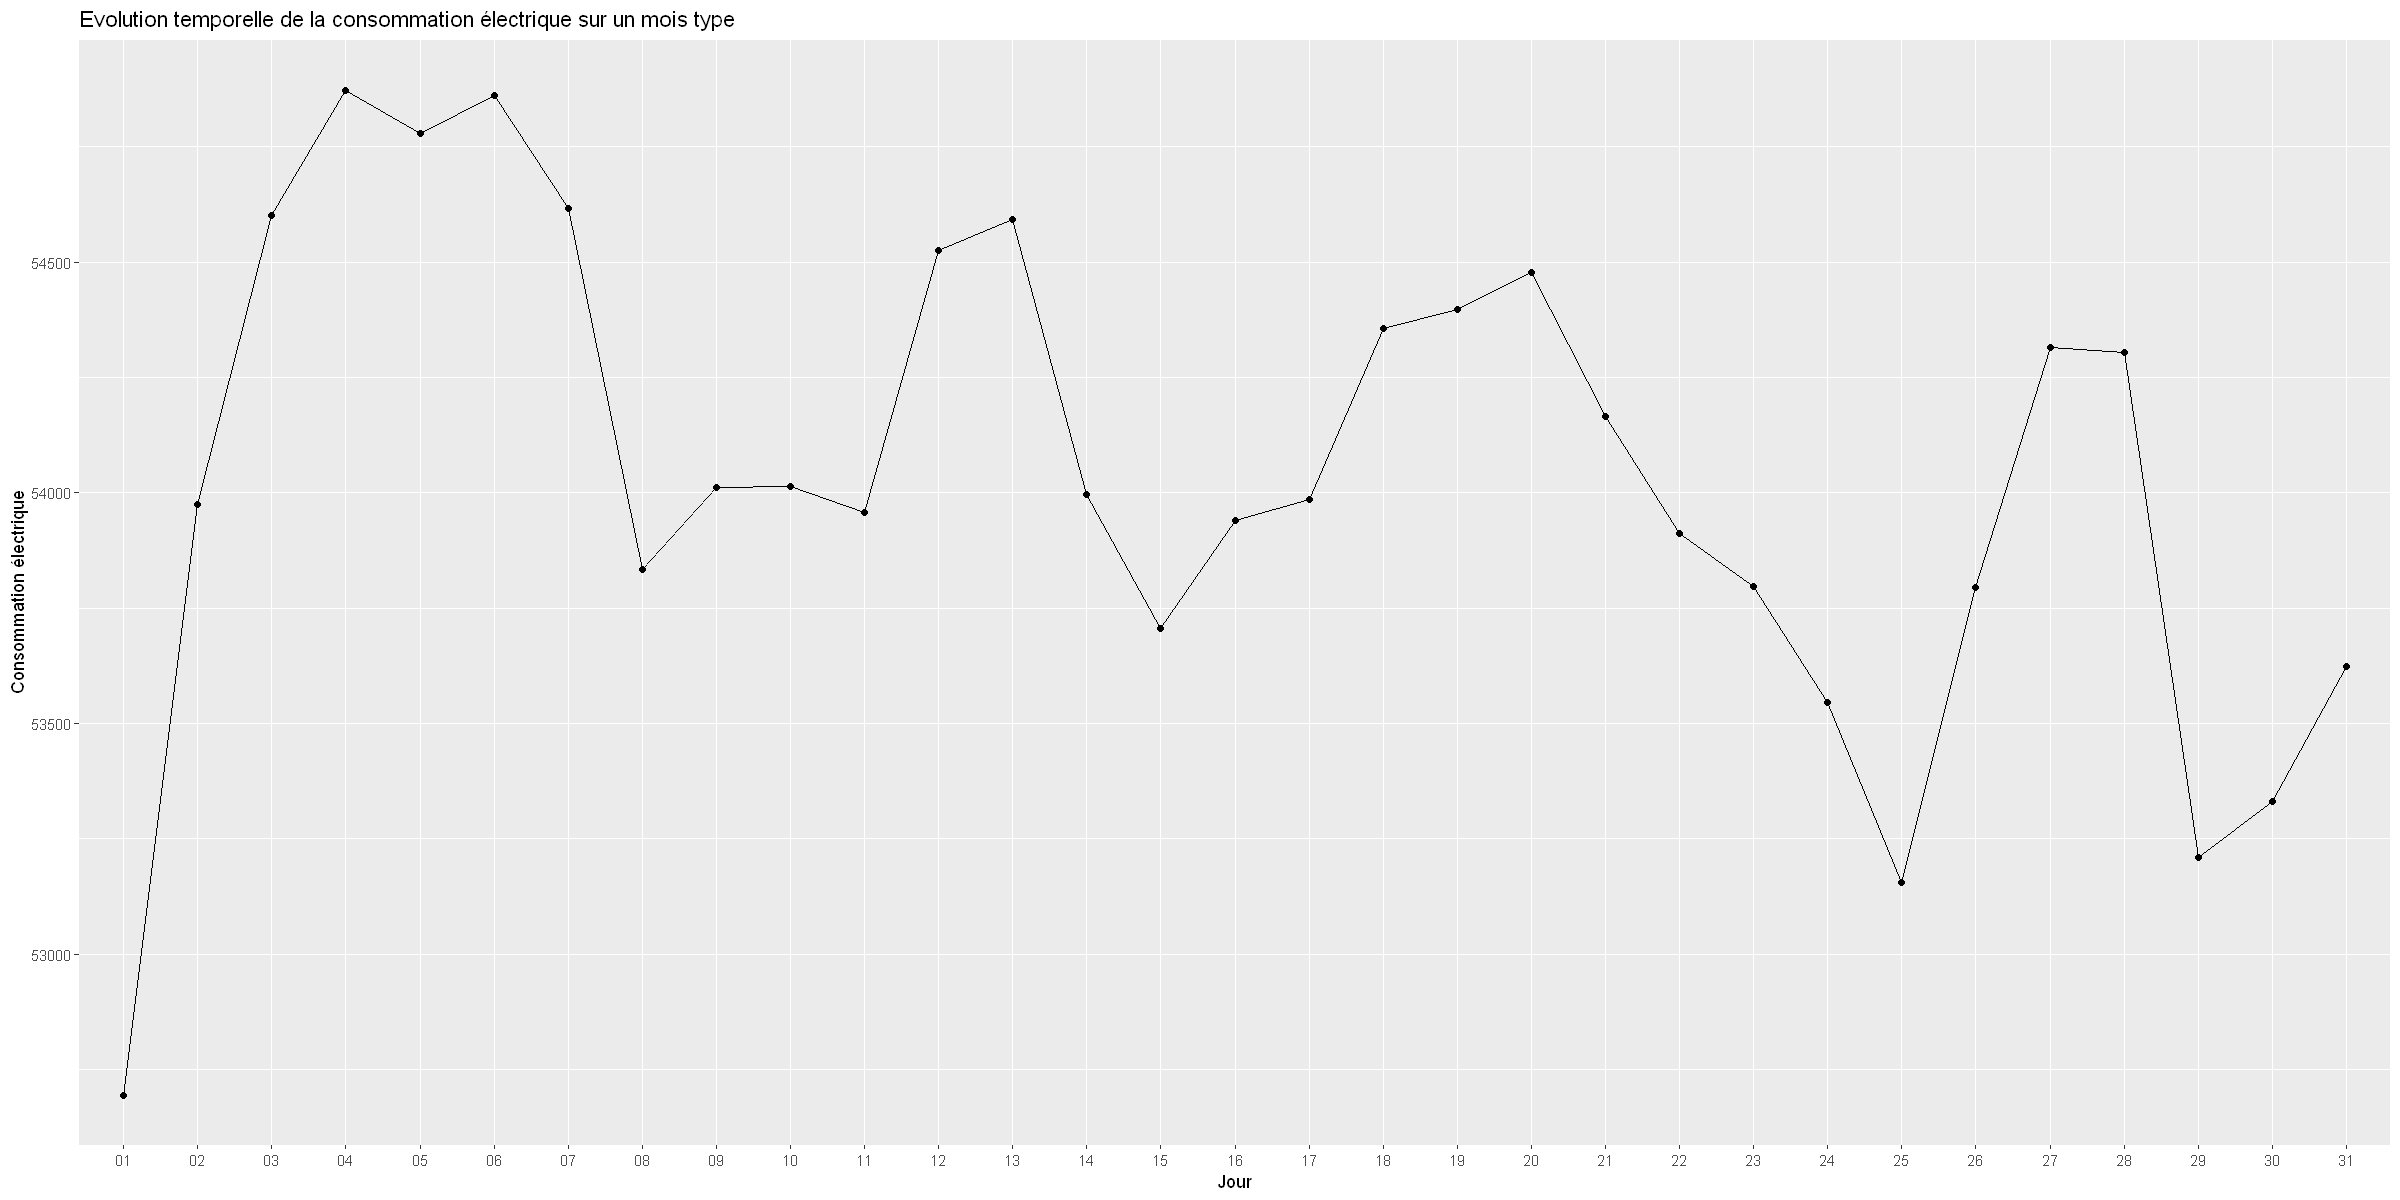

In [60]:
#Représentation graphique de la consommation électrique sur notre mois type
ggplot(data_train_0_month_type, aes(Day, Consumption, group = 1)) +
         geom_point() +
         geom_line() +
         labs(x = "Jour", y = "Consommation électrique", 
              title = "Evolution temporelle de la consommation électrique sur un mois type")

Nous observons une forte hausse de la consommation électrique en début de mois et certains pics à certains jours du mois: pics à la hausse les 3,5, 13, 20, 27 et 28 de chaque mois et pics à la baisse le 1er, 8, 15, 25 et 29 de chaque mois.

##### Etude de la saisonnalité hebdomadaire

Comme précédemment, nous créons une semaine type: base de données agrégée par jour de la semaine.

In [62]:
#Création d'une variable Day_number
data_train_0 <- data_train_0 %>%
  mutate(Day_number = case_when(
    data_train_0$Weekday == "lundi" ~ 1,
    data_train_0$Weekday == "mardi" ~ 2,
    data_train_0$Weekday == "mercredi" ~ 3,
    data_train_0$Weekday == "jeudi" ~ 4,
    data_train_0$Weekday == "vendredi" ~ 5,
    data_train_0$Weekday == "samedi" ~ 6,
    data_train_0$Weekday == "dimanche" ~ 7,
    ))

data_train_0_day_type <- data_train_0 %>%
    group_by(Day_number) %>%
    summarise_at(vars("Consumption"), mean)

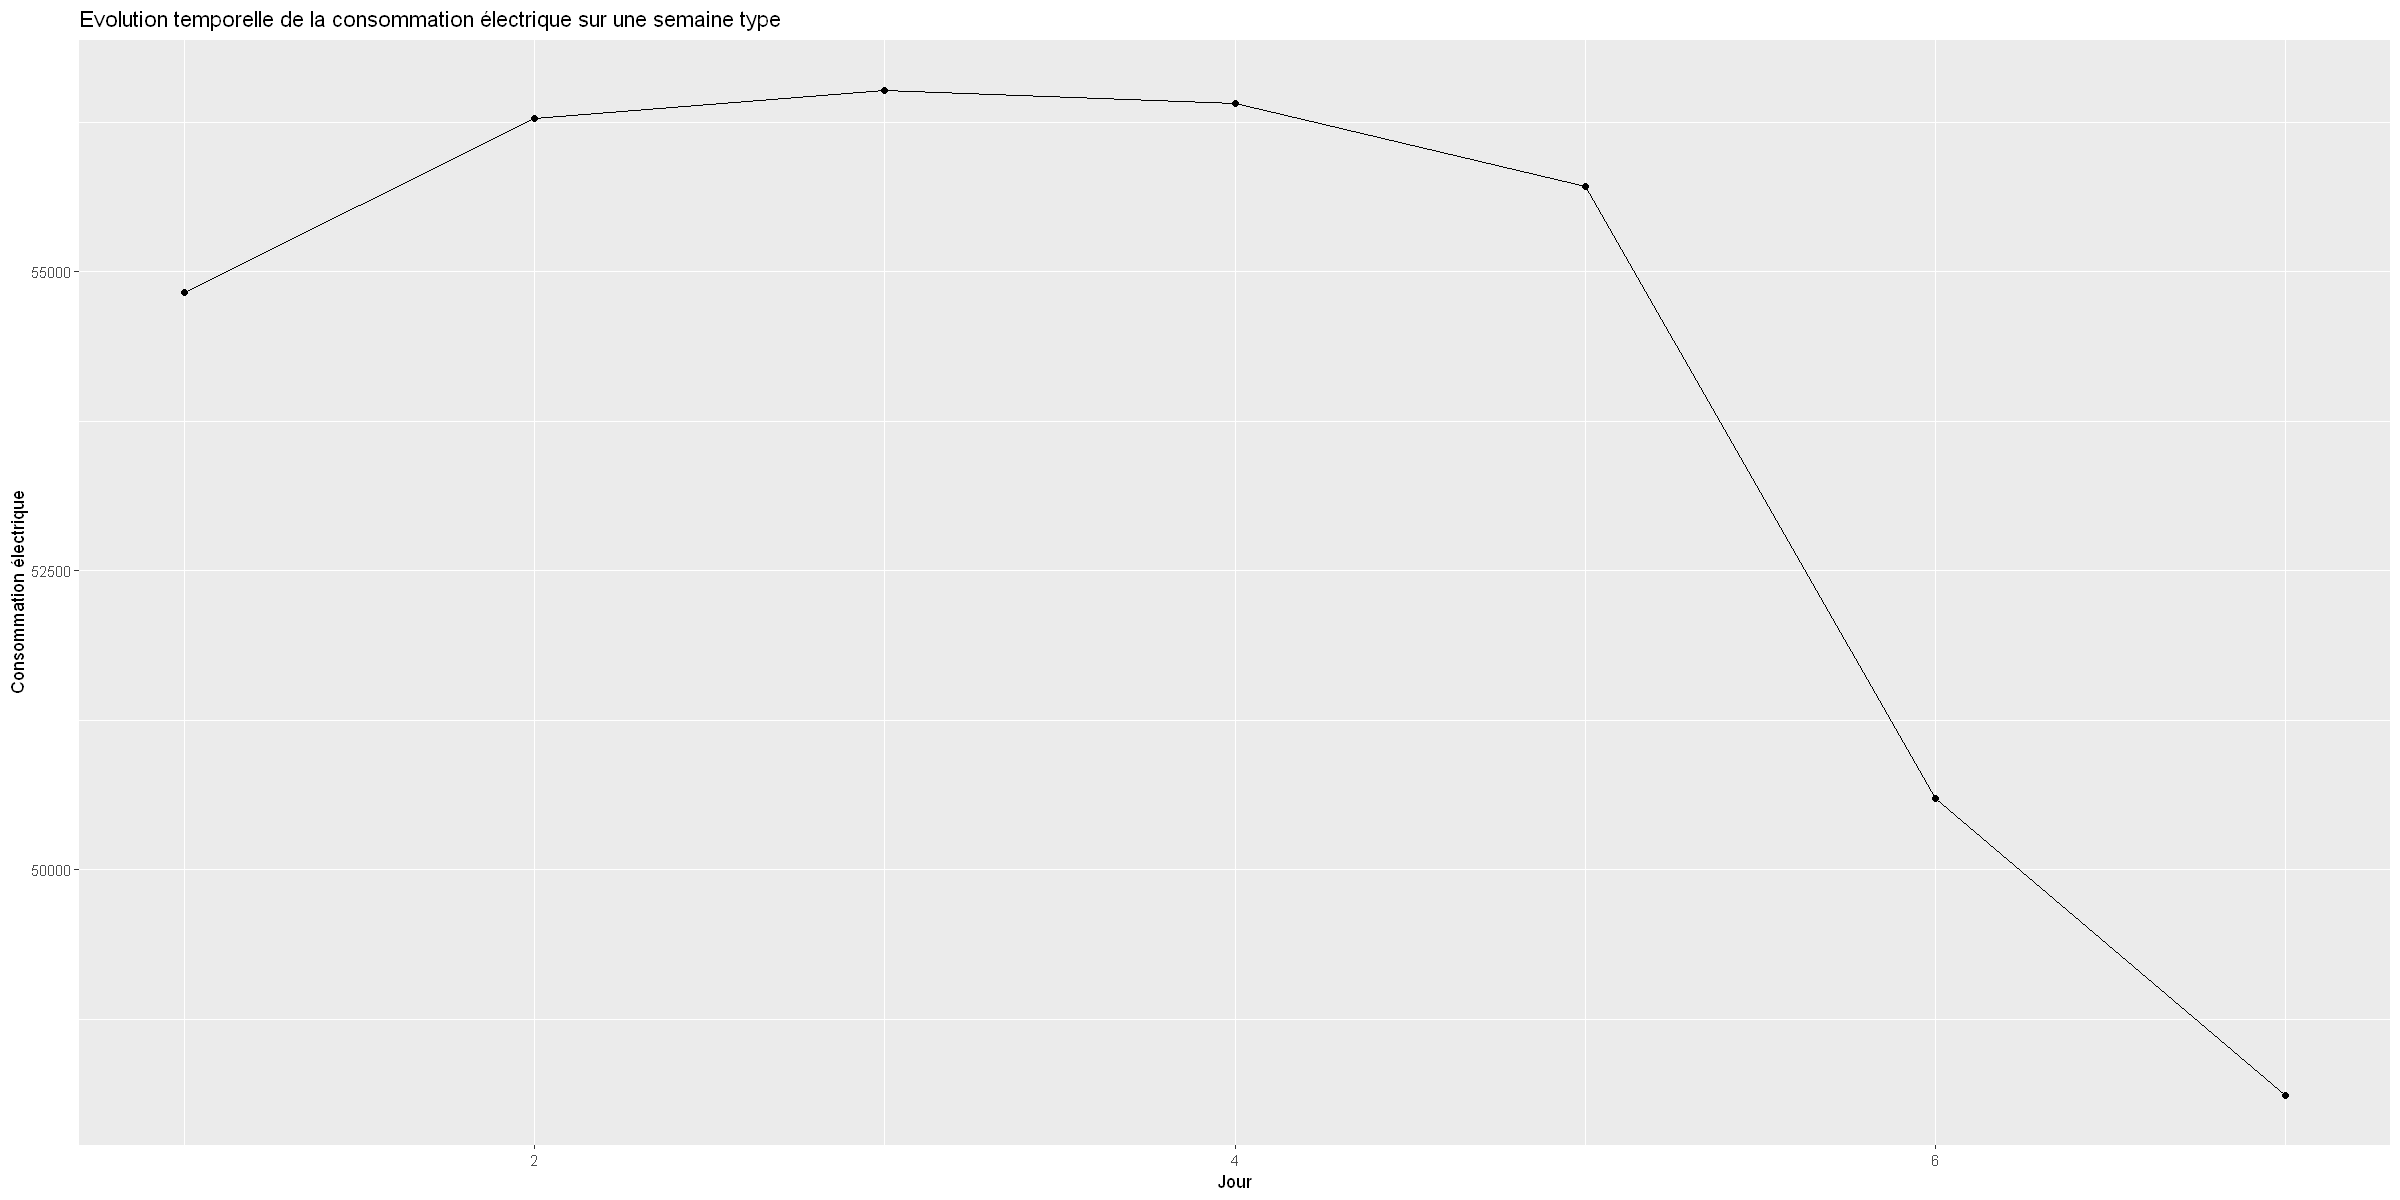

In [64]:
#Reorésentation graphique de la consommation électrique sur notre semaine type
ggplot(data_train_0_day_type, aes(Day_number, Consumption, group = 1)) +
         geom_point() +
         geom_line() +
         labs(x = "Jour", y = "Consommation électrique", 
              title = "Evolution temporelle de la consommation électrique sur une semaine type")

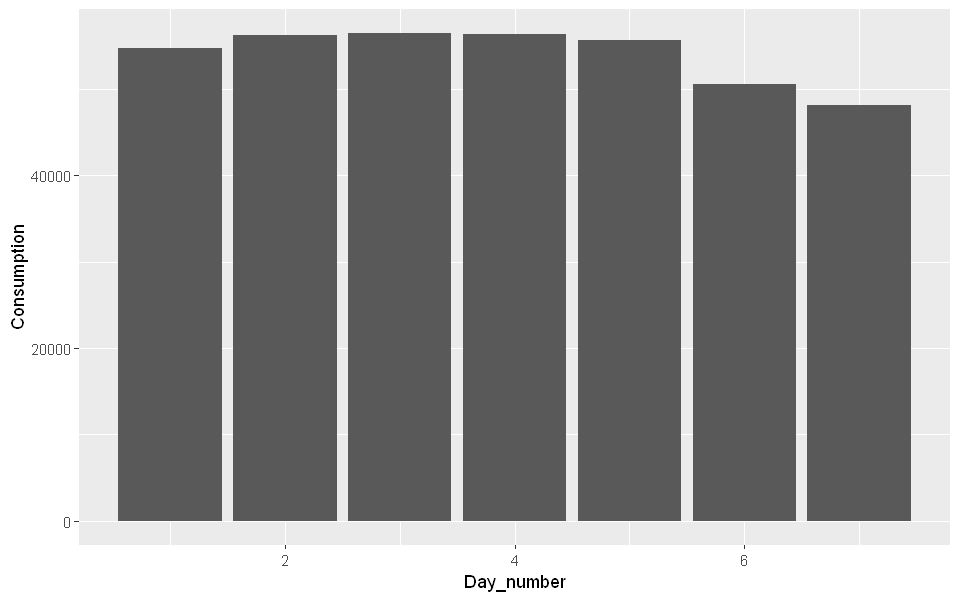

In [65]:
#Consommation électrique par jour de notre semaine type
options(repr.plot.width=8, repr.plot.height=5)
ggplot(data=data_train_0_day_type, aes(x=Day_number, y=Consumption)) + geom_bar(stat="identity")

Nous observons une hausse de la consommation électrique le mardi-mercredi-jeudi, une diminution le vendredi et une grande diminution le week-end. Nous observons également une plus faible consommation électrique le lundi par rapport aux autres jours ouvrés. Ces résultats paraissent cohérents, l'activité économique étant la plus active en milieu de semaine, et ralentissant fortement pendant les week-ends.

##### Etude de la saisonnalité journalière

Comme précédemment, nous créons une journée type: base de données agrégée par la variable 'Time'.

In [66]:
data_train_0_time_type <- data_train_0 %>%
    group_by(Time) %>%
    summarise_at(vars("Consumption"), mean)

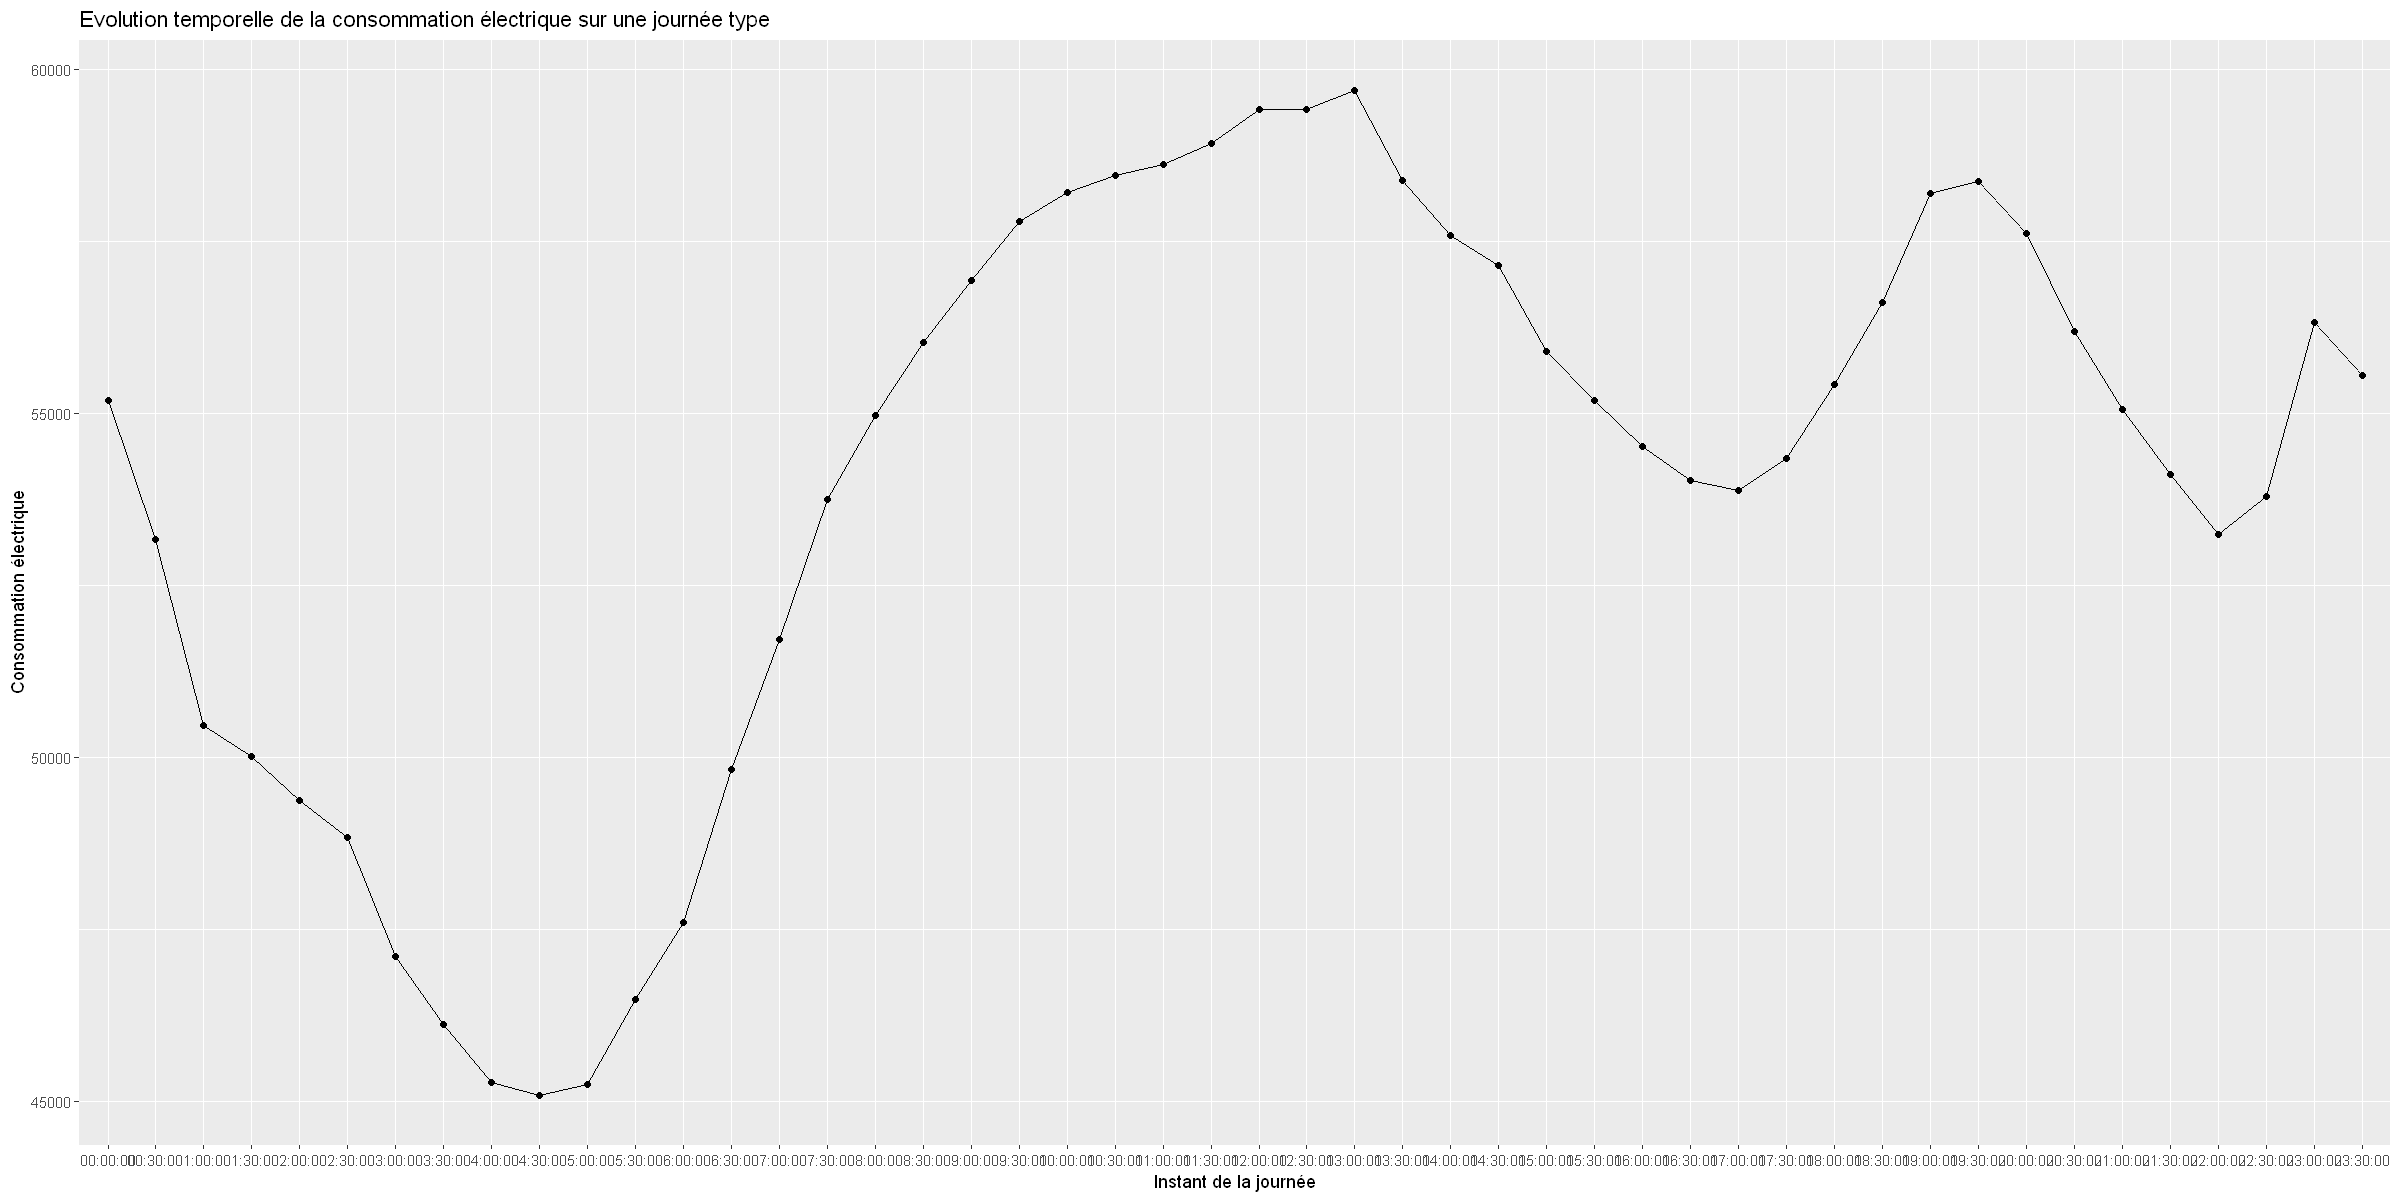

In [67]:
#Représentation graphique de la consommation électrique sur notre journée type
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_0_time_type, aes(Time, Consumption, group = 1)) +
         geom_point() +
         geom_line() +
         labs(x = "Instant de la journée", y = "Consommation électrique", 
              title = "Evolution temporelle de la consommation électrique sur une journée type")

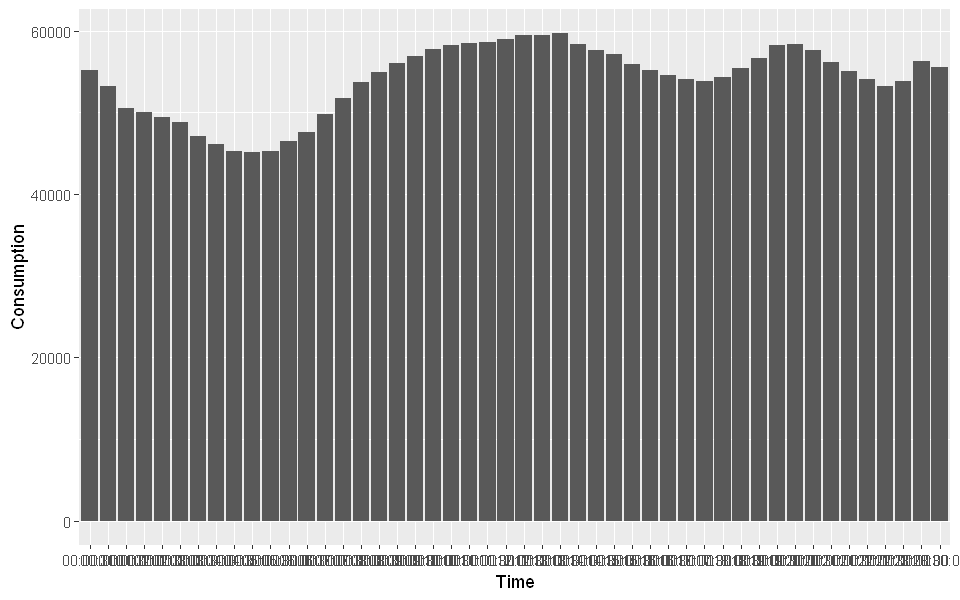

In [68]:
#Consommation électrique pour chaque horaire de notre journée type
options(repr.plot.width=8, repr.plot.height=5)
ggplot(data=data_train_0_time_type, aes(x=Time, y=Consumption)) + geom_bar(stat="identity")

Nous observons une forte hausse de la consommation électrique à partir de 6h du matin, puis un pic de la consommation à midi. La consommation électrique diminue à 15h puis il y a un second pic de la consommation entre 17h et 20h. Nous constatons enfin une baisse de la consommation à partir de 20h qui s'accentue à partir de minuit. Ces résultats paraissent cohérents avec les cycles de l'activité économique et de l'activité des ménages.

##### Etude des jours fériés

Comme précédemment, nous créons un base de données en agrégeant par jour férié afin de mieux comparer leurs effets.

In [69]:
data_train_0_ferie <- data_train_0 %>%
    group_by(jour_ferie) %>%
    summarise_at(vars("Consumption"), mean)

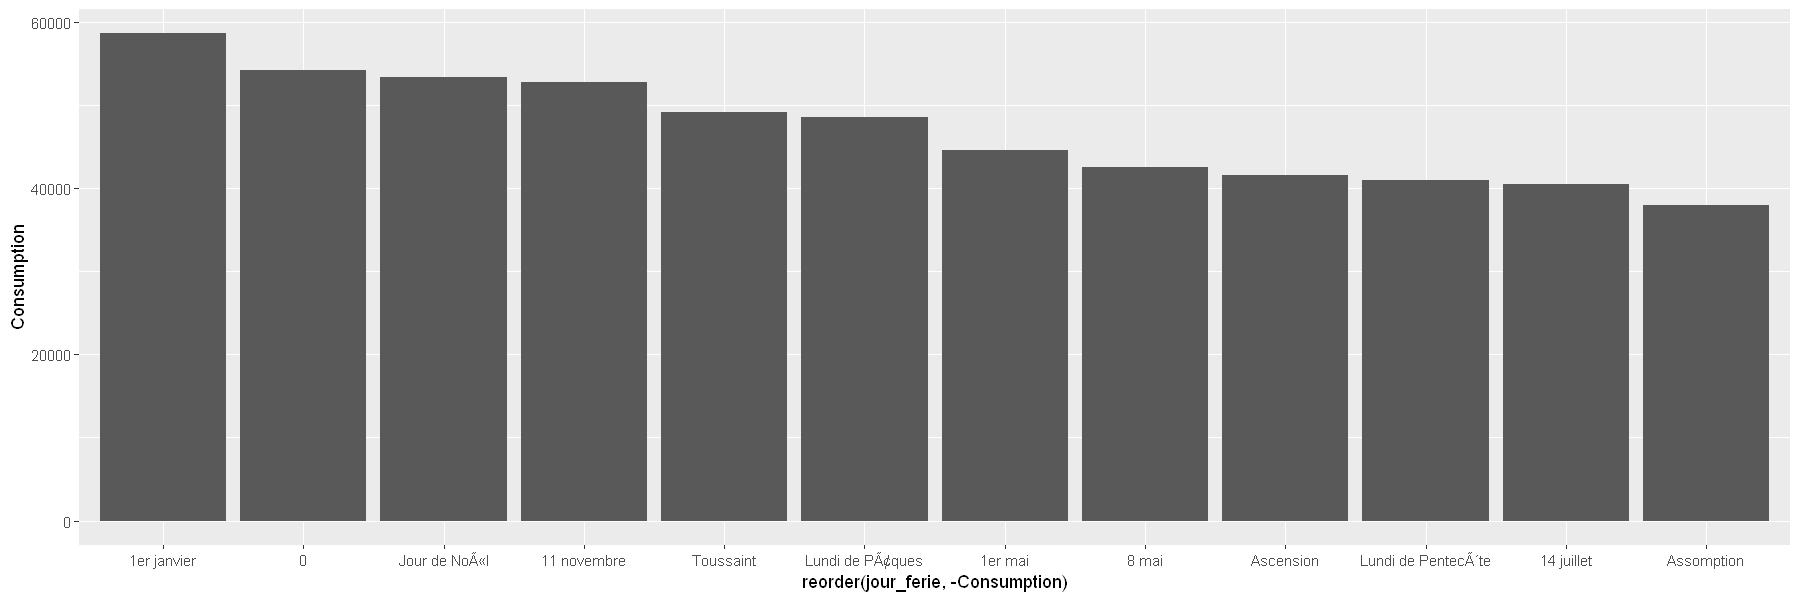

In [70]:
#Consommations électriques cumulées par jour férié entre 2012 et 2020
options(repr.plot.width=15, repr.plot.height=5)
ggplot(data=data_train_0_ferie, aes(x=reorder(jour_ferie, -Consumption), y=Consumption)) + geom_bar(stat="identity")

Nous créons ensuite une variable jour férié type, pour comparer l'effet d'un jour férié quelconque par rapport à un jour ouvré classique.

In [71]:
data_train_0_ferie <- data_train_0_ferie %>%
  mutate(jour_ferie = case_when(
    data_train_0_ferie$jour_ferie == 0 ~ 0,
    data_train_0_ferie$jour_ferie != 0 ~ 1,
    ))

data_train_0_ferie <- data_train_0_ferie %>%
    group_by(jour_ferie) %>%
    summarise_at(vars("Consumption"), mean)

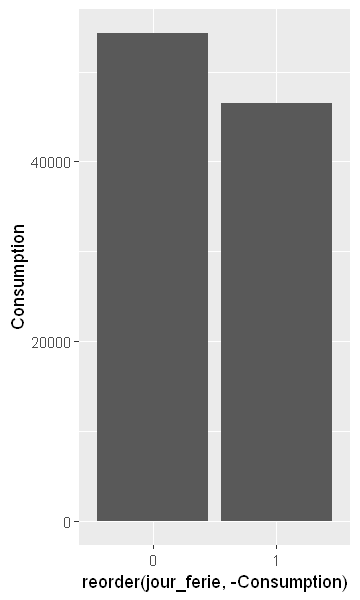

In [72]:
#Consommations électriques cumulées en jour férié vs hors jour férié
options(repr.plot.width=3, repr.plot.height=5)
ggplot(data=data_train_0_ferie, aes(x=reorder(jour_ferie, -Consumption), y=Consumption)) + geom_bar(stat="identity")

In [93]:
#Calcul de la variation de consommation électrique
data_train_0_ferie$growth <- with(data_train_0_ferie, ave(Consumption,
                          FUN=function(x) c(NA, diff(x) / tail(x, -1))))
paste(as.integer(data_train_0_ferie$growth[2]*100),'%')

[1] "-16 %"

En moyenne, la consommation d'électricité diminue de 16% environ en jour férié. Nous constatons néanmoins des disparités selon le type de jour férié: nous consommons davantage d'électricité le 1er janvier et beaucoup moins lors de l'Assomption, lié également à la saison et température liées au mois du jour férié.

##### Etudes des vacances

Comme précédemment, nous créons un jour de vacances type en agrégeant par la variable 'Holidays'.

In [76]:
data_train_0_holidays <- data_train_0 %>%
    group_by(Holidays) %>%
    summarise_at(vars("Consumption"), mean)

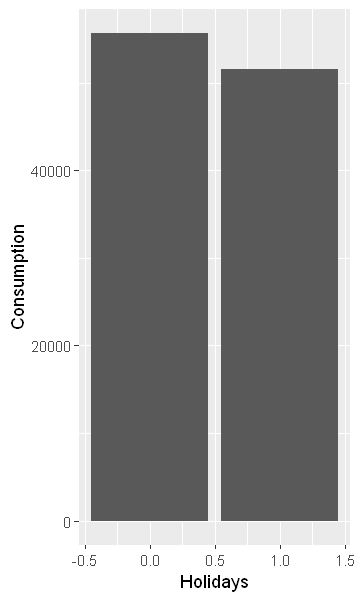

In [77]:
#Consommations électriques cumulées en vacances vs hors vacances, entre 2012 et 2020
ggplot(data=data_train_0_holidays, aes(x=Holidays, y=Consumption)) + geom_bar(stat="identity")

In [88]:
#Calcul de la variation de consommation électrique
data_train_0_holidays$growth <- with(data_train_0_holidays, ave(Consumption,
                          FUN=function(x) c(NA, diff(x) / tail(x, -1))))
paste(as.integer(data_train_0_holidays$growth[2]*100),'%')

[1] "-7%"

En moyenne, la consommation d'électricité diminue de 7% environ pendant les vacances.

Afin d'affiner nos résultats, nous étudions l'effet des vacances par zone scolaire.

In [80]:
#Création d'une base de données agrégée pour chaque zone scolaire
data_train_day_type_holidays_A <- subset(data_train_0, Holidays_A==1)
data_train_day_type_holidays_A <- data_train_day_type_holidays_A %>%
  mutate(Day_number = case_when(
    data_train_day_type_holidays_A$Weekday == "lundi" ~ 1,
    data_train_day_type_holidays_A$Weekday == "mardi" ~ 2,
    data_train_day_type_holidays_A$Weekday == "mercredi" ~ 3,
    data_train_day_type_holidays_A$Weekday == "jeudi" ~ 4,
    data_train_day_type_holidays_A$Weekday == "vendredi" ~ 5,
    data_train_day_type_holidays_A$Weekday == "samedi" ~ 6,
    data_train_day_type_holidays_A$Weekday == "dimanche" ~ 7,
    ))

data_train_day_type_holidays_A <- data_train_day_type_holidays_A %>%
    group_by(Day_number) %>%
    summarise_at(vars("Consumption"), mean)

data_train_day_type_holidays_B <- subset(data_train_0, Holidays_B==1)
data_train_day_type_holidays_B <- data_train_day_type_holidays_B %>%
  mutate(Day_number = case_when(
    data_train_day_type_holidays_B$Weekday == "lundi" ~ 1,
    data_train_day_type_holidays_B$Weekday == "mardi" ~ 2,
    data_train_day_type_holidays_B$Weekday == "mercredi" ~ 3,
    data_train_day_type_holidays_B$Weekday == "jeudi" ~ 4,
    data_train_day_type_holidays_B$Weekday == "vendredi" ~ 5,
    data_train_day_type_holidays_B$Weekday == "samedi" ~ 6,
    data_train_day_type_holidays_B$Weekday == "dimanche" ~ 7,
    ))

data_train_day_type_holidays_B <- data_train_day_type_holidays_B %>%
    group_by(Day_number) %>%
    summarise_at(vars("Consumption"), mean)

data_train_day_type_holidays_C <- subset(data_train_0, Holidays_C==1)
data_train_day_type_holidays_C <- data_train_day_type_holidays_C %>%
  mutate(Day_number = case_when(
    data_train_day_type_holidays_C$Weekday == "lundi" ~ 1,
    data_train_day_type_holidays_C$Weekday == "mardi" ~ 2,
    data_train_day_type_holidays_C$Weekday == "mercredi" ~ 3,
    data_train_day_type_holidays_C$Weekday == "jeudi" ~ 4,
    data_train_day_type_holidays_C$Weekday == "vendredi" ~ 5,
    data_train_day_type_holidays_C$Weekday == "samedi" ~ 6,
    data_train_day_type_holidays_C$Weekday == "dimanche" ~ 7,
    ))

data_train_day_type_holidays_C <- data_train_day_type_holidays_C %>%
    group_by(Day_number) %>%
    summarise_at(vars("Consumption"), mean)

#Création d'une base de données agrégée globale: Holidays = 1 si au moins une zone est en vacances
data_train_day_type_holidays <- subset(data_train_0, Holidays==1)
data_train_day_type_holidays <- data_train_day_type_holidays %>%
  mutate(Day_number = case_when(
    data_train_day_type_holidays$Weekday == "lundi" ~ 1,
    data_train_day_type_holidays$Weekday == "mardi" ~ 2,
    data_train_day_type_holidays$Weekday == "mercredi" ~ 3,
    data_train_day_type_holidays$Weekday == "jeudi" ~ 4,
    data_train_day_type_holidays$Weekday == "vendredi" ~ 5,
    data_train_day_type_holidays$Weekday == "samedi" ~ 6,
    data_train_day_type_holidays$Weekday == "dimanche" ~ 7,
    ))

data_train_day_type_holidays <- data_train_day_type_holidays %>%
    group_by(Day_number) %>%
    summarise_at(vars("Consumption"), mean)

#Fusion des données obtenues dans la base de données de la semaine type
data_train_0_day_type$Consumption_A <- data_train_day_type_holidays_A$Consumption
data_train_0_day_type$Consumption_B <- data_train_day_type_holidays_B$Consumption
data_train_0_day_type$Consumption_C <- data_train_day_type_holidays_C$Consumption
data_train_0_day_type$Consumption_nozone <- data_train_day_type_holidays$Consumption

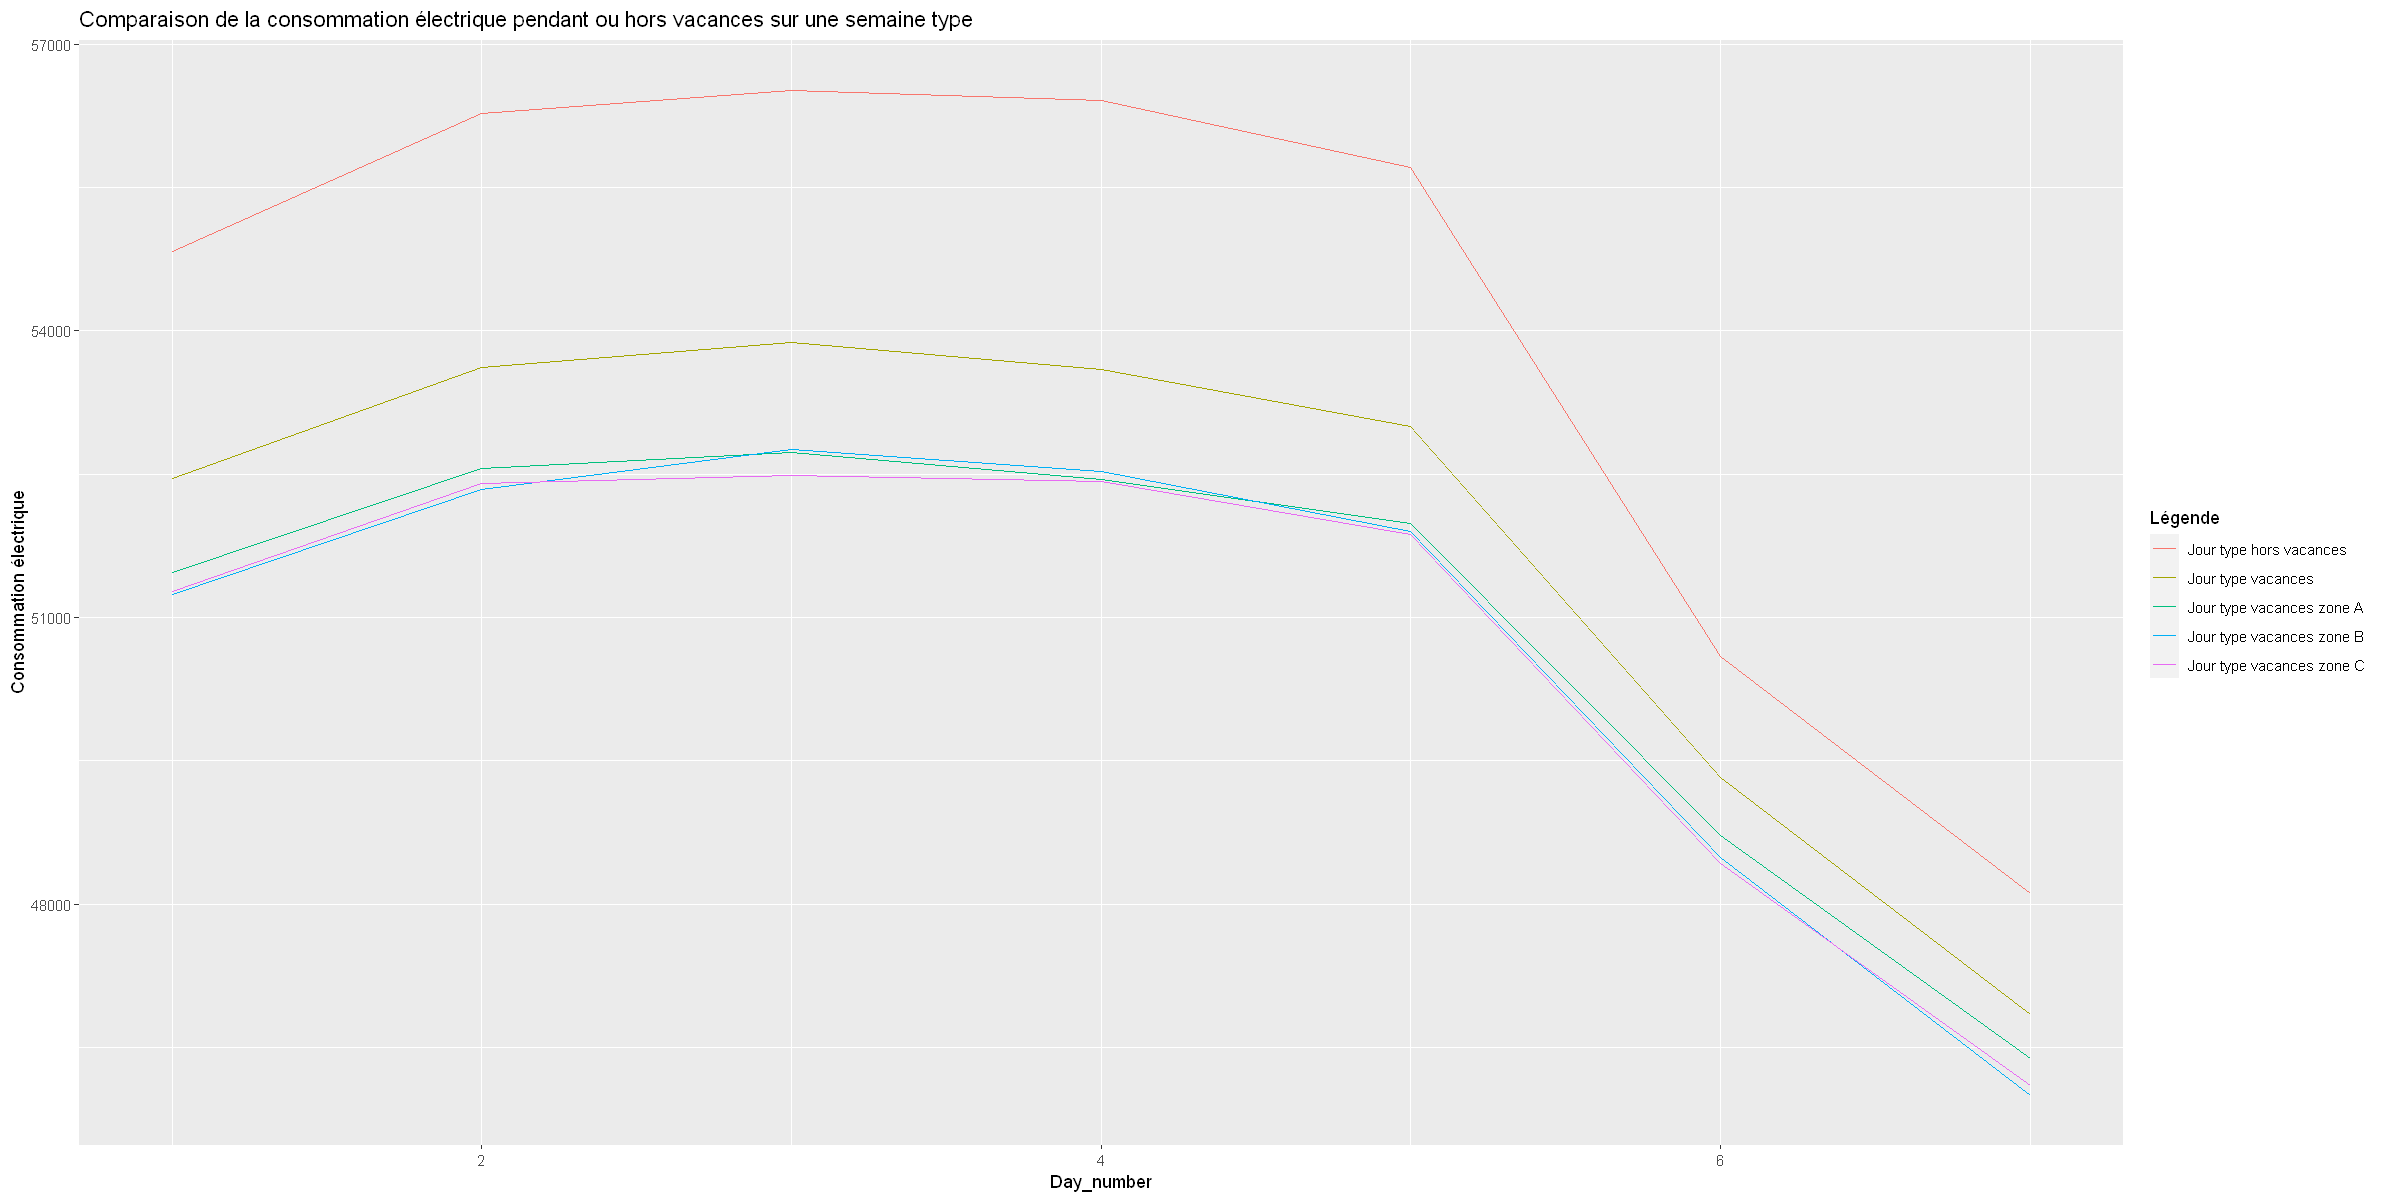

In [81]:
#Représentations graphiques de la consommation électrique hors vacances, et en vacances selon les zones A, B ou C
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_0_day_type, aes(x=Day_number, y=Consumption, group = 1, color = 'Jour type hors vacances')) + 
    geom_line() +
    geom_line(aes(x=Day_number, y=Consumption_A, colour = 'Jour type vacances zone A')) +
    geom_line(aes(x=Day_number, y=Consumption_B, colour = 'Jour type vacances zone B')) +
    geom_line(aes(x=Day_number, y=Consumption_C, colour = 'Jour type vacances zone C')) +
    geom_line(aes(x=Day_number, y=Consumption_nozone, colour = 'Jour type vacances')) +
    labs(colour = "Légende") +
    labs(title = "Comparaison de la consommation électrique pendant ou hors vacances sur une semaine type") +
    ylab("Consommation électrique")

Comme nous pouvions nous y attendre, la consommation électrique est moindre quand on considère chaque zone de vacances individuellement. La diminution de la consommation électrique lors des vacances est semblable entre les zones.

In [83]:
#Pour calculer la variation observée par zone, on crée un jour de vacances type zone B
data_train_holidays_B <- data_train_0 %>%
    group_by(Holidays_B) %>%
    summarise_at(vars("Consumption"), mean)
data_train_holidays_B$growth <- with(data_train_holidays_B, ave(Consumption,
                          FUN=function(x) c(NA, diff(x) / tail(x, -1))))
paste(as.integer(data_train_holidays_B$growth[2]*100),"%")

[1] "-10 %"

Avec plus de précision, nous pouvons donc dire que la consommation électrique diminue en moyenne de 10% environ lors des vacances scolaires.

##### Etudes des jours ouvrés

Comme précédemment, nous créons un jour ouvré type.

In [97]:
data_train_0_jour_ouvre <- data_train_0 %>%
    group_by(Jour_ouvre) %>%
    summarise_at(vars("Consumption"), mean)

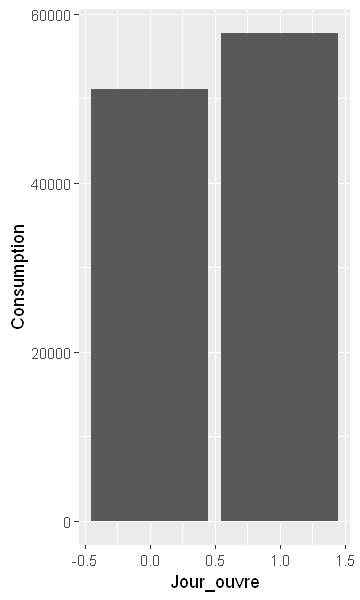

In [98]:
#Consommations électriques cumulées par jour ouvré, entre 2012 et 2020
options(repr.plot.width=3, repr.plot.height=5)
ggplot(data=data_train_0_jour_ouvre, aes(x=Jour_ouvre, y=Consumption)) + geom_bar(stat="identity")

In [100]:
#Calcul de la variation observée
data_train_0_jour_ouvre$growth <- with(data_train_0_jour_ouvre, ave(Consumption,
                          FUN=function(x) c(NA, diff(x) / tail(x, -1))))
paste(as.integer(data_train_0_jour_ouvre$growth[2]*100),'%')

[1] "11 %"

En moyenne, la consommation électrique est supérieure de 11% environ en jour ouvré, ce qui parait cohérent.

###### Etude de l'activité économique

Pour étudier l'effet de l'activité économique sur la consommation électrique, nous téléchargeons un indice mensuel de production industrielle sur le site de l'INSEE. \
Il s'agit de l'indice suivant: "Indice CVS-CJO de la production industrielle (base 100 en 2015) - Industrie manufacturière (NAF rév. 2, niveau A10, poste CZ) - Variations mensuelles"

In [101]:
#Nettoyage de la base de données
prod_ind <- read.csv("indice_production_industrielle.csv", sep= ";")
prod_ind <- subset(prod_ind, select=c(1,2))
colnames(prod_ind) <- c("Date","Indice_prod")
prod_ind$Year <- substr(prod_ind$Date,1,4)
prod_ind$Month <- substr(prod_ind$Date,6,7)
prod_ind = subset(prod_ind, select = -c(Date) )

In [102]:
#Création d'une base de données avec une ligne par mois (consommations électriques sommées), pour éviter d'avoir des données dupliquées
data_train_0_month_mean <- data_train_0 %>%
    group_by(Year,Month) %>%
    summarise_at(vars("Consumption"), sum)

#Fusion des 2 bases
data_train_0_month_mean = left_join(data_train_0_month_mean, prod_ind ,c("Year","Month"))

#Consommation et indice de production normalisés
data_train_0_month_mean$Indice_prod_normalized <- (data_train_0_month_mean$Indice_prod - mean(data_train_0_month_mean$Indice_prod)) / sd(data_train_0_month_mean$Indice_prod)
data_train_0_month_mean$Consumption_normalized <- (data_train_0_month_mean$Consumption - mean(data_train_0_month_mean$Consumption)) / sd(data_train_0_month_mean$Consumption)

In [103]:
#Ajout d'une variable Date
data_train_0_month_mean$Date <- paste(data_train_0_month_mean$Year, data_train_0_month_mean$Month, sep="-")
data_train_0_month_mean$Date <- paste0(data_train_0_month_mean$Date,'-01')
data_train_0_month_mean$Date <- as.Date(data_train_0_month_mean$Date, format = "%Y-%m-%d")

`geom_smooth()` using formula 'y ~ x'



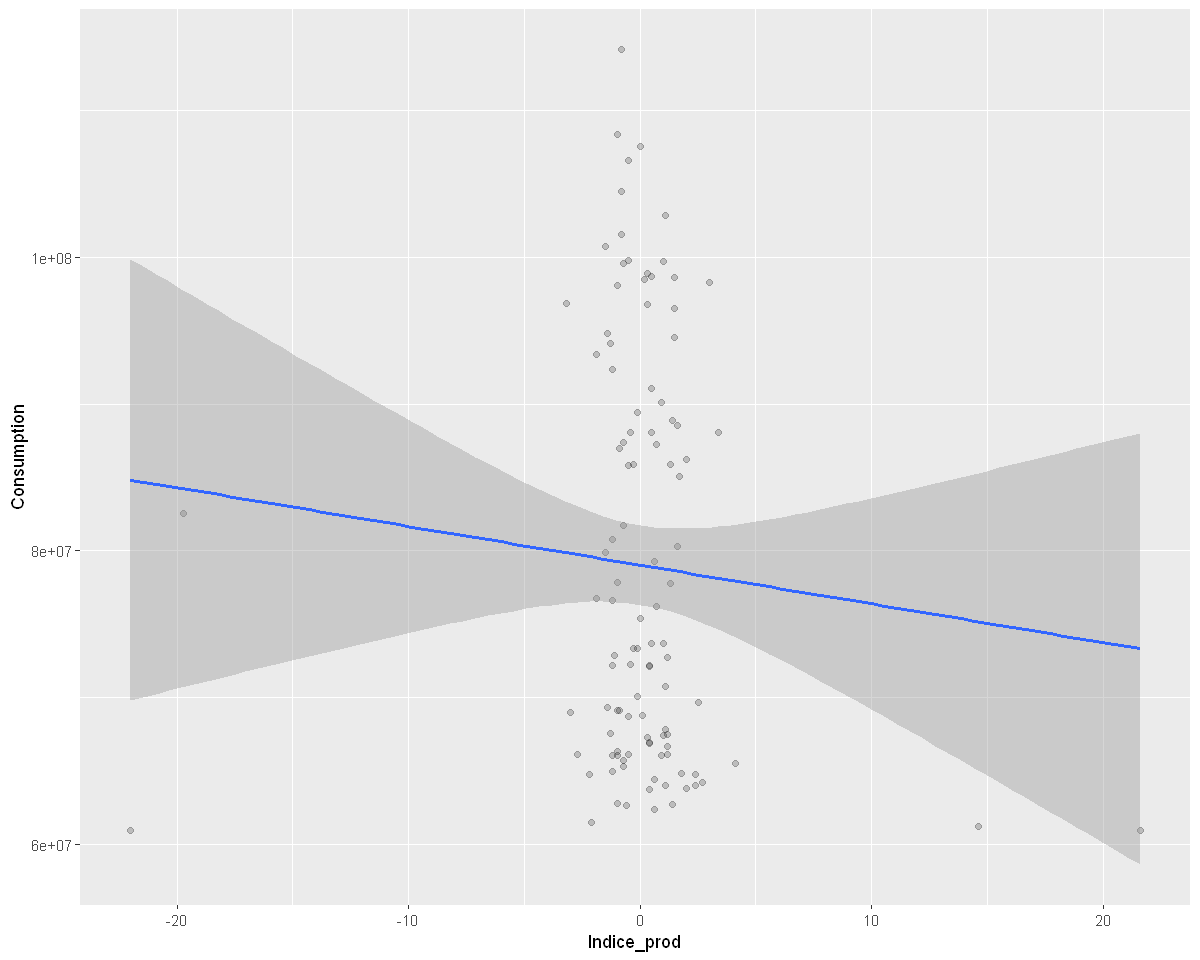

In [104]:
#Corrélogramme Indice de Production Industrielle - Consommation électrique
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data_train_0_month_mean, aes(x = Indice_prod, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")

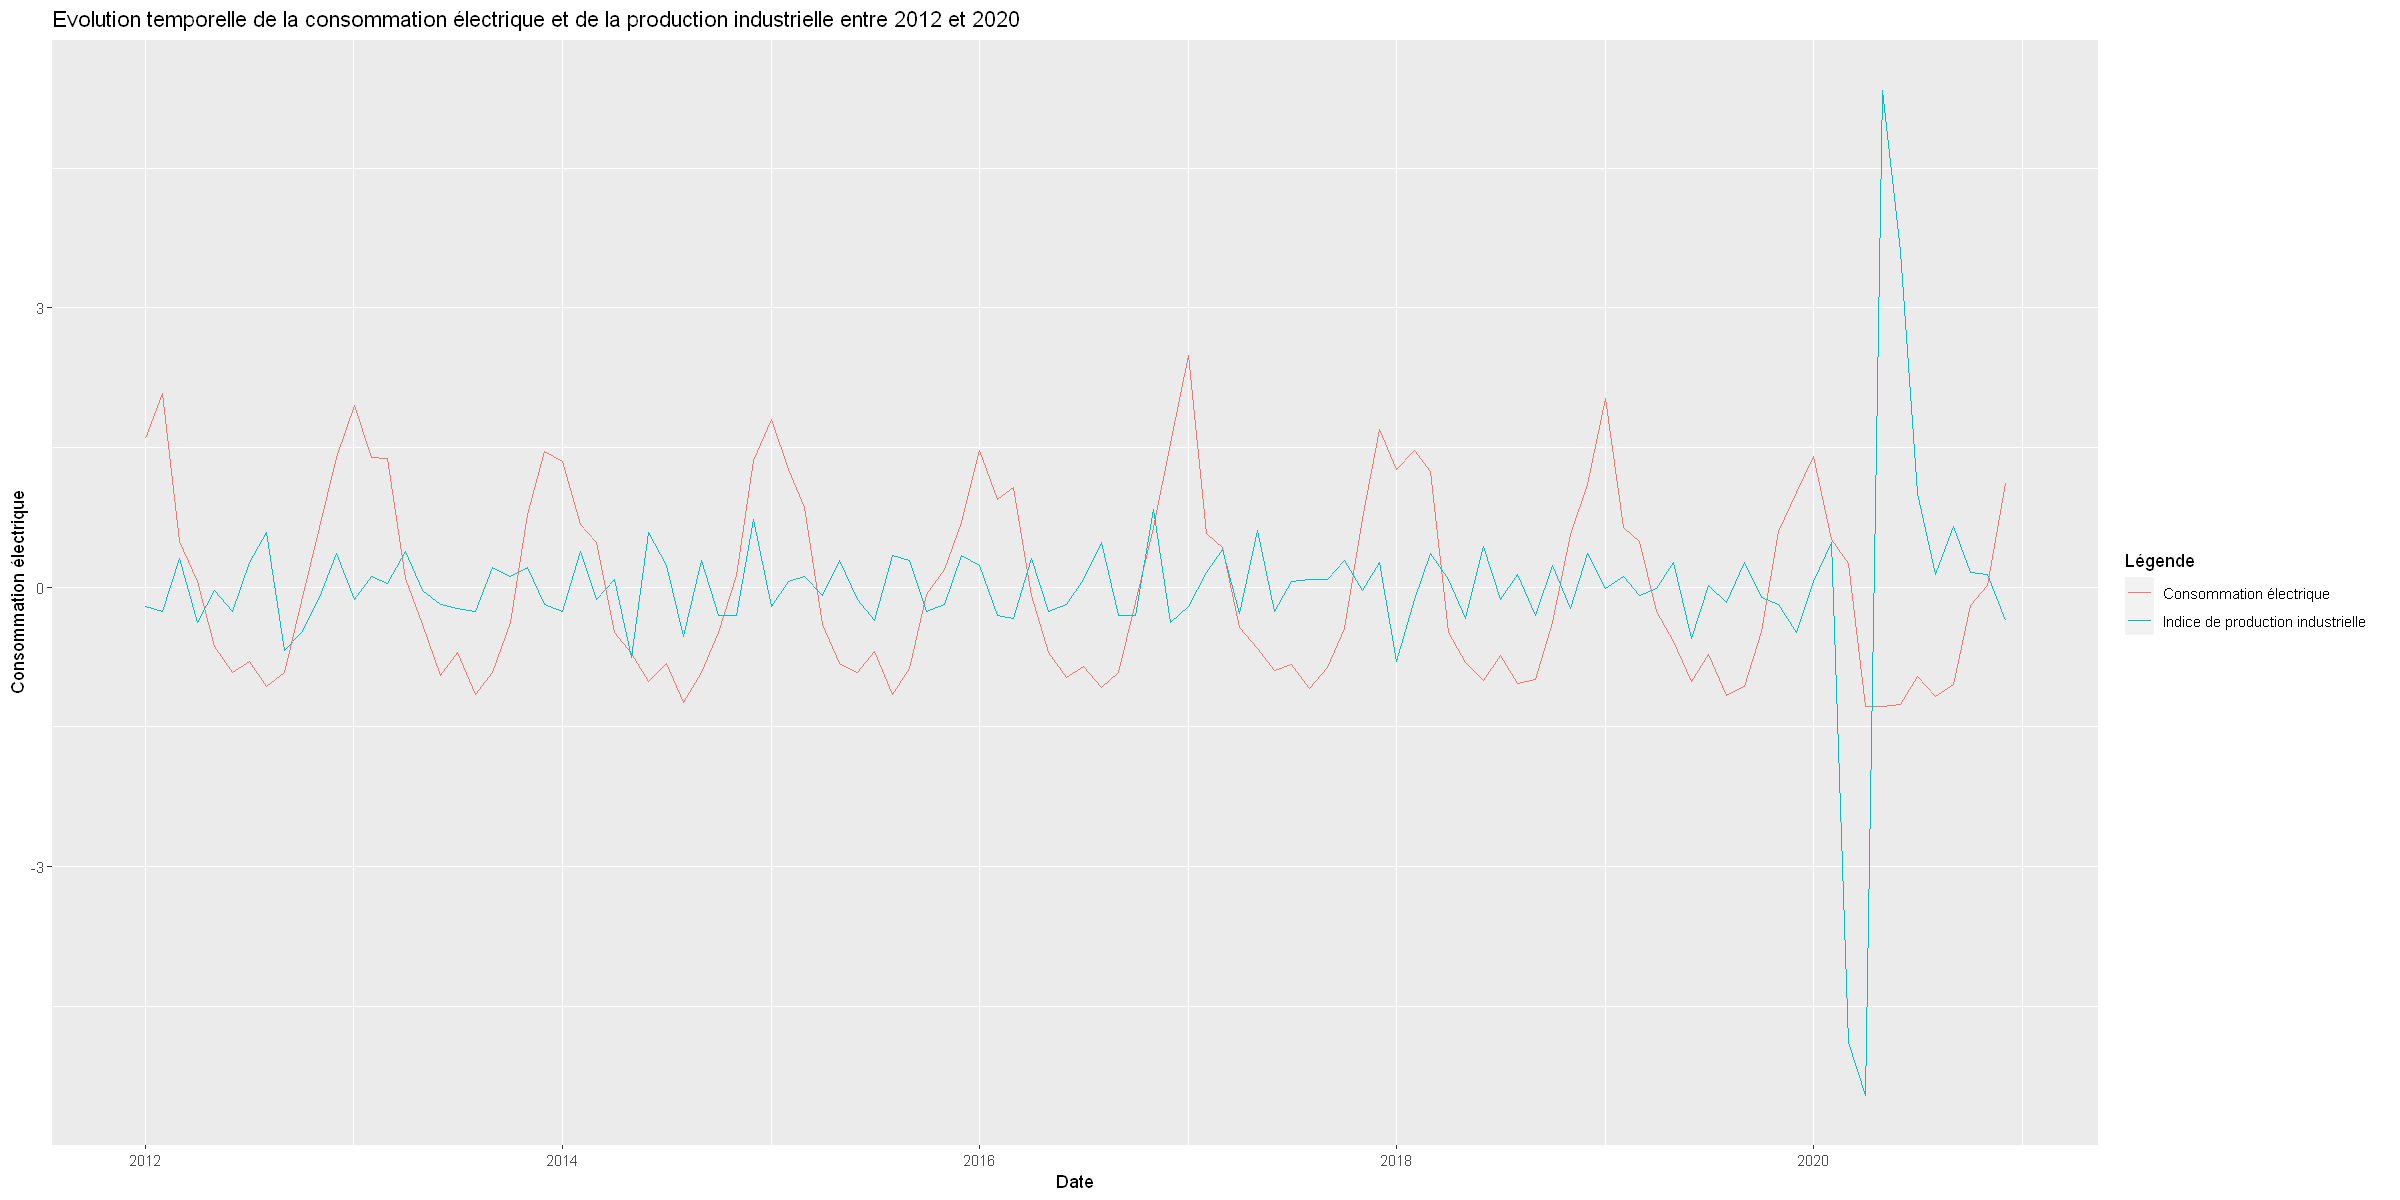

In [105]:
#Représentations graphiques de l'évolution temporelle de la consommmation électrique et de la production industrielle
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_0_month_mean, aes(x=Date, y=Consumption_normalized, group = 1, color = 'Consommation électrique')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Indice_prod_normalized, colour = 'Indice de production industrielle')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle de la consommation électrique et de la production industrielle entre 2012 et 2020") +
    ylab("Consommation électrique")

Nous n'observons pas de corrélation particulière entre la consommation électrique et la variation de la production industrielle. L'activité économique ne parait donc pas avoir d'effet sur la consommation électrique.

###### Etude des événements exceptionnels

Par exemple, étudions l'incidence du covid sur l'année 2020, par rapport aux années antérieures

In [106]:
#Création d'une année type avec données entre 2012 et 2019
data_train_no2020 <- subset(data_train_0, Year!=2020)
data_train_no2020 <- data_train_no2020 %>% group_by(Day,Month) %>%  summarise_at(vars("Consumption"), mean)
data_train_no2020 = rename(data_train_no2020, Consumption_no2020 = Consumption)

#Base de données 2020
data_train_2020 <- subset(data_train_0, Year==2020)
data_train_2020 <- data_train_2020 %>% group_by(Day,Month) %>%  summarise_at(vars("Consumption"), mean)
data_train_2020 = rename(data_train_2020, Consumption_2020 = Consumption)

#Fusion des 2 bases pour réaliser le graphique
data_train_ev_ex <- left_join(data_train_no2020,data_train_2020, by=c("Day","Month"))

data_train_ev_ex$Date = paste(data_train_ev_ex$Month, data_train_ev_ex$Day, sep="-")
data_train_ev_ex$Date = as.Date(data_train_ev_ex$Date, format = "%m-%d")
data_train_ev_ex <- data_train_ev_ex %>% select(Date, everything())
data_train_ev_ex <- data_train_ev_ex %>% drop_na()

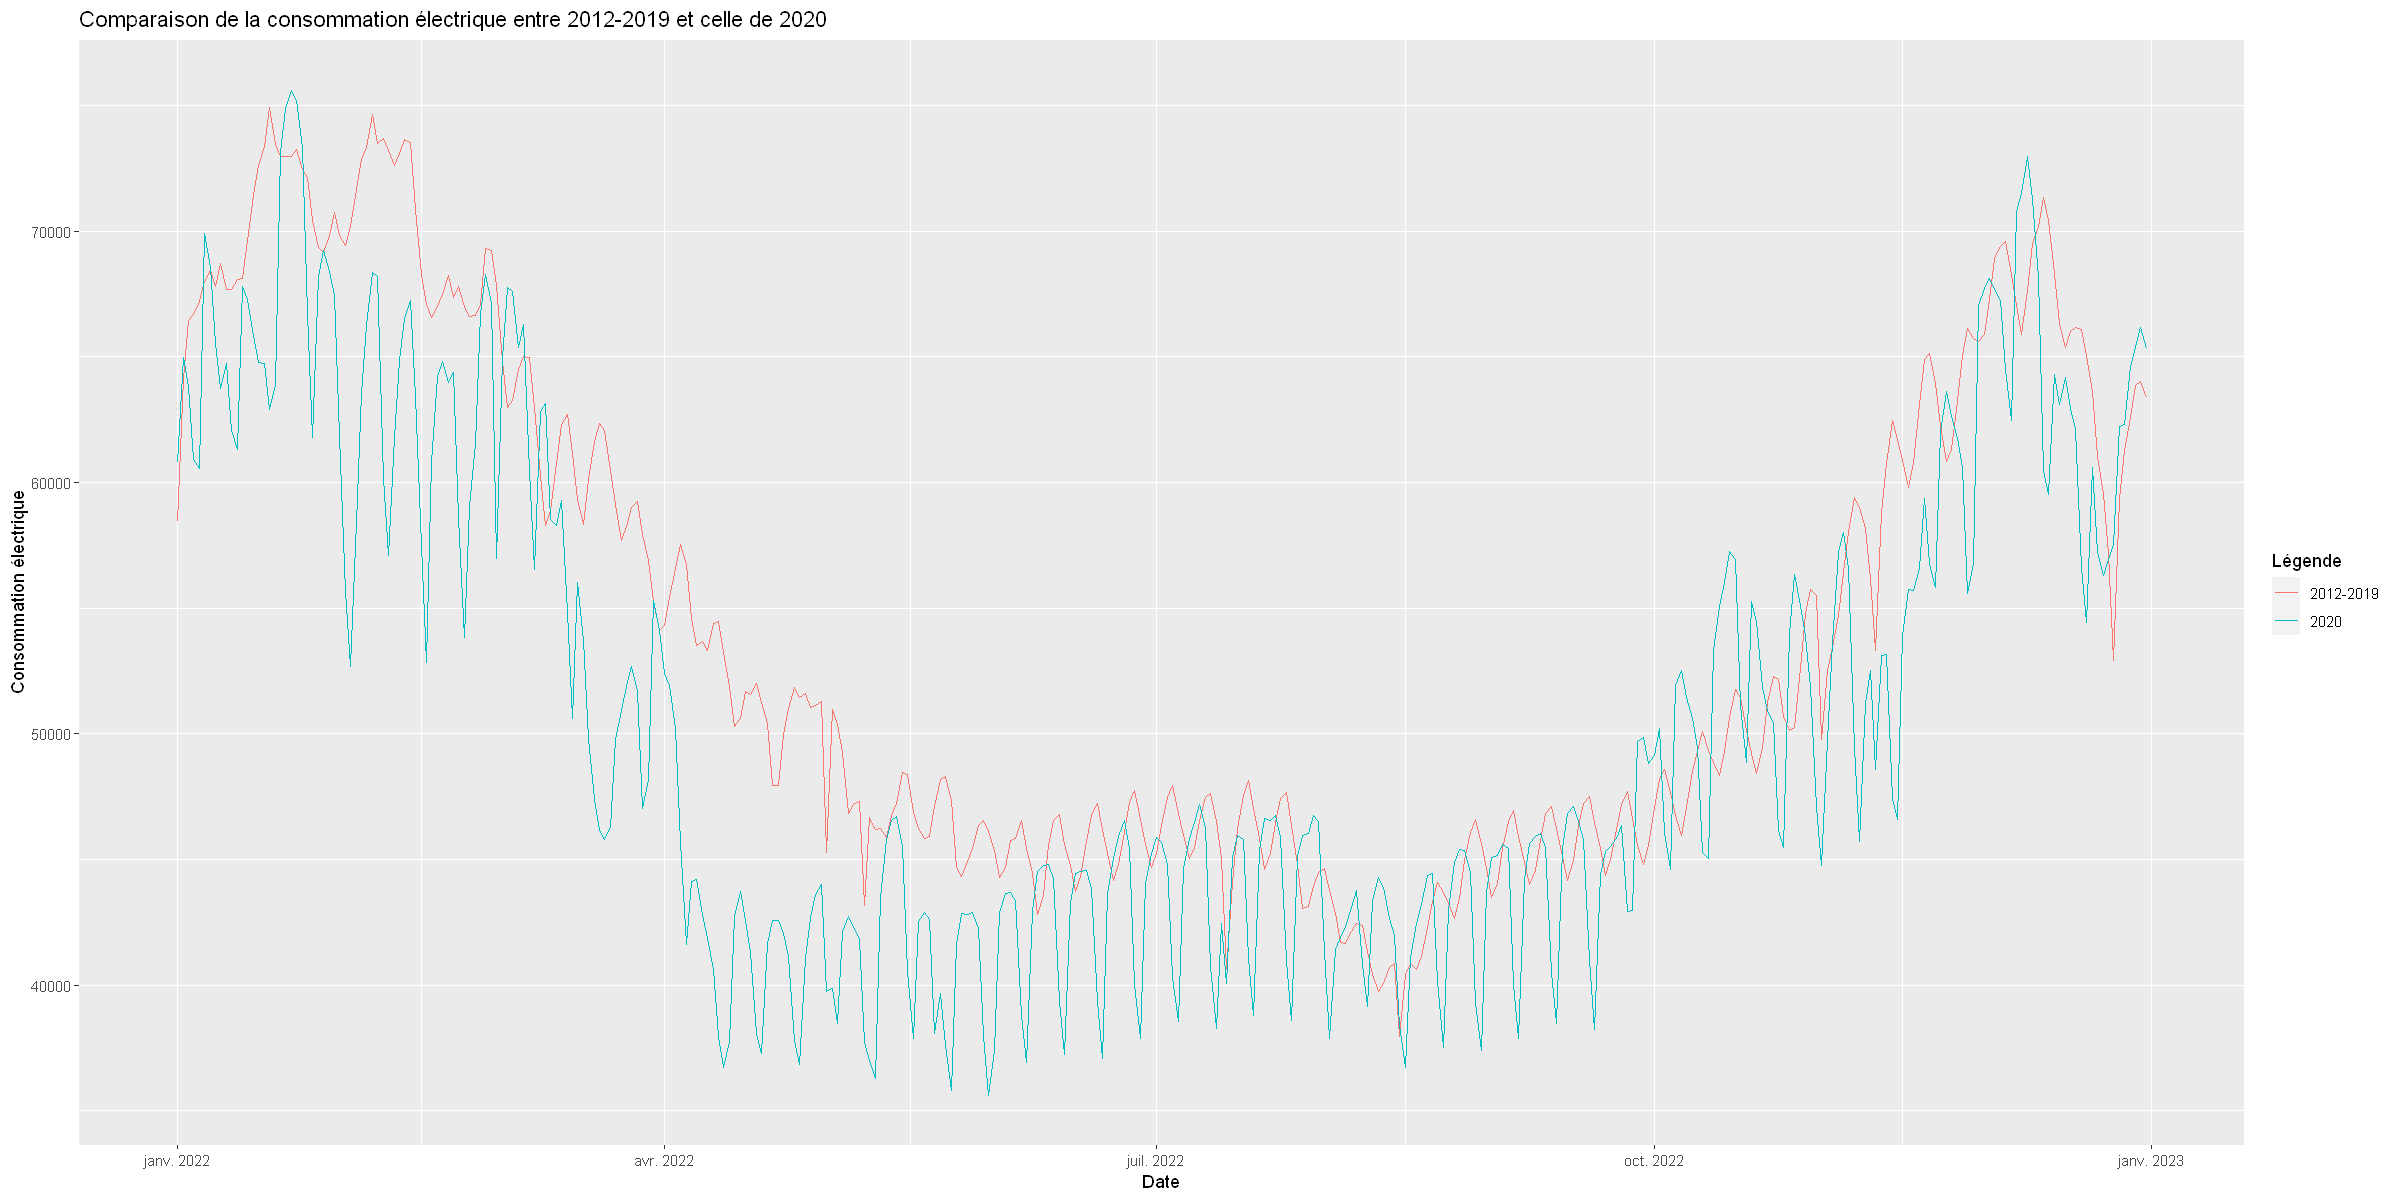

In [107]:
#Représentation graphique de la consommmation électrique en 2020 vs la consommation électrique moyenne des autres années (2012-2019)
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_ev_ex, aes(x=Date, y=Consumption_no2020, group = 1, color = '2012-2019')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_2020, colour = '2020')) +
    labs(colour = "Légende") +
    labs(title = "Comparaison de la consommation électrique entre 2012-2019 et celle de 2020") +
    ylab("Consommation électrique")

On remarque nettement une forte diminution de la consommation électrique en 2020 par rapport à la moyenne 2012-2019 à partir de mars 2020 et puis un "retour à la normal" à partir de juin-juillet 2020.

##### Conclusion de la partie Analyse Descriptive

A la suite de nos études, les variables explicatives suivantes semblent avoir un effet sur la consommation électriques:
* données météorologiques: Température, Température lissée, Nébulosité, Humidité
* donnée temporelles: Date (traduisant une position dans l'année), instant de la journée, jours ouvrés, jours fériés, vacances 

Nous retenons donc ces variables pour la modélisation.\
Nous ne retenons pas les variables de la variation de l'activité économique et de la température retardée car celles-ci n'ont pas démontré d'effets sur la consommation électrique.

### Modélisation

Afin de construire un modèle de prévision pour la consommation électrique, nous allons développer un modèle additif généralisé permettant de traduire des effets non linéaires des variables explicatives sur la variable à expliquer.

Avant de construire le modèle, nous transformons les données.

In [23]:
#Année, Mois et Jour sous format numérique
data_train$Year <- as.integer(data_train$Year)
data_train$Month <- as.integer(data_train$Month)
data_train$Day <- as.integer(data_train$Day)

data_test$Year <- as.integer(data_test$Year)
data_test$Month <- as.integer(data_test$Month)
data_test$Day <- as.integer(data_test$Day)

data_train_1$Year <- as.integer(data_train_1$Year)
data_train_1$Month <- as.integer(data_train_1$Month)
data_train_1$Day <- as.integer(data_train_1$Day)

data_test_1$Year <- as.integer(data_test_1$Year)
data_test_1$Month <- as.integer(data_test_1$Month)
data_test_1$Day <- as.integer(data_test_1$Day)

Afin de traduire les effets de saisonnalité annuelle, mensuelle et hebdomadaire de la consommation électrique, nous créons une variable 'Position_year', valant 0 au 1er janvier de l'année et 1 le 31 décembre.

In [24]:
jours_année <- data.table(data_train_1)[ , .(jours = length(unique(Date))), by = Year]
jours_mois <- data.table(data_train_1)[ , .(jours = length(unique(Day))), by = Month]
for (i in 2012:2020){
    l=0
    nb_jours_annee = jours_année$jours[jours_année$Year==i]
    for (j in 1:12){
        nb_jours_mois = jours_mois$jours[jours_mois$Month==j]
        for (k in 1:nb_jours_mois){
            data_train_1$Position_year[data_train_1$Year==i & data_train_1$Month==j & data_train_1$Day==k] <- l
            l=l+(1/nb_jours_annee)
        }
    }
}

jours_année <- data.table(data_train)[ , .(jours = length(unique(Date))), by = Year]
jours_mois <- data.table(data_train)[ , .(jours = length(unique(Day))), by = Month]
for (i in 2012:2020){
    l=0
    nb_jours_annee = jours_année$jours[jours_année$Year==i]
    for (j in 1:12){
        nb_jours_mois = jours_mois$jours[jours_mois$Month==j]
        for (k in 1:nb_jours_mois){
            data_train$Position_year[data_train$Year==i & data_train$Month==j & data_train$Day==k] <- l
            l=l+(1/nb_jours_annee)
        }
    }
}

In [25]:
jours_année <- data.table(data_test)[ , .(jours = length(unique(Date))), by = Year]
jours_mois <- data.table(data_test)[ , .(jours = length(unique(Day))), by = Month]
for (i in 2021:2021){
    l=0
    nb_jours_annee = jours_année$jours[jours_année$Year==i]
    for (j in 1:12){
        nb_jours_mois = jours_mois$jours[jours_mois$Month==j]
        for (k in 1:nb_jours_mois){
            data_test$Position_year[data_test$Year==i & data_test$Month==j & data_test$Day==k] <- l
            l=l+(1/nb_jours_annee)
        }
    }
}

jours_année <- data.table(data_test_1)[ , .(jours = length(unique(Date))), by = Year]
jours_mois <- data.table(data_test_1)[ , .(jours = length(unique(Day))), by = Month]
for (i in 2021:2021){
    l=0
    nb_jours_annee = jours_année$jours[jours_année$Year==i]
    for (j in 1:12){
        nb_jours_mois = jours_mois$jours[jours_mois$Month==j]
        for (k in 1:nb_jours_mois){
            data_test_1$Position_year[data_test_1$Year==i & data_test_1$Month==j & data_test_1$Day==k] <- l
            l=l+(1/nb_jours_annee)
        }
    }
}

Pour rendre compte de la saisonnalité hebdomadaire, nous créons une variable Day_number comme dans la partie Analyse Descriptive.

In [26]:
#Création d'une variable Day_number comme dans la partie Analyse Descriptive
data_train <- data_train %>%
  mutate(Day_number = case_when(
    data_train$Weekday == "lundi" ~ 1,
    data_train$Weekday == "mardi" ~ 2,
    data_train$Weekday == "mercredi" ~ 3,
    data_train$Weekday == "jeudi" ~ 4,
    data_train$Weekday == "vendredi" ~ 5,
    data_train$Weekday == "samedi" ~ 6,
    data_train$Weekday == "dimanche" ~ 7,
    ))
data_test <- data_test %>%
  mutate(Day_number = case_when(
    data_test$Weekday == "lundi" ~ 1,
    data_test$Weekday == "mardi" ~ 2,
    data_test$Weekday == "mercredi" ~ 3,
    data_test$Weekday == "jeudi" ~ 4,
    data_test$Weekday == "vendredi" ~ 5,
    data_test$Weekday == "samedi" ~ 6,
    data_test$Weekday == "dimanche" ~ 7,
    ))

data_train_1 <- data_train_1 %>%
  mutate(Day_number = case_when(
    data_train_1$Weekday == "lundi" ~ 1,
    data_train_1$Weekday == "mardi" ~ 2,
    data_train_1$Weekday == "mercredi" ~ 3,
    data_train_1$Weekday == "jeudi" ~ 4,
    data_train_1$Weekday == "vendredi" ~ 5,
    data_train_1$Weekday == "samedi" ~ 6,
    data_train_1$Weekday == "dimanche" ~ 7,
    ))
data_test_1 <- data_test_1 %>%
  mutate(Day_number = case_when(
    data_test_1$Weekday == "lundi" ~ 1,
    data_test_1$Weekday == "mardi" ~ 2,
    data_test_1$Weekday == "mercredi" ~ 3,
    data_test_1$Weekday == "jeudi" ~ 4,
    data_test_1$Weekday == "vendredi" ~ 5,
    data_test_1$Weekday == "samedi" ~ 6,
    data_test_1$Weekday == "dimanche" ~ 7,
    ))

#Variable Day_number sous format numérique
data_train$Day_number <- as.integer(data_train$Day_number)
data_test$Day_number <- as.integer(data_test$Day_number)
data_train_1$Day_number <- as.integer(data_train_1$Day_number)
data_test_1$Day_number <- as.integer(data_test_1$Day_number)

Pour rendre compte de la saisonnalité journalière, nous créons une variable Time_number, valant 0 à 00:00, 2 à 00:30,..., 48 à 23:30.

In [27]:
time <- unique(data_train['Time'])
for (i in 1:48){
    time$Time_number[i] <- i
}

data_train = left_join(data_train,time)
data_test = left_join(data_test,time)
data_train_1 = left_join(data_train_1,time)
data_test_1 = left_join(data_test_1,time)

Joining, by = "Time"
Joining, by = "Time"
Joining, by = "Time"
Joining, by = "Time"


In [28]:
#Création d'une variable binaire jour férié
data_train <- data_train %>%
  mutate(jour_ferie = case_when(
    data_train$jour_ferie == 0 ~ 0,
    data_train$jour_ferie != 0 ~ 1,
    ))

data_test <- data_test %>%
  mutate(jour_ferie = case_when(
    data_test$jour_ferie == 0 ~ 0,
    data_test$jour_ferie != 0 ~ 1,
    ))

data_train_1 <- data_train_1 %>%
  mutate(jour_ferie = case_when(
    data_train_1$jour_ferie == 0 ~ 0,
    data_train_1$jour_ferie != 0 ~ 1,
    ))

data_test_1 <- data_test_1 %>%
  mutate(jour_ferie = case_when(
    data_test_1$jour_ferie == 0 ~ 0,
    data_test_1$jour_ferie != 0 ~ 1,
    ))

In [29]:
#Création d'une variable Jour Ouvré
data_train <- data_train %>%
  mutate(Jour_ouvre = case_when(
    data_train$Holidays == 1 ~ 0,
    data_train$jour_ferie != 0 ~ 0,
    data_train$Weekday == "lundi" ~ 1,
    data_train$Weekday == "mardi" ~ 1,
    data_train$Weekday == "mercredi" ~ 1,
    data_train$Weekday == "jeudi" ~ 1,
    data_train$Weekday == "vendredi" ~ 1,
    data_train$Weekday == "samedi" ~ 0,
    data_train$Weekday == "dimanche" ~ 0,
    ))

data_test <- data_test %>%
  mutate(Jour_ouvre = case_when(
    data_test$Holidays == 1 ~ 0,
    data_test$jour_ferie != 0 ~ 0,
    data_test$Weekday == "lundi" ~ 1,
    data_test$Weekday == "mardi" ~ 1,
    data_test$Weekday == "mercredi" ~ 1,
    data_test$Weekday == "jeudi" ~ 1,
    data_test$Weekday == "vendredi" ~ 1,
    data_test$Weekday == "samedi" ~ 0,
    data_test$Weekday == "dimanche" ~ 0,
    ))

data_train_1 <- data_train_1 %>%
  mutate(Jour_ouvre = case_when(
    data_train_1$Holidays == 1 ~ 0,
    data_train_1$jour_ferie != 0 ~ 0,
    data_train_1$Weekday == "lundi" ~ 1,
    data_train_1$Weekday == "mardi" ~ 1,
    data_train_1$Weekday == "mercredi" ~ 1,
    data_train_1$Weekday == "jeudi" ~ 1,
    data_train_1$Weekday == "vendredi" ~ 1,
    data_train_1$Weekday == "samedi" ~ 0,
    data_train_1$Weekday == "dimanche" ~ 0,
    ))

data_test_1 <- data_test_1 %>%
  mutate(Jour_ouvre = case_when(
    data_test_1$Holidays == 1 ~ 0,
    data_test_1$jour_ferie != 0 ~ 0,
    data_test_1$Weekday == "lundi" ~ 1,
    data_test_1$Weekday == "mardi" ~ 1,
    data_test_1$Weekday == "mercredi" ~ 1,
    data_test_1$Weekday == "jeudi" ~ 1,
    data_test_1$Weekday == "vendredi" ~ 1,
    data_test_1$Weekday == "samedi" ~ 0,
    data_test_1$Weekday == "dimanche" ~ 0,
    ))

Comme nous souhaitons avoir une prévision au pas de demi-horaire, nous effectuons une interpolation linéaire afin de disposer des données de Température, Humidité et Nébulosité tous les demi-horaires.

In [30]:
data_train <- data_train %>%
        mutate(Temperature = as.double(na.approx(data_train$Temperature, na.rm=FALSE)))

data_train <- data_train %>%
        mutate(Nebulosity = as.double(na.approx(data_train$Nebulosity, na.rm=FALSE)))

data_train <- data_train %>%
        mutate(Humidity = as.double(na.approx(data_train$Humidity, na.rm=FALSE)))

data_test <- data_test %>%
        mutate(Temperature = as.double(na.approx(data_test$Temperature, na.rm=FALSE)))

data_test <- data_test %>%
        mutate(Nebulosity = as.double(na.approx(data_test$Nebulosity, na.rm=FALSE)))

data_test <- data_test %>%
        mutate(Humidity = as.double(na.approx(data_test$Humidity, na.rm=FALSE)))

In [31]:
#Suppression des 4 dernières lignes qui comportent des données NA
data_train <- data_train %>% drop_na()
data_test <- data_test %>% drop_na()

In [32]:
#Création de la variable Température lissée comme dans la partie Données
alpha = 0.1

n = nrow(data_train)
for (i in 1:24){
data_train$Temperature_lissee[i] <- data_train$Temperature[i]
}
for (i in 25:n) {
     data_train$Temperature_lissee[i] <- alpha*data_train$Temperature[i]+(1-alpha)*data_train$Temperature_lissee[i-4]
}

n = nrow(data_test)
for (i in 1:24){
data_test$Temperature_lissee[i] <- data_test$Temperature[i]
}
for (i in 25:n) {
     data_test$Temperature_lissee[i] <- alpha*data_test$Temperature[i]+(1-alpha)*data_test$Temperature_lissee[i-4]
}

Notre objectif est de prévoir la consommation électrique tous les demi-horaires.
Pour cela, nous allons étudier les 3 modèles suivants:
* modèle GAM classique et comparaison avec un modèle linéaire
* modèles GAM affinés
* modèle GAM par instant

Puis nous comparerons ces modèles selon leur erreur MAPE et à travers un protocole de validation.

##### Modèle GAM

Nous construisons dans un premier temps un modèle de régression linéaire classique, auquel nous comparerons le modèle GAM.

In [33]:
mod_lm <- lm(Consumption ~ Temperature + Humidity + Nebulosity + Position_year + Day_number + Time_number + jour_ferie + Holidays, data=data_train_1)
summary(mod_lm)


Call:
lm(formula = Consumption ~ Temperature + Humidity + Nebulosity + 
    Position_year + Day_number + Time_number + jour_ferie + Holidays, 
    data = data_train_1)

Residuals:
     Min       1Q   Median       3Q      Max 
-26521.4  -5401.5     36.7   5398.3  25890.5 

Coefficients:
                Estimate Std. Error  t value Pr(>|t|)    
(Intercept)   122240.243    692.188  176.600  < 2e-16 ***
Temperature    -2164.005     13.638 -158.670  < 2e-16 ***
Humidity        -574.749      7.598  -75.644  < 2e-16 ***
Nebulosity       116.956      3.228   36.229  < 2e-16 ***
Position_year    262.653    176.719    1.486    0.137    
Day_number     -1092.406     23.771  -45.955  < 2e-16 ***
Time_number      146.293      3.944   37.089  < 2e-16 ***
jour_ferie     -7825.468    278.649  -28.084  < 2e-16 ***
Holidays        -776.210     99.498   -7.801 6.35e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7678 on 26277 degrees of freedom
Multip

Nous remarquons que toutes les variables explicativessont significatives au seuil de 1%, à l'exception de la variable Position_year. Cela peut s'expliquer par l'effet non linéaire de cette variable.

Nous construire un modèle GAM en attribuant un effet:
* linéaire (as.factor) aux variables Day_number, Time_number, jour_ferie et Holidays qui ont un nombre fini de valeurs, et dont l'effet linéaire est significatif d'après ce qui précède
* non linéaire pour les variables Température, Température lissée, Nébulosité, Humidité et Position_year

Pour commencer, nous attribuons un nombre de noeuds par défaut égale à 12 pour chaque spline.

In [34]:
mod_gam <- gam(Consumption ~ s(Temperature, bs="cr", k=6) + 
                              s(Temperature_lissee, bs="cr", k=6) +
                              s(Humidity, bs="cr", k=6) + 
                              s(Nebulosity, bs="cr", k=6) + 
                              s(Position_year, bs="cc",k=6) + 
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=data_train)

Nous effectuons un protocole de validation du nombre de noeuds des splines en regardant la distribution des résidus du modèle.


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 14 iterations.
The RMS GCV score gradient at convergence was 0.5196262 .
The Hessian was positive definite.
Model rank =  80 / 80 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                        k'  edf k-index p-value    
s(Temperature)        5.00 4.87    1.01    0.72    
s(Temperature_lissee) 5.00 4.99    0.96  <2e-16 ***
s(Humidity)           5.00 4.92    1.02    0.86    
s(Nebulosity)         5.00 4.93    0.99    0.14    
s(Position_year)      4.00 4.00    0.78  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature, k = 40)

Estimated degrees of freedom:
35.8  total = 36.75 

GCV score: 10264851     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature_lissee, k = 40)

Estimated degrees of freedom:
35  total = 36.01 

GCV score: 10234833     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Humidity, k = 40)

Estimated degrees of freedom:
11.6  total = 12.64 

GCV score: 10281418     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Nebulosity, k = 40)

Estimated degrees of freedom:
22.7  total = 23.7 

GCV score: 10275122     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Position_year, k = 40)

Estimated degrees of freedom:
38.7  total = 39.65 

GCV score: 8551419     

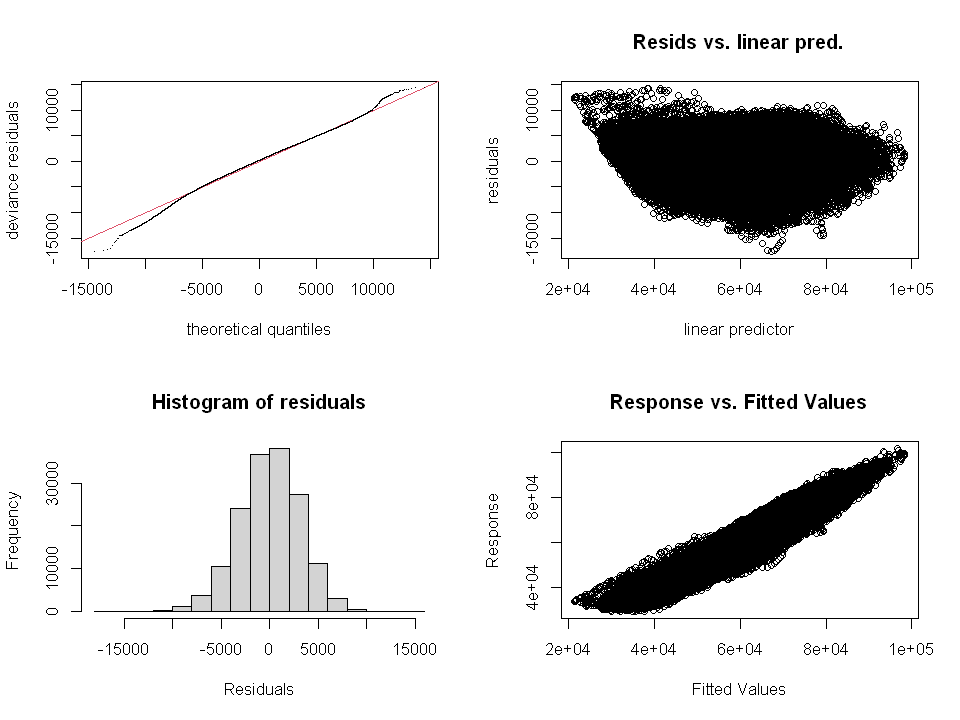

In [182]:
gam.check(mod_gam)
gam(residuals(mod_gam)~s(Temperature,k=40),gamma=1.4,data=data_train) ## k trop petit
gam(residuals(mod_gam)~s(Temperature_lissee,k=40),gamma=1.4,data=data_train) ## k trop petit
gam(residuals(mod_gam)~s(Humidity,k=40),gamma=1.4,data=data_train) ## k trop petit
gam(residuals(mod_gam)~s(Nebulosity,k=40),gamma=1.4,data=data_train) ## k trop petit
gam(residuals(mod_gam)~s(Position_year,k=40),gamma=1.4,data=data_train) ## k trop petit

In [184]:
#Nous augmentons le nombre de noeuds pour chaque variable
mod_gam <- gam(Consumption ~ s(Temperature, bs="cr", k=12) + 
                              s(Temperature_lissee, bs="cr", k=12) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=12) + 
                              s(Position_year, bs="cc",k=12) + 
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=data_train)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 13 iterations.
The RMS GCV score gradient at convergence was 1.791572 .
The Hessian was positive definite.
Model rank =  110 / 110 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                         k'   edf k-index p-value    
s(Temperature)        11.00 10.71    1.01    0.64    
s(Temperature_lissee) 11.00 10.90    0.98    0.11    
s(Humidity)           11.00  9.84    1.00    0.54    
s(Nebulosity)         11.00 10.58    0.99    0.34    
s(Position_year)      10.00 10.00    0.85  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature, k = 40)

Estimated degrees of freedom:
34.1  total = 35.15 

GCV score: 9118538     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature_lissee, k = 40)

Estimated degrees of freedom:
33.5  total = 34.52 

GCV score: 9110942     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Humidity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 9126831     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Nebulosity, k = 40)

Estimated degrees of freedom:
30.6  total = 31.55 

GCV score: 9124632     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Position_year, k = 40)

Estimated degrees of freedom:
38.7  total = 39.67 

GCV score: 8457252     

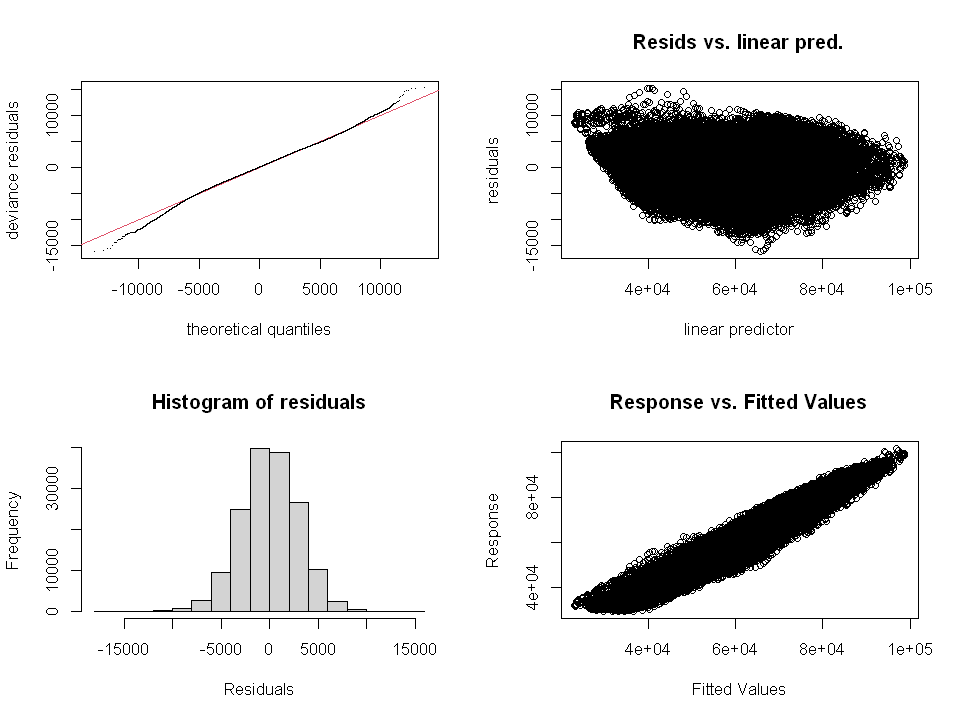

In [185]:
gam.check(mod_gam)
gam(residuals(mod_gam)~s(Temperature,k=40),gamma=1.4,data=data_train) # k trop petit
gam(residuals(mod_gam)~s(Temperature_lissee,k=40),gamma=1.4,data=data_train) # k trop petit
gam(residuals(mod_gam)~s(Humidity,k=40),gamma=1.4,data=data_train) # ok
gam(residuals(mod_gam)~s(Nebulosity,k=40),gamma=1.4,data=data_train) # k trop petit
gam(residuals(mod_gam)~s(Position_year,k=40),gamma=1.4,data=data_train) # k trop petit

In [186]:
#Nous augmentons le nombre de noeuds pour chaque variable sauf Humidity
mod_gam <- gam(Consumption ~ s(Temperature, bs="cr", k=24) + 
                              s(Temperature_lissee, bs="cr", k=24) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=24) + 
                              s(Position_year, bs="cc",k=24) + 
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=data_train)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 11 iterations.
The RMS GCV score gradient at convergence was 1.818431 .
The Hessian was positive definite.
Model rank =  158 / 158 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                         k'   edf k-index p-value    
s(Temperature)        23.00 21.54    1.01    0.72    
s(Temperature_lissee) 23.00 22.68    1.00    0.60    
s(Humidity)           11.00  9.56    1.01    0.69    
s(Nebulosity)         23.00 18.97    1.00    0.57    
s(Position_year)      22.00 21.98    0.91  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature, k = 40)

Estimated degrees of freedom:
32.6  total = 33.61 

GCV score: 8613255     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature_lissee, k = 40)

Estimated degrees of freedom:
31.7  total = 32.73 

GCV score: 8606465     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Humidity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8614439     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Nebulosity, k = 40)

Estimated degrees of freedom:
13  total = 14.04 

GCV score: 8614605     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Position_year, k = 40)

Estimated degrees of freedom:
38.7  total = 39.66 

GCV score: 8442310     

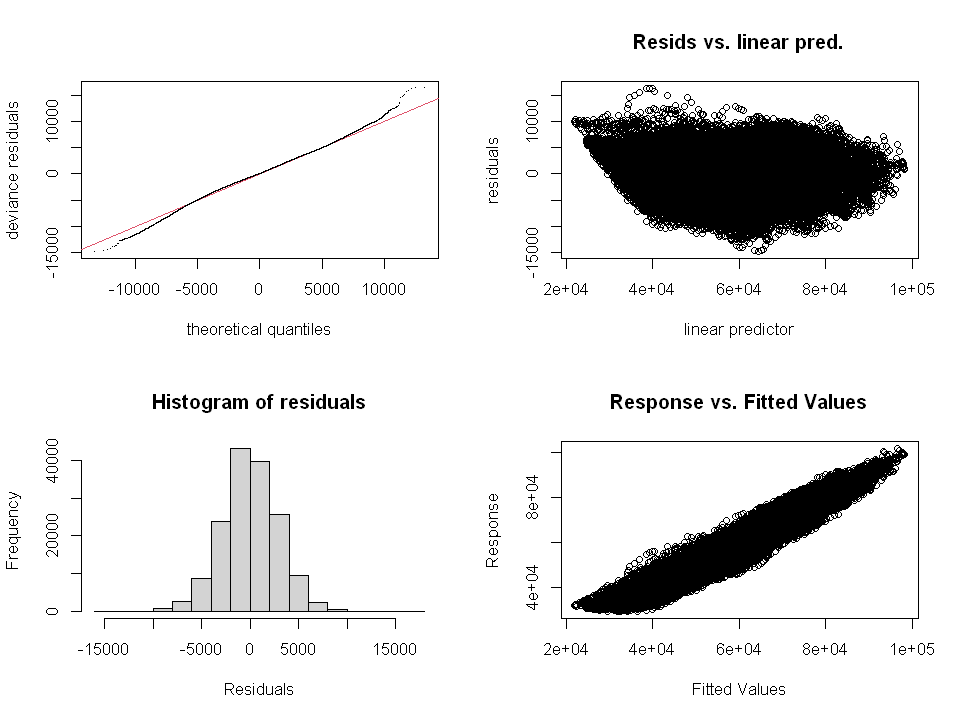

In [187]:
gam.check(mod_gam)
gam(residuals(mod_gam)~s(Temperature,k=40),gamma=1.4,data=data_train) # k trop petit
gam(residuals(mod_gam)~s(Temperature_lissee,k=40),gamma=1.4,data=data_train) # k trop petit
gam(residuals(mod_gam)~s(Humidity,k=40),gamma=1.4,data=data_train) ## ok
gam(residuals(mod_gam)~s(Nebulosity,k=40),gamma=1.4,data=data_train) # k trop petit
gam(residuals(mod_gam)~s(Position_year,k=40),gamma=1.4,data=data_train) # k trop petit

In [188]:
#Nous augmentons le nombre de noeuds pour chaque variable sauf Humidity
mod_gam <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=48) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=48) + 
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=data_train)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 9 iterations.
The RMS GCV score gradient at convergence was 30.92826 .
The Hessian was positive definite.
Model rank =  254 / 254 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                         k'   edf k-index p-value    
s(Temperature)        47.00 30.65    1.03    0.98    
s(Temperature_lissee) 47.00 44.36    1.00    0.43    
s(Humidity)           11.00  9.56    1.01    0.82    
s(Nebulosity)         47.00 33.56    1.01    0.70    
s(Position_year)      46.00 45.79    0.95  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8381935     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature_lissee, k = 40)

Estimated degrees of freedom:
27.5  total = 28.5 

GCV score: 8379585     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Humidity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8381935     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Nebulosity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8381935     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Position_year, k = 40)

Estimated degrees of freedom:
35.8  total = 36.84 

GCV score: 8376294     

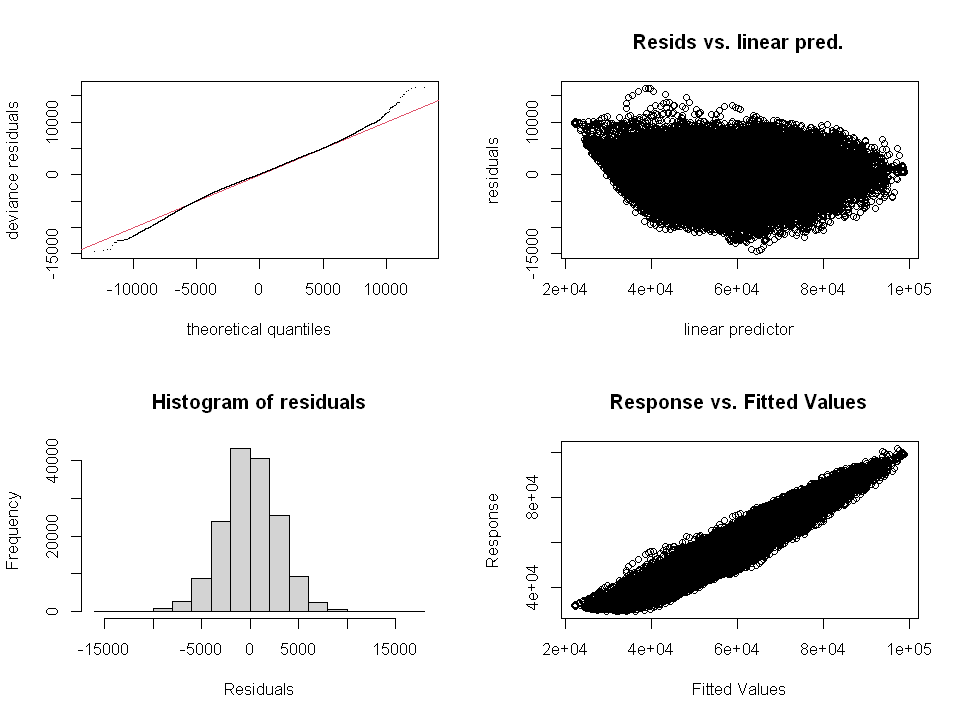

In [189]:
gam.check(mod_gam)
gam(residuals(mod_gam)~s(Temperature,k=40),gamma=1.4,data=data_train) # ok
gam(residuals(mod_gam)~s(Temperature_lissee,k=40),gamma=1.4,data=data_train) # k trop petit
gam(residuals(mod_gam)~s(Humidity,k=40),gamma=1.4,data=data_train) # ok
gam(residuals(mod_gam)~s(Nebulosity,k=40),gamma=1.4,data=data_train) # ok
gam(residuals(mod_gam)~s(Position_year,k=40),gamma=1.4,data=data_train) # k trop petit

In [36]:
#Par itération, nous augmentons le nombre de noeuds pour la spline Position_Year
#Nous trouvons un nombre de noeuds optimal en termes de MAPE égale à 200
mod_gam <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=data_train)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 16 iterations.
The RMS GCV score gradient at convergence was 1.360965 .
The Hessian was positive definite.
Model rank =  414 / 414 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                          k'    edf k-index p-value   
s(Temperature)         47.00  30.66    1.00   0.650   
s(Temperature_lissee)  55.00  48.70    1.01   0.720   
s(Humidity)            11.00   9.14    1.01   0.700   
s(Nebulosity)          47.00  32.72    1.00   0.650   
s(Position_year)      198.00 181.41    0.96   0.005 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8234163     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Temperature_lissee, k = 40)

Estimated degrees of freedom:
26.5  total = 27.46 

GCV score: 8232702     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Humidity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8234163     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Nebulosity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8234163     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam) ~ s(Position_year, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 8234142     

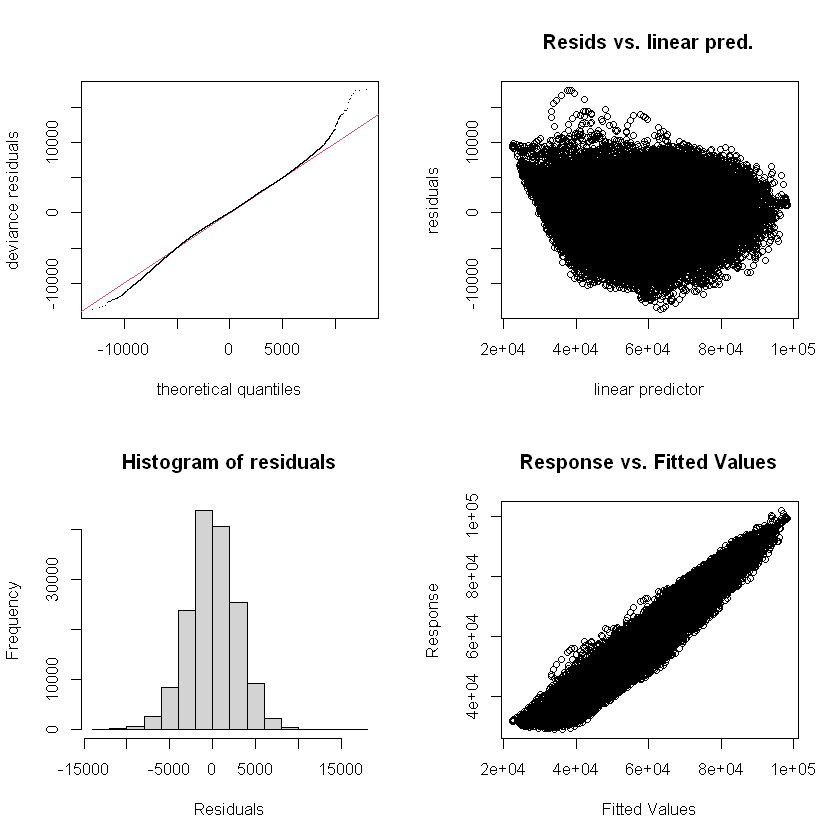

In [37]:
gam.check(mod_gam)
gam(residuals(mod_gam)~s(Temperature,k=40),gamma=1.4,data=data_train) # ok
gam(residuals(mod_gam)~s(Temperature_lissee,k=40),gamma=1.4,data=data_train) # ok
gam(residuals(mod_gam)~s(Humidity,k=40),gamma=1.4,data=data_train) # ok
gam(residuals(mod_gam)~s(Nebulosity,k=40),gamma=1.4,data=data_train) # ok
gam(residuals(mod_gam)~s(Position_year,k=40),gamma=1.4,data=data_train) # ok

Calculons la prédiction du modèle et comparons cette prédiction aux données de référence, afin de calculer l'erreur MAPE.

In [57]:
#Prediction
fits = predict(mod_gam, newdata=data_test, type='response', se=T)
predicts = data.frame(data_test, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)

#Comparaison Prédiction - Benchmark
predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
comparison_mod_gam = left_join(predicts,benchmark,c("Date","Time"))

#Calcul MAPE
MAPE_mod_gam = mean(abs((comparison_mod_gam$Consumption-comparison_mod_gam$fit)/comparison_mod_gam$Consumption)) * 100
MAPE_mod_gam

[1] 4.216624

Comparons cette erreur de prédiction avec l'erreur de prédiction liée au modèle linéaire.

In [58]:
#Prediction
fits = predict(mod_lm, newdata=data_test, type='response', se=T)
predicts = data.frame(data_test, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)

#Comparaison Prédiction - Benchmark
predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
comparison_mod_lm = left_join(predicts,benchmark,c("Date","Time"))

#Calcul MAPE
MAPE_mod_lm = mean(abs((comparison_mod_lm$Consumption-comparison_mod_lm$fit)/comparison_mod_lm$Consumption)) * 100
MAPE_mod_lm

[1] 11.88943

Le modèle additif généralisé a une erreur MAPE de 4,2% tandis que la MAPE du modèle linéaire est de 11,9%. Cela démontre bien que le modèle GAM est plus approprié pour notre objectif de prédire la consommation électrique.

##### Modèles GAM affinés

Essayons d'affiner notre modèle GAM initial. Notre idée est ici d'introduire au sein de la spline liée à la position dans l'année, un effet différencié selon que le jour est ouvré ou non. Nous introduisons donc l'argument "by=Jour_ouvre" au sein de la spline. Comparons ensuite l'erreur MAPE à l'erreur MAPE de 4,2% de notre modèle GAM initial.

In [40]:
mod_gam_2 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200, by=Jour_ouvre) + 
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=data_train)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 10 iterations.
The RMS GCV score gradient at convergence was 10.81271 .
The Hessian was positive definite.
Model rank =  415 / 415 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                                k'    edf k-index p-value    
s(Temperature)               47.00  34.80    1.00   0.410    
s(Temperature_lissee)        55.00  50.23    1.02   0.965    
s(Humidity)                  11.00   9.08    1.01   0.755    
s(Nebulosity)                47.00  26.21    0.98   0.055 .  
s(Position_year):Jour_ouvre 199.00 159.32    0.80  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_2) ~ s(Temperature, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 11128141     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_2) ~ s(Temperature_lissee, k = 40)

Estimated degrees of freedom:
31.6  total = 32.6 

GCV score: 11122940     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_2) ~ s(Humidity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 11128141     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_2) ~ s(Nebulosity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 11128141     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_2) ~ s(Position_year, k = 40)

Estimated degrees of freedom:
38.6  total = 39.6 

GCV score: 9633231     

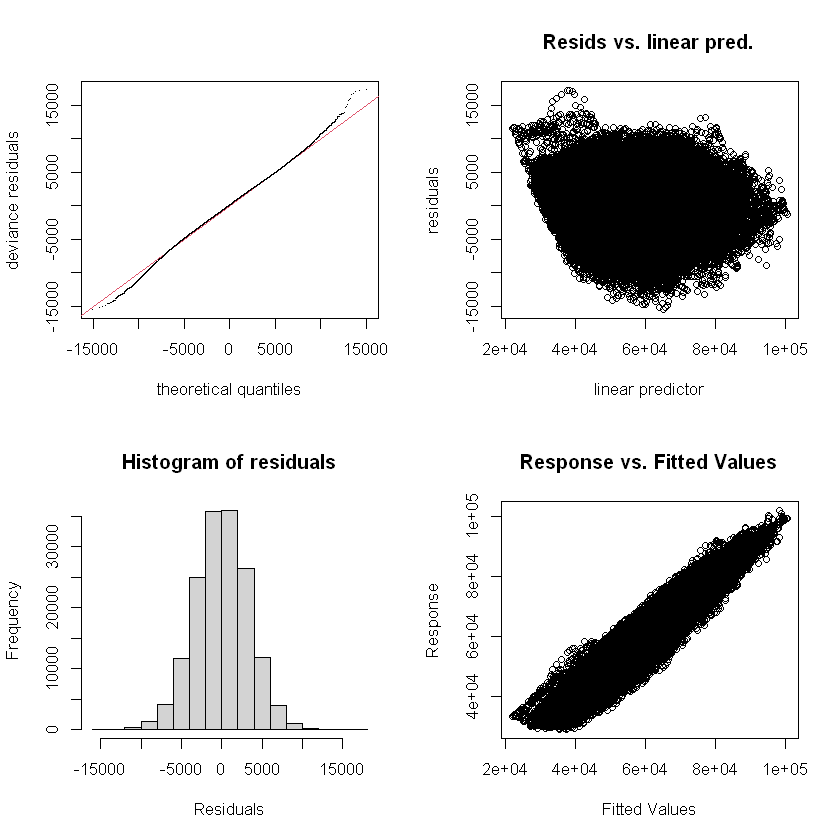

In [157]:
#Vérification du nombre de nombre de noeuds
gam.check(mod_gam_2)
gam(residuals(mod_gam_2)~s(Temperature,k=40),gamma=1.4,data=data_train) # ok
gam(residuals(mod_gam_2)~s(Temperature_lissee,k=40),gamma=1.4,data=data_train) # ok
gam(residuals(mod_gam_2)~s(Humidity,k=40),gamma=1.4,data=data_train) ## ok
gam(residuals(mod_gam_2)~s(Nebulosity,k=40),gamma=1.4,data=data_train) # ok
gam(residuals(mod_gam_2)~s(Position_year,k=40),gamma=1.4,data=data_train) # ok

In [56]:
#Prediction
fits = predict(mod_gam_2, newdata=data_test, type='response', se=T)
predicts = data.frame(data_test, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)

#Comparaison Prédiction - Benchmark
predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
comparison_mod_gam_2 = left_join(predicts,benchmark,c("Date","Time"))

#Calcul MAPE
MAPE_mod_gam_2 = mean(abs((comparison_mod_gam_2$Consumption-comparison_mod_gam_2$fit)/comparison_mod_gam_2$Consumption)) * 100
MAPE_mod_gam_2

[1] 5.249766

Essayons de faire de même en différenciant l'effet non linéaire de la variable Position dans l'année selon le jour de la semaine (variable Day_number) et en introduisant la variable Jour_ouvre en tant que facteur.

In [114]:
mod_gam_3 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=64) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=250, by=Day_number) + 
                              as.factor(Jour_ouvre) +
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=data_train)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 6 iterations.
The RMS GCV score gradient at convergence was 18.26148 .
The Hessian was positive definite.
Model rank =  473 / 474 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                                k'    edf k-index p-value    
s(Temperature)               47.00  31.42    1.00    0.62    
s(Temperature_lissee)        63.00  50.53    1.03    0.96    
s(Humidity)                  11.00   8.61    0.99    0.14    
s(Nebulosity)                47.00  27.52    1.01    0.84    
s(Position_year):Day_number 249.00 236.34    0.91  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_3) ~ s(Temperature, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 9866435     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_3) ~ s(Temperature_lissee, k = 40)

Estimated degrees of freedom:
27.8  total = 28.83 

GCV score: 9861483     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_3) ~ s(Humidity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 9866435     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_3) ~ s(Nebulosity, k = 40)

Estimated degrees of freedom:
1  total = 2 

GCV score: 9866435     


Family: gaussian 
Link function: identity 

Formula:
residuals(mod_gam_3) ~ s(Position_year, k = 40)

Estimated degrees of freedom:
35.5  total = 36.52 

GCV score: 9628673     

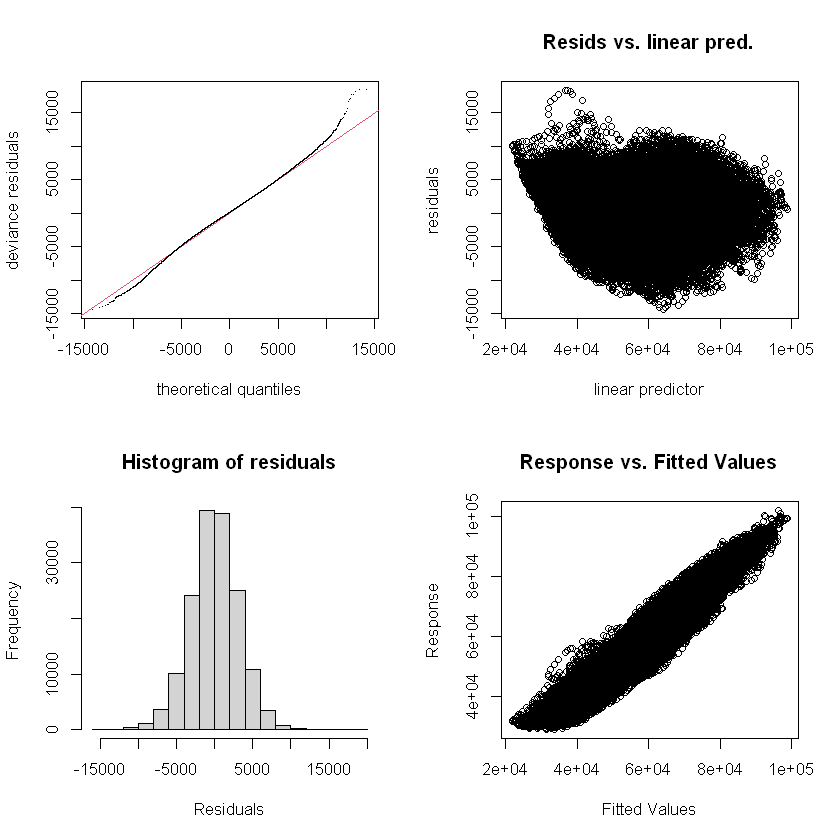

In [44]:
#Vérification du nombre de noeuds
gam.check(mod_gam_3)
gam(residuals(mod_gam_3)~s(Temperature,k=40),gamma=1.4,data=data_train) ## ok
gam(residuals(mod_gam_3)~s(Temperature_lissee,k=40),gamma=1.4,data=data_train) ## augmenter...
gam(residuals(mod_gam_3)~s(Humidity,k=40),gamma=1.4,data=data_train) ## ok
gam(residuals(mod_gam_3)~s(Nebulosity,k=40),gamma=1.4,data=data_train) ## ok
gam(residuals(mod_gam_3)~s(Position_year,k=40),gamma=1.4,data=data_train) ## augmenter ?

In [115]:
#Prediction
fits = predict(mod_gam_3, newdata=data_test, type='response', se=T)
predicts = data.frame(data_test, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)

#Comparaison Prédiction - Benchmark
predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
comparison_mod_gam_3 = left_join(predicts,benchmark,c("Date","Time"))

#Calcul MAPE
MAPE_mod_gam_3 = mean(abs((comparison_mod_gam_3$Consumption-comparison_mod_gam_3$fit)/comparison_mod_gam_3$Consumption)) * 100
MAPE_mod_gam_3

[1] 5.12497

Nous remarquons que nos deux modèles affinés ont une erreur MAPE supérieure à l'erreur MAPE du modèle GAM initial.

##### Modèle par instant

Construisons désormais un modèle par instant. L'objectif est de construire un modèle GAM pour chaque demi-horaire, donc 48 modèles, puis de diviser la base de données de test par demi-horaire et d'apprendre selon le modèle GAM correspondant à ce demi-horaire.

Nous avons choisi comme nombre de noeuds pour les variables de chaque modèle GAM de demi-horaire, les nombre de noeuds choisis pour le modèle GAM initial.

In [77]:
#Création des 48 bases de données d'apprentissage
data_train_split <- split(data_train, data_train$Time_number)
names_data_train <- as.character(paste0("datatrain",unique(data_train$Time_number)))
for (i in 1:length(data_train_split)) {
  assign(names_data_train[i], data_train_split[[i]])
}

In [78]:
#Création des 48 modèles GAM (attention, l'execution de cette commande peut prendre un peu de temps)
mod_gam1 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain1)
mod_gam2 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain2)
mod_gam3 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain3)
mod_gam4 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain4)
mod_gam5 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain5)
mod_gam6 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain6)
mod_gam7 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain7)
mod_gam8 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain8)
mod_gam9 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain9)
mod_gam10 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain10)
mod_gam11 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain11)
mod_gam12 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain12)
mod_gam13 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain13)
mod_gam14 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain14)
mod_gam15 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain15)
mod_gam16 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain16)
mod_gam17 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain17)
mod_gam18 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain18)
mod_gam19 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain19)
mod_gam20 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain20)
mod_gam21 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain21)
mod_gam22 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain22)
mod_gam23 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain23)
mod_gam24 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain24)
mod_gam25 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain25)
mod_gam26 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain26)
mod_gam27 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain27)
mod_gam28 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain28)
mod_gam29 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain29)
mod_gam30 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain30)
mod_gam31 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain31)
mod_gam32 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain32)
mod_gam33 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain33)
mod_gam34 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain34)
mod_gam35 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain35)
mod_gam36 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain36)
mod_gam37 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain37)
mod_gam38 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain38)
mod_gam39 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain39)
mod_gam40 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain40)
mod_gam41 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain41)
mod_gam42 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain42)
mod_gam43 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain43)
mod_gam44 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain44)
mod_gam45 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain45)
mod_gam46 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain46)
mod_gam47 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain47)
mod_gam48 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain48)

In [79]:
#Création des 48 bases de données de test
data_test_split <- split(data_test, data_test$Time_number)
names_data_test <- as.character(paste0("datatest",unique(data_test$Time_number)))
for (i in 1:length(data_test_split)) {
  assign(names_data_test[i], data_test_split[[i]])
}

In [80]:
#48 prédictions
fits1 = predict(mod_gam1, newdata=datatest1, type='response', se=T)
predicts1 = data.frame(datatest1, fits1) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts1 <- subset(predicts1, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits2 = predict(mod_gam2, newdata=datatest2, type='response', se=T)
predicts2 = data.frame(datatest2, fits2) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts2 <- subset(predicts2, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits3 = predict(mod_gam3, newdata=datatest3, type='response', se=T)
predicts3 = data.frame(datatest3, fits3) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts3 <- subset(predicts3, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits4 = predict(mod_gam4, newdata=datatest4, type='response', se=T)
predicts4 = data.frame(datatest4, fits4) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts4 <- subset(predicts4, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits5 = predict(mod_gam5, newdata=datatest5, type='response', se=T)
predicts5 = data.frame(datatest5, fits5) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts5 <- subset(predicts5, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits6 = predict(mod_gam6, newdata=datatest6, type='response', se=T)
predicts6 = data.frame(datatest6, fits6) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts6 <- subset(predicts6, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits7 = predict(mod_gam1, newdata=datatest7, type='response', se=T)
predicts7 = data.frame(datatest7, fits7) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts7 <- subset(predicts7, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits8 = predict(mod_gam8, newdata=datatest8, type='response', se=T)
predicts8 = data.frame(datatest8, fits8) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts8 <- subset(predicts8, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits9 = predict(mod_gam9, newdata=datatest9, type='response', se=T)
predicts9 = data.frame(datatest9, fits9) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts9 <- subset(predicts9, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits10 = predict(mod_gam10, newdata=datatest10, type='response', se=T)
predicts10 = data.frame(datatest10, fits10) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts10 <- subset(predicts10, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits11 = predict(mod_gam11, newdata=datatest11, type='response', se=T)
predicts11 = data.frame(datatest11, fits11) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts11 <- subset(predicts11, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits12 = predict(mod_gam12, newdata=datatest12, type='response', se=T)
predicts12 = data.frame(datatest12, fits12) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts12 <- subset(predicts12, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits13 = predict(mod_gam13, newdata=datatest13, type='response', se=T)
predicts13 = data.frame(datatest13, fits13) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts13 <- subset(predicts13, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits14 = predict(mod_gam14, newdata=datatest14, type='response', se=T)
predicts14 = data.frame(datatest14, fits14) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts14 <- subset(predicts14, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits15 = predict(mod_gam15, newdata=datatest15, type='response', se=T)
predicts15 = data.frame(datatest15, fits15) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts15 <- subset(predicts15, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits16 = predict(mod_gam16, newdata=datatest16, type='response', se=T)
predicts16 = data.frame(datatest16, fits16) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts16 <- subset(predicts16, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits17 = predict(mod_gam17, newdata=datatest17, type='response', se=T)
predicts17 = data.frame(datatest17, fits17) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts17 <- subset(predicts17, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits18 = predict(mod_gam18, newdata=datatest18, type='response', se=T)
predicts18 = data.frame(datatest18, fits18) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts18 <- subset(predicts18, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits19 = predict(mod_gam19, newdata=datatest19, type='response', se=T)
predicts19 = data.frame(datatest19, fits19) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts19 <- subset(predicts19, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits20 = predict(mod_gam20, newdata=datatest20, type='response', se=T)
predicts20 = data.frame(datatest20, fits20) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts20 <- subset(predicts20, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits21 = predict(mod_gam21, newdata=datatest21, type='response', se=T)
predicts21 = data.frame(datatest21, fits21) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts21 <- subset(predicts21, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits22 = predict(mod_gam22, newdata=datatest22, type='response', se=T)
predicts22 = data.frame(datatest22, fits22) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts22 <- subset(predicts22, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits23 = predict(mod_gam23, newdata=datatest23, type='response', se=T)
predicts23 = data.frame(datatest23, fits23) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts23 <- subset(predicts23, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits24 = predict(mod_gam24, newdata=datatest24, type='response', se=T)
predicts24 = data.frame(datatest24, fits24) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts24 <- subset(predicts24, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits25 = predict(mod_gam25, newdata=datatest25, type='response', se=T)
predicts25 = data.frame(datatest25, fits25) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts25 <- subset(predicts25, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits26 = predict(mod_gam26, newdata=datatest26, type='response', se=T)
predicts26 = data.frame(datatest26, fits26) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts26 <- subset(predicts26, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits27 = predict(mod_gam27, newdata=datatest27, type='response', se=T)
predicts27 = data.frame(datatest27, fits27) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts27 <- subset(predicts27, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits28 = predict(mod_gam28, newdata=datatest28, type='response', se=T)
predicts28 = data.frame(datatest28, fits28) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts28 <- subset(predicts28, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits29 = predict(mod_gam29, newdata=datatest29, type='response', se=T)
predicts29 = data.frame(datatest29, fits29) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts29 <- subset(predicts20, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits30 = predict(mod_gam30, newdata=datatest30, type='response', se=T)
predicts30 = data.frame(datatest30, fits30) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts30 <- subset(predicts30, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits31 = predict(mod_gam31, newdata=datatest31, type='response', se=T)
predicts31 = data.frame(datatest31, fits31) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts31 <- subset(predicts31, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits32 = predict(mod_gam32, newdata=datatest32, type='response', se=T)
predicts32 = data.frame(datatest32, fits32) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts32 <- subset(predicts32, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits33 = predict(mod_gam33, newdata=datatest33, type='response', se=T)
predicts33 = data.frame(datatest33, fits33) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts33 <- subset(predicts33, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits34 = predict(mod_gam34, newdata=datatest34, type='response', se=T)
predicts34 = data.frame(datatest34, fits34) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts34 <- subset(predicts34, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits35 = predict(mod_gam35, newdata=datatest35, type='response', se=T)
predicts35 = data.frame(datatest35, fits35) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts35 <- subset(predicts35, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits36 = predict(mod_gam36, newdata=datatest36, type='response', se=T)
predicts36 = data.frame(datatest36, fits36) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts36 <- subset(predicts36, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits37 = predict(mod_gam37, newdata=datatest37, type='response', se=T)
predicts37 = data.frame(datatest37, fits37) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts37 <- subset(predicts37, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits38 = predict(mod_gam38, newdata=datatest38, type='response', se=T)
predicts38 = data.frame(datatest38, fits38) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts38 <- subset(predicts38, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits39 = predict(mod_gam39, newdata=datatest39, type='response', se=T)
predicts39 = data.frame(datatest39, fits39) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts39 <- subset(predicts39, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits40 = predict(mod_gam40, newdata=datatest40, type='response', se=T)
predicts40 = data.frame(datatest40, fits40) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts40 <- subset(predicts40, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits41 = predict(mod_gam41, newdata=datatest41, type='response', se=T)
predicts41 = data.frame(datatest41, fits41) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts41 <- subset(predicts41, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits42 = predict(mod_gam42, newdata=datatest42, type='response', se=T)
predicts42 = data.frame(datatest42, fits42) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts42 <- subset(predicts42, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits43 = predict(mod_gam43, newdata=datatest43, type='response', se=T)
predicts43 = data.frame(datatest43, fits43) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts43 <- subset(predicts43, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits44 = predict(mod_gam44, newdata=datatest44, type='response', se=T)
predicts44 = data.frame(datatest44, fits44) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts44 <- subset(predicts44, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits45 = predict(mod_gam45, newdata=datatest45, type='response', se=T)
predicts45 = data.frame(datatest45, fits45) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts45 <- subset(predicts45, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits46 = predict(mod_gam46, newdata=datatest46, type='response', se=T)
predicts46 = data.frame(datatest46, fits46) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts46 <- subset(predicts46, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits47 = predict(mod_gam47, newdata=datatest47, type='response', se=T)
predicts47 = data.frame(datatest47, fits47) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts47 <- subset(predicts47, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits48 = predict(mod_gam48, newdata=datatest48, type='response', se=T)
predicts48 = data.frame(datatest48, fits48) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts48 <- subset(predicts48, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

In [81]:
#Fusion des bases de prédiction
predict <- rbind(predicts1,predicts2,predicts3,predicts4,predicts5,predicts6,predicts7,predicts8,predicts9,predicts10,
     predicts11,predicts12,predicts13,predicts14,predicts15,predicts16,predicts17,predicts18,predicts19,predicts20,
     predicts21,predicts22,predicts23,predicts24,predicts25,predicts26,predicts27,predicts28,predicts29,predicts30,
     predicts31,predicts32,predicts33,predicts34,predicts35,predicts36,predicts37,predicts38,predicts39,predicts40,
     predicts41,predicts42,predicts43,predicts44,predicts45,predicts46,predicts47,predicts48)

In [82]:
#Comparaison Prediction-Benchmark
comparison_mod_gam_instant = left_join(predict,benchmark,c("Date","Time"))

In [83]:
#Calcul MAPE
MAPE_mod_gam_instant = mean(abs((comparison_mod_gam_instant$Consumption-comparison_mod_gam_instant$fit)/comparison_mod_gam_instant$Consumption)) * 100
MAPE_mod_gam_instant

[1] 5.554252

Nous constatons que le modèle par instant a une erreur MAPE de 5,6% environ, supérieure à l'erreur MAPE de notre modèle initial.

##### Conclusion de la partie Modélisation

Parmi les 4 modèles GAM développés, le modèle GAM présentant la plus petite erreur MAPE de prédiction est le modèle GAM classique initial développé en premier lieu, avec une erreur MAPE de 4,2% environ.

Effectuons un protocole de validation du modèle afin de déterminer si nous retenons bien ce modèle comme modèle de prédiction de la consommation électrique.

### Protocole de validation du modèle

Notre protocole de validation du modèle étudiera les critères suivants, pour chaque modèle étudié:
* erreur MAPE
* biais
* RMSE
* procédure k-fold cross validation

Nous sélectionnerons ensuite le modèle avec le RMSE moyen le plus faible lors de cette dernière procédure.

Puis nous effectuerons une analyse visuelle et une étude des coefficients du modèle sélectionné, pour vérifier la cohérence de la prédiction.

##### Récapitulatif erreur MAPE des modèles

In [66]:
MAPE <- matrix(c(MAPE_mod_lm, MAPE_mod_gam, MAPE_mod_gam_2, MAPE_mod_gam_3, MAPE_mod_gam_instant))
rownames(MAPE) <- c('MAPE modèle linéaire','MAPE modèle GAM initial','MAPE modèle GAM affiné 2',
                   'MAPE modèle GAM affiné 3', 'MAPE modèle GAM par instant')
MAPE

MAPE modèle linéaire,11.889427
MAPE modèle GAM initial,4.216624
MAPE modèle GAM affiné 2,5.249766
MAPE modèle GAM affiné 3,5.124970
MAPE modèle GAM par instant,5.551455


In [67]:
min(MAPE)

[1] 4.216624

Comme vu précédemment, le modèle GAM initial a la plus petite erreur MAPE.

##### Comparaison des biais

In [69]:
biais_mod_lm = mean(comparison_mod_lm$Consumption-comparison_mod_lm$fit)
biais_mod_gam = mean(comparison_mod_gam$Consumption-comparison_mod_gam$fit)
biais_mod_gam_2 = mean(comparison_mod_gam_2$Consumption-comparison_mod_gam_2$fit)
biais_mod_gam_3 = mean(comparison_mod_gam_3$Consumption-comparison_mod_gam_3$fit)
biais_mod_gam_instant = mean(comparison_mod_gam_instant$Consumption-comparison_mod_gam_instant$fit)

biais <- matrix(c(biais_mod_lm, biais_mod_gam, biais_mod_gam_2, biais_mod_gam_3, biais_mod_gam_instant))
rownames(biais) <- c('Biais modèle linéaire','Biais modèle GAM initial','Biais modèle GAM affiné 2',
                   'Biais modèle GAM affiné 3', 'Biais modèle GAM par instant')
biais

Biais modèle linéaire,170.7338
Biais modèle GAM initial,591.2394
Biais modèle GAM affiné 2,571.3134
Biais modèle GAM affiné 3,601.8288
Biais modèle GAM par instant,444.7812


In [70]:
min(biais)

[1] 170.7338

Le modèle linéaire est le modèle avec le plus petit biais.

##### Comparaison des erreurs RMSE

In [71]:
RMSE_mod_lm = sqrt(mean((comparison_mod_lm$Consumption - comparison_mod_lm$fit)^2))/mean(comparison_mod_lm$Consumption)
RMSE_mod_gam = sqrt(mean((comparison_mod_gam$Consumption - comparison_mod_gam$fit)^2))/mean(comparison_mod_gam$Consumption)
RMSE_mod_gam_2 = sqrt(mean((comparison_mod_gam_2$Consumption - comparison_mod_gam_2$fit)^2))/mean(comparison_mod_gam_2$Consumption)
RMSE_mod_gam_3 = sqrt(mean((comparison_mod_gam_3$Consumption - comparison_mod_gam_3$fit)^2))/mean(comparison_mod_gam_3$Consumption)
RMSE_mod_gam_instant = sqrt(mean((comparison_mod_gam_instant$Consumption - comparison_mod_gam_instant$fit)^2))/mean(comparison_mod_gam_instant$Consumption)

RMSE <- matrix(c(RMSE_mod_lm, RMSE_mod_gam, RMSE_mod_gam_2, RMSE_mod_gam_3, RMSE_mod_gam_instant))
rownames(RMSE) <- c('RMSE modèle linéaire','RMSE modèle GAM initial','RMSE modèle GAM affiné 2',
                   'RMSE modèle GAM affiné 3', 'RMSE modèle GAM par instant')
RMSE

RMSE modèle linéaire,0.15116088
RMSE modèle GAM initial,0.08160444
RMSE modèle GAM affiné 2,0.08745027
RMSE modèle GAM affiné 3,0.08642769
RMSE modèle GAM par instant,0.09036120


In [72]:
min(RMSE)

[1] 0.08160444

Le modèle GAM initial a la plus petite erreur RMSE.

##### Procédure k-fold cross validation

Pour chaque modèle, nous allons diviser la base de données d'apprentissage en k=9 folds, où chaque fold correspondra à une année. A k reprises, nous apprendrons sur k-1 folds puis nous testerons sur le fold restant, afin de calculer à chaque fois l'erreur RMSE. Nous calculerons ensuite la RMSE moyenne.

Nous sélectionnerons ensuite les modèles avec les plus petites RMSE moyennes et répéterons une procédure k-fold cross validation avec cette fois-ci l'erreur de prédiction MAPE, afin de distinguer au mieux les différents modèles selon leurs erreurs de prédiction et de choisir celui le plus robuste.

Avertissement: l'exécution des commandes ci-dessous peut prendre du temps

In [74]:
#k-fold cross validation pour le modèle linéaire
RMSE_mod_lm <- data.frame(matrix(0, ncol = 1, nrow = 9))
names(RMSE_mod_lm)[1] <- "RMSE"
for (i in 2012:2020){
    datatrain = subset(data_train, Year != i)
    datatest = subset (data_train, Year =i)
    model <- lm(Consumption ~ Temperature + Humidity + Nebulosity + 
                Position_year + Day_number + Time_number + jour_ferie + Holidays, data=datatrain)
    fits = predict(model, newdata=datatest, type='response', se=T)
    predicts = data.frame(datatest, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
    predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
    comparison_mod_lm = left_join(predicts,datatest,c("Date","Time"))
    RMSE_mod_lm$RMSE[i-2011] = sqrt(mean((comparison_mod_lm$Consumption - comparison_mod_lm$fit)^2))/mean(comparison_mod_lm$Consumption)
}
RMSE_moyenne_mod_lm = mean(RMSE_mod_lm$RMSE)

In [75]:
#k-fold cross validation pour le modèle GAM initial
RMSE_mod_gam <- data.frame(matrix(0, ncol = 1, nrow = 9))
names(RMSE_mod_gam)[1] <- "RMSE"
for (i in 2012:2020){
    datatrain = subset(data_train, Year != i)
    datatest = subset (data_train, Year =i)
    model <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain)
    fits = predict(model, newdata=datatest, type='response', se=T)
    predicts = data.frame(datatest, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
    predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
    comparison_mod_gam = left_join(predicts,datatest,c("Date","Time"))
    RMSE_mod_gam$RMSE[i-2011] = sqrt(mean((comparison_mod_gam$Consumption - comparison_mod_gam$fit)^2))/mean(comparison_mod_gam$Consumption)
}
RMSE_moyenne_mod_gam = mean(RMSE_mod_gam$RMSE)

In [76]:
#k-fold cross validation pour le modèle GAM affiné 2
RMSE_mod_gam_2 <- data.frame(matrix(0, ncol = 1, nrow = 9))
names(RMSE_mod_gam_2)[1] <- "RMSE"
for (i in 2012:2020){
    datatrain = subset(data_train, Year != i)
    datatest = subset (data_train, Year =i)
    model <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200, by=Jour_ouvre) + 
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain)
    fits = predict(model, newdata=datatest, type='response', se=T)
    predicts = data.frame(datatest, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
    predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
    comparison_mod_gam_2 = left_join(predicts,datatest,c("Date","Time"))
    RMSE_mod_gam_2$RMSE[i-2011] = sqrt(mean((comparison_mod_gam_2$Consumption - comparison_mod_gam_2$fit)^2))/mean(comparison_mod_gam_2$Consumption)
}
RMSE_moyenne_mod_gam_2 = mean(RMSE_mod_gam_2$RMSE)

In [84]:
#k-fold cross validation pour le modèle GAM affiné 3
RMSE_mod_gam_3 <- data.frame(matrix(0, ncol = 1, nrow = 9))
names(RMSE_mod_gam_3)[1] <- "RMSE"
for (i in 2012:2020){
    datatrain = subset(data_train, Year != i)
    datatest = subset (data_train, Year =i)
    model <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=64) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=250, by=Day_number) + 
                              as.factor(Jour_ouvre) +
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain)
    fits = predict(model, newdata=datatest, type='response', se=T)
    predicts = data.frame(datatest, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
    predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
    comparison_mod_gam_3 = left_join(predicts,datatest,c("Date","Time"))
    RMSE_mod_gam_3$RMSE[i-2011] = sqrt(mean((comparison_mod_gam_3$Consumption - comparison_mod_gam_3$fit)^2))/mean(comparison_mod_gam_3$Consumption)
}
RMSE_moyenne_mod_gam_3 = mean(RMSE_mod_gam_3$RMSE)

In [85]:
#k-fold cross validation pour le modèle GAM par instant
RMSE_mod_gam_instant <- data.frame(matrix(0, ncol = 1, nrow = 9))
names(RMSE_mod_gam_instant)[1] <- "RMSE"

for (i in 2012:2020){
    datatrain = subset(data_train, Year != i)
    datatest = subset (data_train, Year =i)

data_train_split <- split(datatrain, datatrain$Time_number)
names_data_train <- as.character(paste0("datatrain",unique(datatrain$Time_number)))
for (i in 1:length(data_train_split)) {
  assign(names_data_train[i], data_train_split[[i]])
}

data_test_split <- split(datatest, data_test$Time_number)
names_data_test <- as.character(paste0("datatest",unique(datatest$Time_number)))
for (i in 1:length(data_test_split)) {
  assign(names_data_test[i], data_test_split[[i]])
}
    
mod_gam1 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain1)
mod_gam2 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain2)
mod_gam3 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain3)
mod_gam4 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain4)
mod_gam5 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain5)
mod_gam6 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain6)
mod_gam7 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain7)
mod_gam8 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain8)
mod_gam9 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain9)
mod_gam10 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain10)
mod_gam11 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain11)
mod_gam12 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain12)
mod_gam13 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain13)
mod_gam14 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain14)
mod_gam15 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain15)
mod_gam16 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain16)
mod_gam17 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain17)
mod_gam18 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain18)
mod_gam19 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain19)
mod_gam20 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain20)
mod_gam21 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain21)
mod_gam22 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain22)
mod_gam23 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain23)
mod_gam24 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain24)
mod_gam25 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain25)
mod_gam26 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain26)
mod_gam27 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain27)
mod_gam28 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain28)
mod_gam29 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain29)
mod_gam30 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain30)
mod_gam31 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain31)
mod_gam32 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain32)
mod_gam33 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain33)
mod_gam34 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain34)
mod_gam35 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain35)
mod_gam36 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain36)
mod_gam37 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain37)
mod_gam38 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain38)
mod_gam39 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain39)
mod_gam40 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain40)
mod_gam41 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain41)
mod_gam42 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain42)
mod_gam43 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain43)
mod_gam44 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain44)
mod_gam45 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain45)
mod_gam46 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain46)
mod_gam47 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain47)
mod_gam48 <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain48)
    
fits1 = predict(mod_gam1, newdata=datatest1, type='response', se=T)
predicts1 = data.frame(datatest1, fits1) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts1 <- subset(predicts1, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits2 = predict(mod_gam2, newdata=datatest2, type='response', se=T)
predicts2 = data.frame(datatest2, fits2) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts2 <- subset(predicts2, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits3 = predict(mod_gam3, newdata=datatest3, type='response', se=T)
predicts3 = data.frame(datatest3, fits3) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts3 <- subset(predicts3, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits4 = predict(mod_gam4, newdata=datatest4, type='response', se=T)
predicts4 = data.frame(datatest4, fits4) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts4 <- subset(predicts4, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits5 = predict(mod_gam5, newdata=datatest5, type='response', se=T)
predicts5 = data.frame(datatest5, fits5) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts5 <- subset(predicts5, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits6 = predict(mod_gam6, newdata=datatest6, type='response', se=T)
predicts6 = data.frame(datatest6, fits6) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts6 <- subset(predicts6, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits7 = predict(mod_gam1, newdata=datatest7, type='response', se=T)
predicts7 = data.frame(datatest7, fits7) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts7 <- subset(predicts7, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits8 = predict(mod_gam8, newdata=datatest8, type='response', se=T)
predicts8 = data.frame(datatest8, fits8) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts8 <- subset(predicts8, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits9 = predict(mod_gam9, newdata=datatest9, type='response', se=T)
predicts9 = data.frame(datatest9, fits9) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts9 <- subset(predicts9, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits10 = predict(mod_gam10, newdata=datatest10, type='response', se=T)
predicts10 = data.frame(datatest10, fits10) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts10 <- subset(predicts10, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits11 = predict(mod_gam11, newdata=datatest11, type='response', se=T)
predicts11 = data.frame(datatest11, fits11) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts11 <- subset(predicts11, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits12 = predict(mod_gam12, newdata=datatest12, type='response', se=T)
predicts12 = data.frame(datatest12, fits12) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts12 <- subset(predicts12, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits13 = predict(mod_gam13, newdata=datatest13, type='response', se=T)
predicts13 = data.frame(datatest13, fits13) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts13 <- subset(predicts13, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits14 = predict(mod_gam14, newdata=datatest14, type='response', se=T)
predicts14 = data.frame(datatest14, fits14) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts14 <- subset(predicts14, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits15 = predict(mod_gam15, newdata=datatest15, type='response', se=T)
predicts15 = data.frame(datatest15, fits15) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts15 <- subset(predicts15, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits16 = predict(mod_gam16, newdata=datatest16, type='response', se=T)
predicts16 = data.frame(datatest16, fits16) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts16 <- subset(predicts16, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits17 = predict(mod_gam17, newdata=datatest17, type='response', se=T)
predicts17 = data.frame(datatest17, fits17) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts17 <- subset(predicts17, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits18 = predict(mod_gam18, newdata=datatest18, type='response', se=T)
predicts18 = data.frame(datatest18, fits18) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts18 <- subset(predicts18, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits19 = predict(mod_gam19, newdata=datatest19, type='response', se=T)
predicts19 = data.frame(datatest19, fits19) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts19 <- subset(predicts19, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits20 = predict(mod_gam20, newdata=datatest20, type='response', se=T)
predicts20 = data.frame(datatest20, fits20) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts20 <- subset(predicts20, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits21 = predict(mod_gam21, newdata=datatest21, type='response', se=T)
predicts21 = data.frame(datatest21, fits21) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts21 <- subset(predicts21, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits22 = predict(mod_gam22, newdata=datatest22, type='response', se=T)
predicts22 = data.frame(datatest22, fits22) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts22 <- subset(predicts22, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits23 = predict(mod_gam23, newdata=datatest23, type='response', se=T)
predicts23 = data.frame(datatest23, fits23) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts23 <- subset(predicts23, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits24 = predict(mod_gam24, newdata=datatest24, type='response', se=T)
predicts24 = data.frame(datatest24, fits24) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts24 <- subset(predicts24, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits25 = predict(mod_gam25, newdata=datatest25, type='response', se=T)
predicts25 = data.frame(datatest25, fits25) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts25 <- subset(predicts25, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits26 = predict(mod_gam26, newdata=datatest26, type='response', se=T)
predicts26 = data.frame(datatest26, fits26) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts26 <- subset(predicts26, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits27 = predict(mod_gam27, newdata=datatest27, type='response', se=T)
predicts27 = data.frame(datatest27, fits27) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts27 <- subset(predicts27, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits28 = predict(mod_gam28, newdata=datatest28, type='response', se=T)
predicts28 = data.frame(datatest28, fits28) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts28 <- subset(predicts28, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits29 = predict(mod_gam29, newdata=datatest29, type='response', se=T)
predicts29 = data.frame(datatest29, fits29) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts29 <- subset(predicts20, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits30 = predict(mod_gam30, newdata=datatest30, type='response', se=T)
predicts30 = data.frame(datatest30, fits30) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts30 <- subset(predicts30, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits31 = predict(mod_gam31, newdata=datatest31, type='response', se=T)
predicts31 = data.frame(datatest31, fits31) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts31 <- subset(predicts31, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits32 = predict(mod_gam32, newdata=datatest32, type='response', se=T)
predicts32 = data.frame(datatest32, fits32) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts32 <- subset(predicts32, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits33 = predict(mod_gam33, newdata=datatest33, type='response', se=T)
predicts33 = data.frame(datatest33, fits33) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts33 <- subset(predicts33, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits34 = predict(mod_gam34, newdata=datatest34, type='response', se=T)
predicts34 = data.frame(datatest34, fits34) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts34 <- subset(predicts34, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits35 = predict(mod_gam35, newdata=datatest35, type='response', se=T)
predicts35 = data.frame(datatest35, fits35) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts35 <- subset(predicts35, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits36 = predict(mod_gam36, newdata=datatest36, type='response', se=T)
predicts36 = data.frame(datatest36, fits36) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts36 <- subset(predicts36, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits37 = predict(mod_gam37, newdata=datatest37, type='response', se=T)
predicts37 = data.frame(datatest37, fits37) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts37 <- subset(predicts37, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits38 = predict(mod_gam38, newdata=datatest38, type='response', se=T)
predicts38 = data.frame(datatest38, fits38) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts38 <- subset(predicts38, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits39 = predict(mod_gam39, newdata=datatest39, type='response', se=T)
predicts39 = data.frame(datatest39, fits39) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts39 <- subset(predicts39, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits40 = predict(mod_gam40, newdata=datatest40, type='response', se=T)
predicts40 = data.frame(datatest40, fits40) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts40 <- subset(predicts40, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits41 = predict(mod_gam41, newdata=datatest41, type='response', se=T)
predicts41 = data.frame(datatest41, fits41) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts41 <- subset(predicts41, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits42 = predict(mod_gam42, newdata=datatest42, type='response', se=T)
predicts42 = data.frame(datatest42, fits42) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts42 <- subset(predicts42, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits43 = predict(mod_gam43, newdata=datatest43, type='response', se=T)
predicts43 = data.frame(datatest43, fits43) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts43 <- subset(predicts43, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits44 = predict(mod_gam44, newdata=datatest44, type='response', se=T)
predicts44 = data.frame(datatest44, fits44) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts44 <- subset(predicts44, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits45 = predict(mod_gam45, newdata=datatest45, type='response', se=T)
predicts45 = data.frame(datatest45, fits45) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts45 <- subset(predicts45, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits46 = predict(mod_gam46, newdata=datatest46, type='response', se=T)
predicts46 = data.frame(datatest46, fits46) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts46 <- subset(predicts46, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits47 = predict(mod_gam47, newdata=datatest47, type='response', se=T)
predicts47 = data.frame(datatest47, fits47) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts47 <- subset(predicts47, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))

fits48 = predict(mod_gam48, newdata=datatest48, type='response', se=T)
predicts48 = data.frame(datatest48, fits48) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
predicts48 <- subset(predicts48, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
    
predict <- rbind(predicts1,predicts2,predicts3,predicts4,predicts5,predicts6,predicts7,predicts8,predicts9,predicts10,
     predicts11,predicts12,predicts13,predicts14,predicts15,predicts16,predicts17,predicts18,predicts19,predicts20,
     predicts21,predicts22,predicts23,predicts24,predicts25,predicts26,predicts27,predicts28,predicts29,predicts30,
     predicts31,predicts32,predicts33,predicts34,predicts35,predicts36,predicts37,predicts38,predicts39,predicts40,
     predicts41,predicts42,predicts43,predicts44,predicts45,predicts46,predicts47,predicts48)

    comparison_mod_gam_instant = left_join(predict,datatest,c("Date","Time"))

    RMSE_mod_gam_instant$RMSE[i-2011] = sqrt(mean((comparison_mod_gam_instant$Consumption - comparison_mod_gam_instant$fit)^2))/mean(comparison_mod_gam_instant$Consumption)
}
RMSE_moyenne_mod_gam_instant = mean(RMSE_mod_gam_instant$RMSE)

In [99]:
RMSE_moyenne <- matrix(c(RMSE_moyenne_mod_lm, RMSE_moyenne_mod_gam, RMSE_moyenne_mod_gam_2, RMSE_moyenne_mod_gam_3, RMSE_moyenne_mod_gam_instant))
rownames(RMSE_moyenne) <- c('RMSE moyenne modèle linéaire','RMSE moyenne modèle GAM initial','RMSE moyenne modèle GAM affiné 2',
                   'RMSE moyenne modèle GAM affiné 3', 'RMSE moyenne modèle GAM par instant')
RMSE_moyenne

RMSE moyenne modèle linéaire,0.14092054
RMSE moyenne modèle GAM initial,0.07920399
RMSE moyenne modèle GAM affiné 2,0.06206923
RMSE moyenne modèle GAM affiné 3,0.05845593
RMSE moyenne modèle GAM par instant,0.12552844


In [100]:
min(RMSE_moyenne)

[1] 0.05845593

Le modèle GAM afffiné 3 a la plus petite erreur RMSE moyenne. Le modèle GAM initial et le modèle GAM affiné 2 ont également des erreurs RMSE moyennes assez faibles, deux fois inférieures aux RMSE moyennes du modèle linéaire et du modèle GAM par instant.

Nous sélectionnons donc les modèles GAM affinés et le modèle GAM initial pour la poursuite de la procédure. 

Pour choisir entre ces 3 modèles, nous effectuons de nouveau une k-fold cross validation avec comme erreur de prédiction cette fois-ci l'erreur MAPE. 

In [101]:
#k-fold cross validation pour le modèle GAM initial, avec erreur de prédiction = MAPE
MAPE_mod_gam <- data.frame(matrix(0, ncol = 1, nrow = 9))
names(MAPE_mod_gam)[1] <- "MAPE"
for (i in 2012:2020){
    datatrain = subset(data_train, Year != i)
    datatest = subset (data_train, Year =i)
    model <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200) + 
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain)
    fits = predict(model, newdata=datatest, type='response', se=T)
    predicts = data.frame(datatest, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
    predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
    comparison_mod_gam = left_join(predicts,datatest,c("Date","Time"))
    MAPE_mod_gam$MAPE[i-2011] = mean(abs((comparison_mod_gam$Consumption-comparison_mod_gam$fit)/comparison_mod_gam$Consumption)) * 100
}
MAPE_moyenne_mod_gam = mean(MAPE_mod_gam$MAPE)

In [103]:
#k-fold cross validation pour le modèle GAM affiné 2, avec l'erreur de prédiction = MAPE
MAPE_mod_gam_2 <- data.frame(matrix(0, ncol = 1, nrow = 9))
names(MAPE_mod_gam_2)[1] <- "MAPE"
for (i in 2012:2020){
    datatrain = subset(data_train, Year != i)
    datatest = subset (data_train, Year =i)
    model <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=56) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=200, by=Jour_ouvre) + 
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain)
    fits = predict(model, newdata=datatest, type='response', se=T)
    predicts = data.frame(datatest, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
    predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
    comparison_mod_gam_2 = left_join(predicts,datatest,c("Date","Time"))
    MAPE_mod_gam_2$MAPE[i-2011] = mean(abs((comparison_mod_gam_2$Consumption-comparison_mod_gam_2$fit)/comparison_mod_gam_2$Consumption)) * 100
}
MAPE_moyenne_mod_gam_2 = mean(MAPE_mod_gam_2$MAPE)

In [102]:
#k-fold cross validation pour le modèle GAM affiné 3, avec erreur de prédiction = MAPE
MAPE_mod_gam_3 <- data.frame(matrix(0, ncol = 1, nrow = 9))
names(MAPE_mod_gam_3)[1] <- "MAPE"
for (i in 2012:2020){
    datatrain = subset(data_train, Year != i)
    datatest = subset (data_train, Year =i)
    model <- gam(Consumption ~ s(Temperature, bs="cr", k=48) + 
                              s(Temperature_lissee, bs="cr", k=64) +
                              s(Humidity, bs="cr", k=12) + 
                              s(Nebulosity, bs="cr", k=48) + 
                              s(Position_year, bs="cc",k=250, by=Day_number) + 
                              as.factor(Jour_ouvre) +
                              as.factor(Time_number) +
                              as.factor(Day_number) + 
                              as.factor(jour_ferie) + 
                              as.factor(Holidays),
                data=datatrain)
    fits = predict(model, newdata=datatest, type='response', se=T)
    predicts = data.frame(datatest, fits) %>% mutate(lower= fit-1.96*se.fit, upper = fit + 1.96*se.fit)
    predicts <- subset(predicts, select = c("Date", "Time", "fit", "se.fit", "lower", "upper"))
    comparison_mod_gam_3 = left_join(predicts,datatest,c("Date","Time"))
    MAPE_mod_gam_3$MAPE[i-2011] = mean(abs((comparison_mod_gam_3$Consumption-comparison_mod_gam_3$fit)/comparison_mod_gam_3$Consumption)) * 100
}
MAPE_moyenne_mod_gam_3 = mean(MAPE_mod_gam_3$MAPE)

In [109]:
MAPE_moyenne <- matrix(c(MAPE_moyenne_mod_gam, MAPE_moyenne_mod_gam_2, MAPE_moyenne_mod_gam_3))
rownames(MAPE_moyenne) <- c('MAPE moyenne modèle GAM initial','MAPE moyenne modèle GAM affiné 2',
                   'MAPE moyenne modèle GAM affiné 3')
MAPE_moyenne

MAPE moyenne modèle GAM initial,6.599772
MAPE moyenne modèle GAM affiné 2,5.135680
MAPE moyenne modèle GAM affiné 3,4.761104


In [110]:
min(MAPE_moyenne)

[1] 4.761104

Finalement, nous sélectionnons le modèle GAM affiné 3, celui différenciant l'effet de la variable Position dans l'année selon le jour de la semaine, et non le modèle GAM initial, car il s'agit du modèle avec plus petite RMSE moyenne et la plus petite MAPE moyenne lors des deux k-fold cross validation.

##### Analyse visuelle

Représentons graphiquement la prédiction de la consommation électrique en 2021 selon le modèle GAM choisi ainsi que la consommation électrique réelle en 2021, afin de les comparer et de mesurer visuellement la précision de la prédiction.

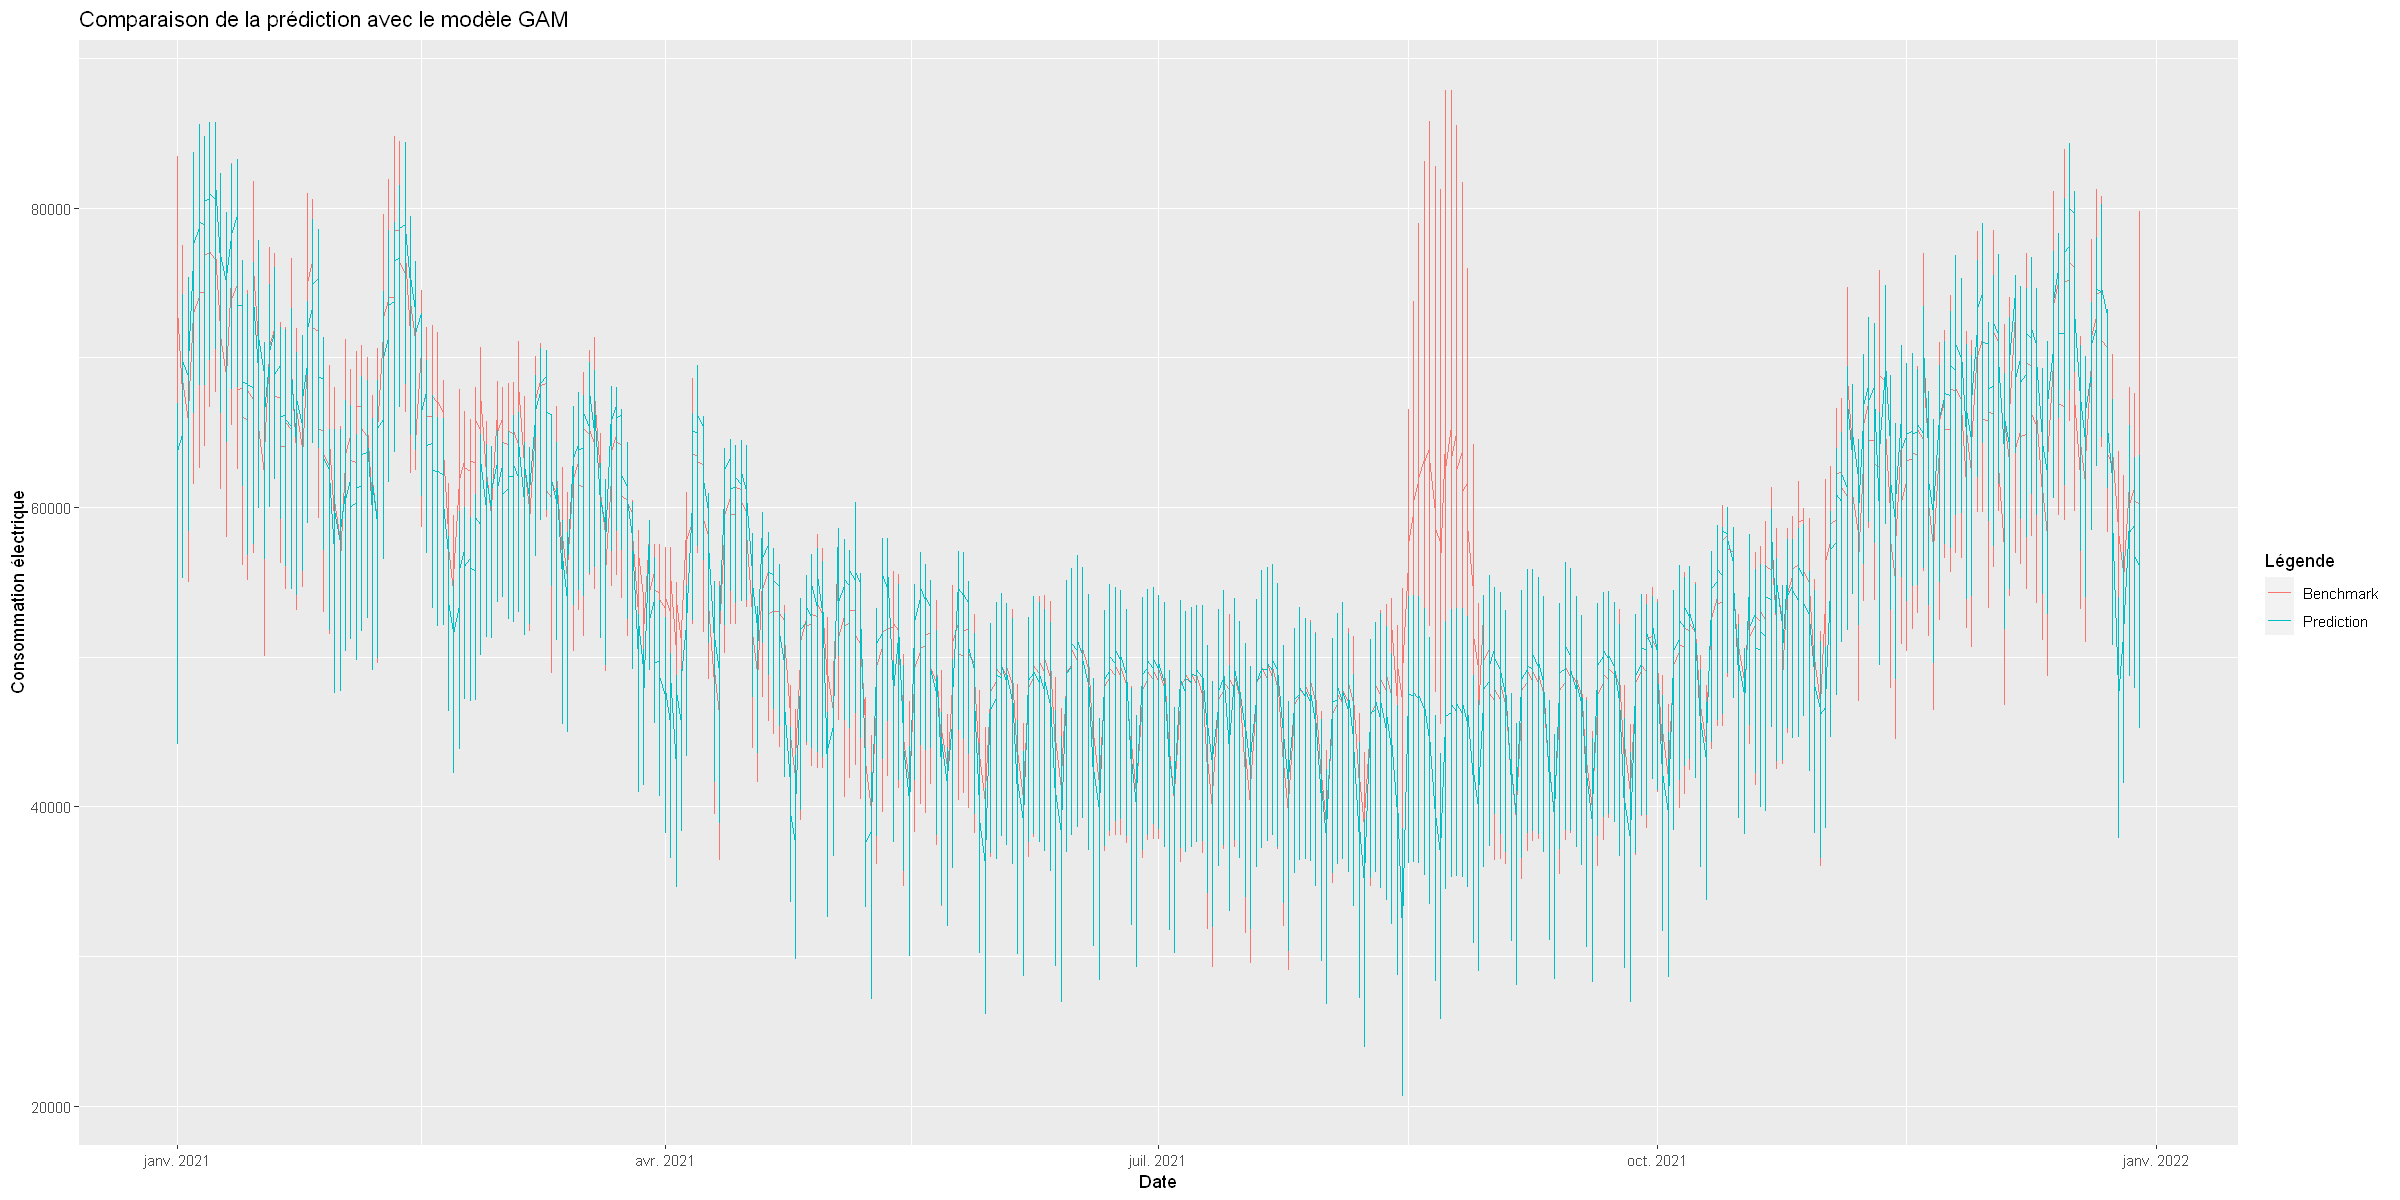

In [116]:
#Représentation graphique Prédiction vs Benchmark
options(repr.plot.width=20, repr.plot.height=10)
ggplot(comparison_mod_gam_3, aes(x=Date, y=Consumption, group=1, color="Benchmark")) +
    geom_line() +
    geom_line(aes(x=Date,y=fit, colour='Prediction')) +
    labs(colour="Légende") +
    labs(title="Comparaison de la prédiction avec le modèle GAM") +
    ylab("Consommation électrique")

In [117]:
#Aggrégation par jour pour une meilleure visualisation
comparison_mod_gam_3_notime <- comparison_mod_gam_3 %>%
   group_by(Date) %>% 
   summarise_at(vars("fit", "Consumption"), mean)

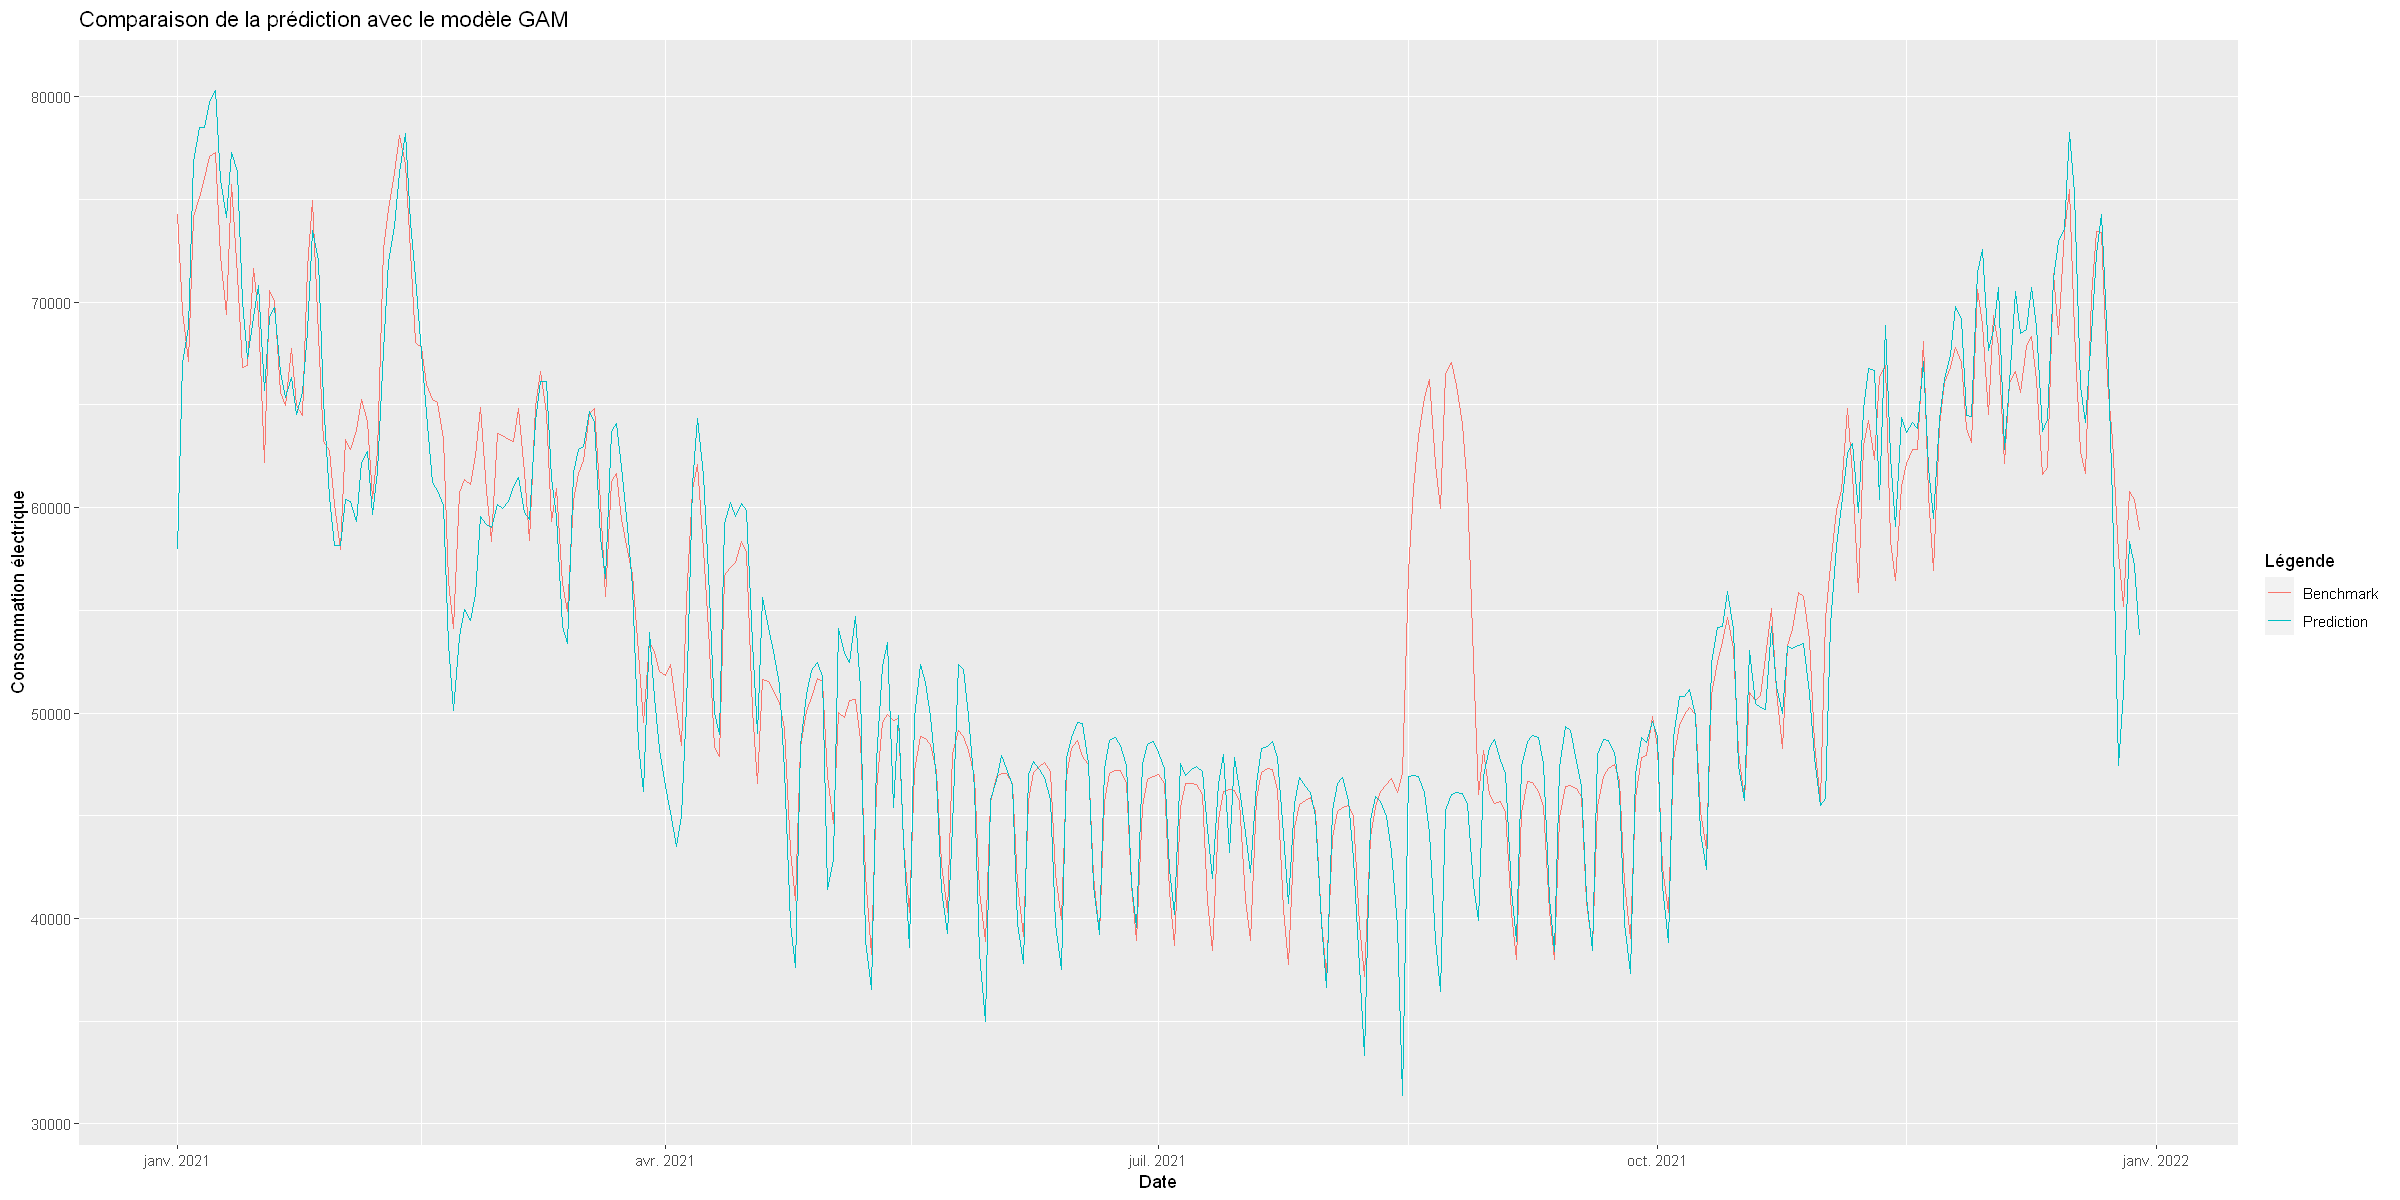

In [118]:
ggplot(comparison_mod_gam_3_notime, aes(x=Date, y=Consumption, group=1, color="Benchmark")) +
    geom_line() +
    geom_line(aes(x=Date,y=fit, colour='Prediction')) +
    labs(colour="Légende") +
    labs(title="Comparaison de la prédiction avec le modèle GAM") +
    ylab("Consommation électrique")

Nous remarquons visuellement que nous obtenons une très bonne prédiction, à l'exception d'une période allant de fin août à début septembre où le modèle n'a pas pu prévoir une hausse soudaine de la consommation. Cette hausse n'est pas caractéristique de cette période de l'année et est spécifique à l'année 2021. Cette hausse inattendue est donc imprévisible pour le modèle. Cela pourrait expliquer pourquoi nous ne parvons pas à obtenir une erreur de prédiction MAPE en dessous-de 4%.

Etudions l'erreur MAPE par mois pour le modèle GAM sélectionné.

In [125]:
#MAPE par mois
comparison_mod_gam_3 = comparison_mod_gam_3 %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

comparison_mod_gam_3$MAPE <- abs((comparison_mod_gam_3$Consumption-comparison_mod_gam_3$fit)/comparison_mod_gam_3$Consumption) * 100

comparison_mod_gam_3_month <- comparison_mod_gam_3 %>%
   group_by(Month) %>% 
   summarise_at(vars("fit", "Consumption","MAPE"), mean)

MAPE_month <- select(comparison_mod_gam_3_month,-c("fit","Consumption"))

MAPE_month

Month,MAPE
<chr>,<dbl>
01,4.066513
02,5.079790
03,3.518681
04,5.316711
05,5.319532
06,2.927074
07,3.950458
08,16.035744
09,3.681525


Ainsi, nous constatons que le mois d'août 2021 a une erreur MAPE de 16%, tandis que les autres mois ont, en moyenne, une erreur MAPE de 4,11%.

Etudions désormais les corrélogrammes entre les données métérologiques et la consommation électrique prédites et comparons les avec ceux obtenus dans la partie Analyse Descriptive.

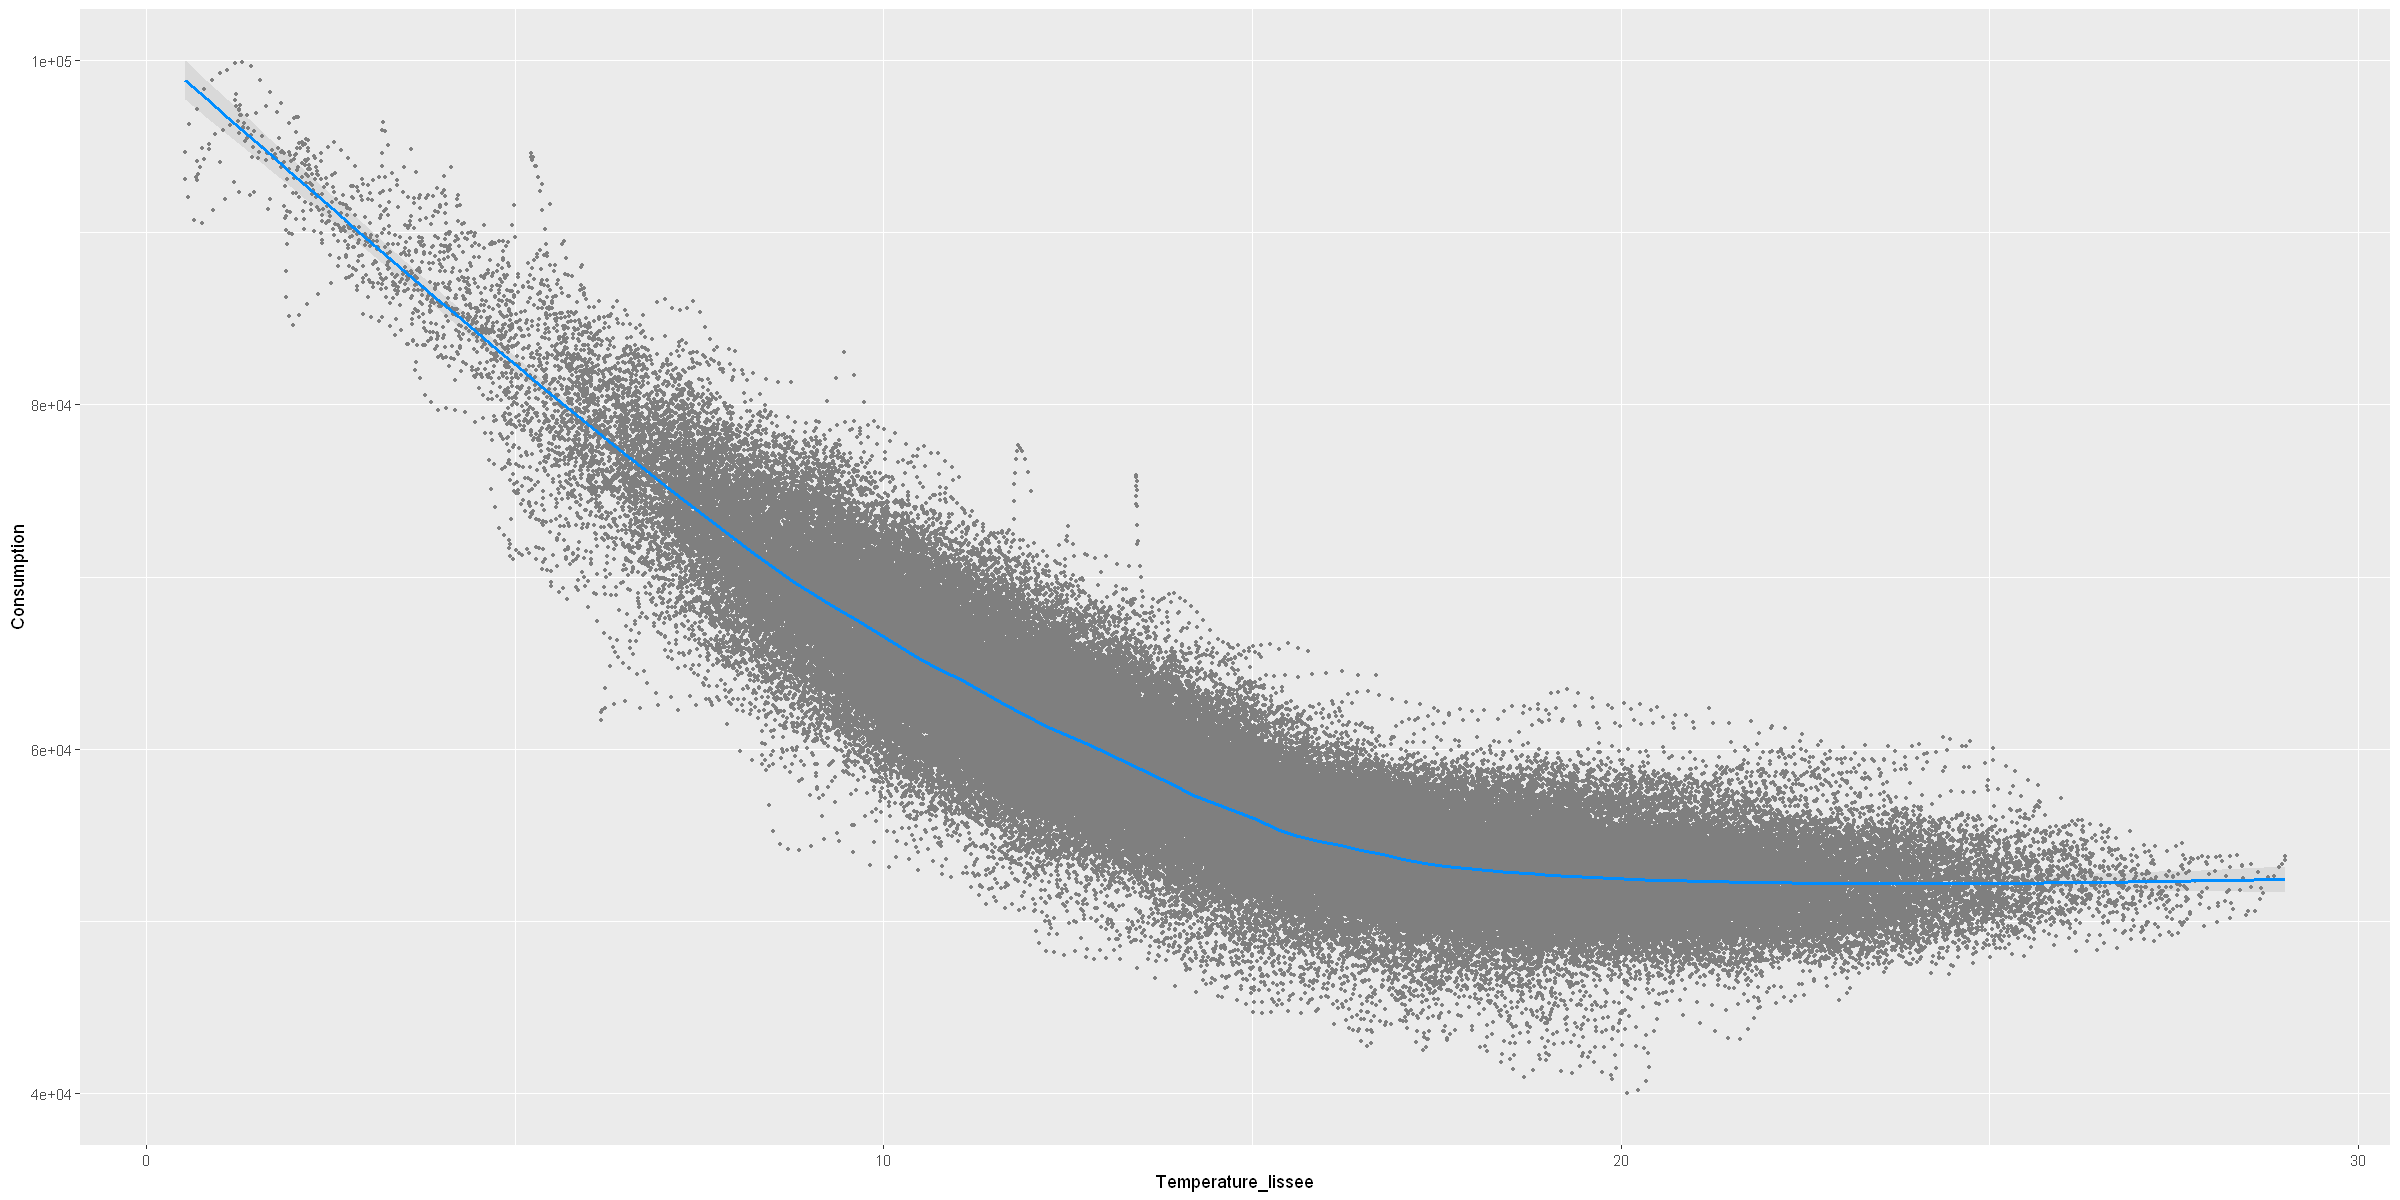

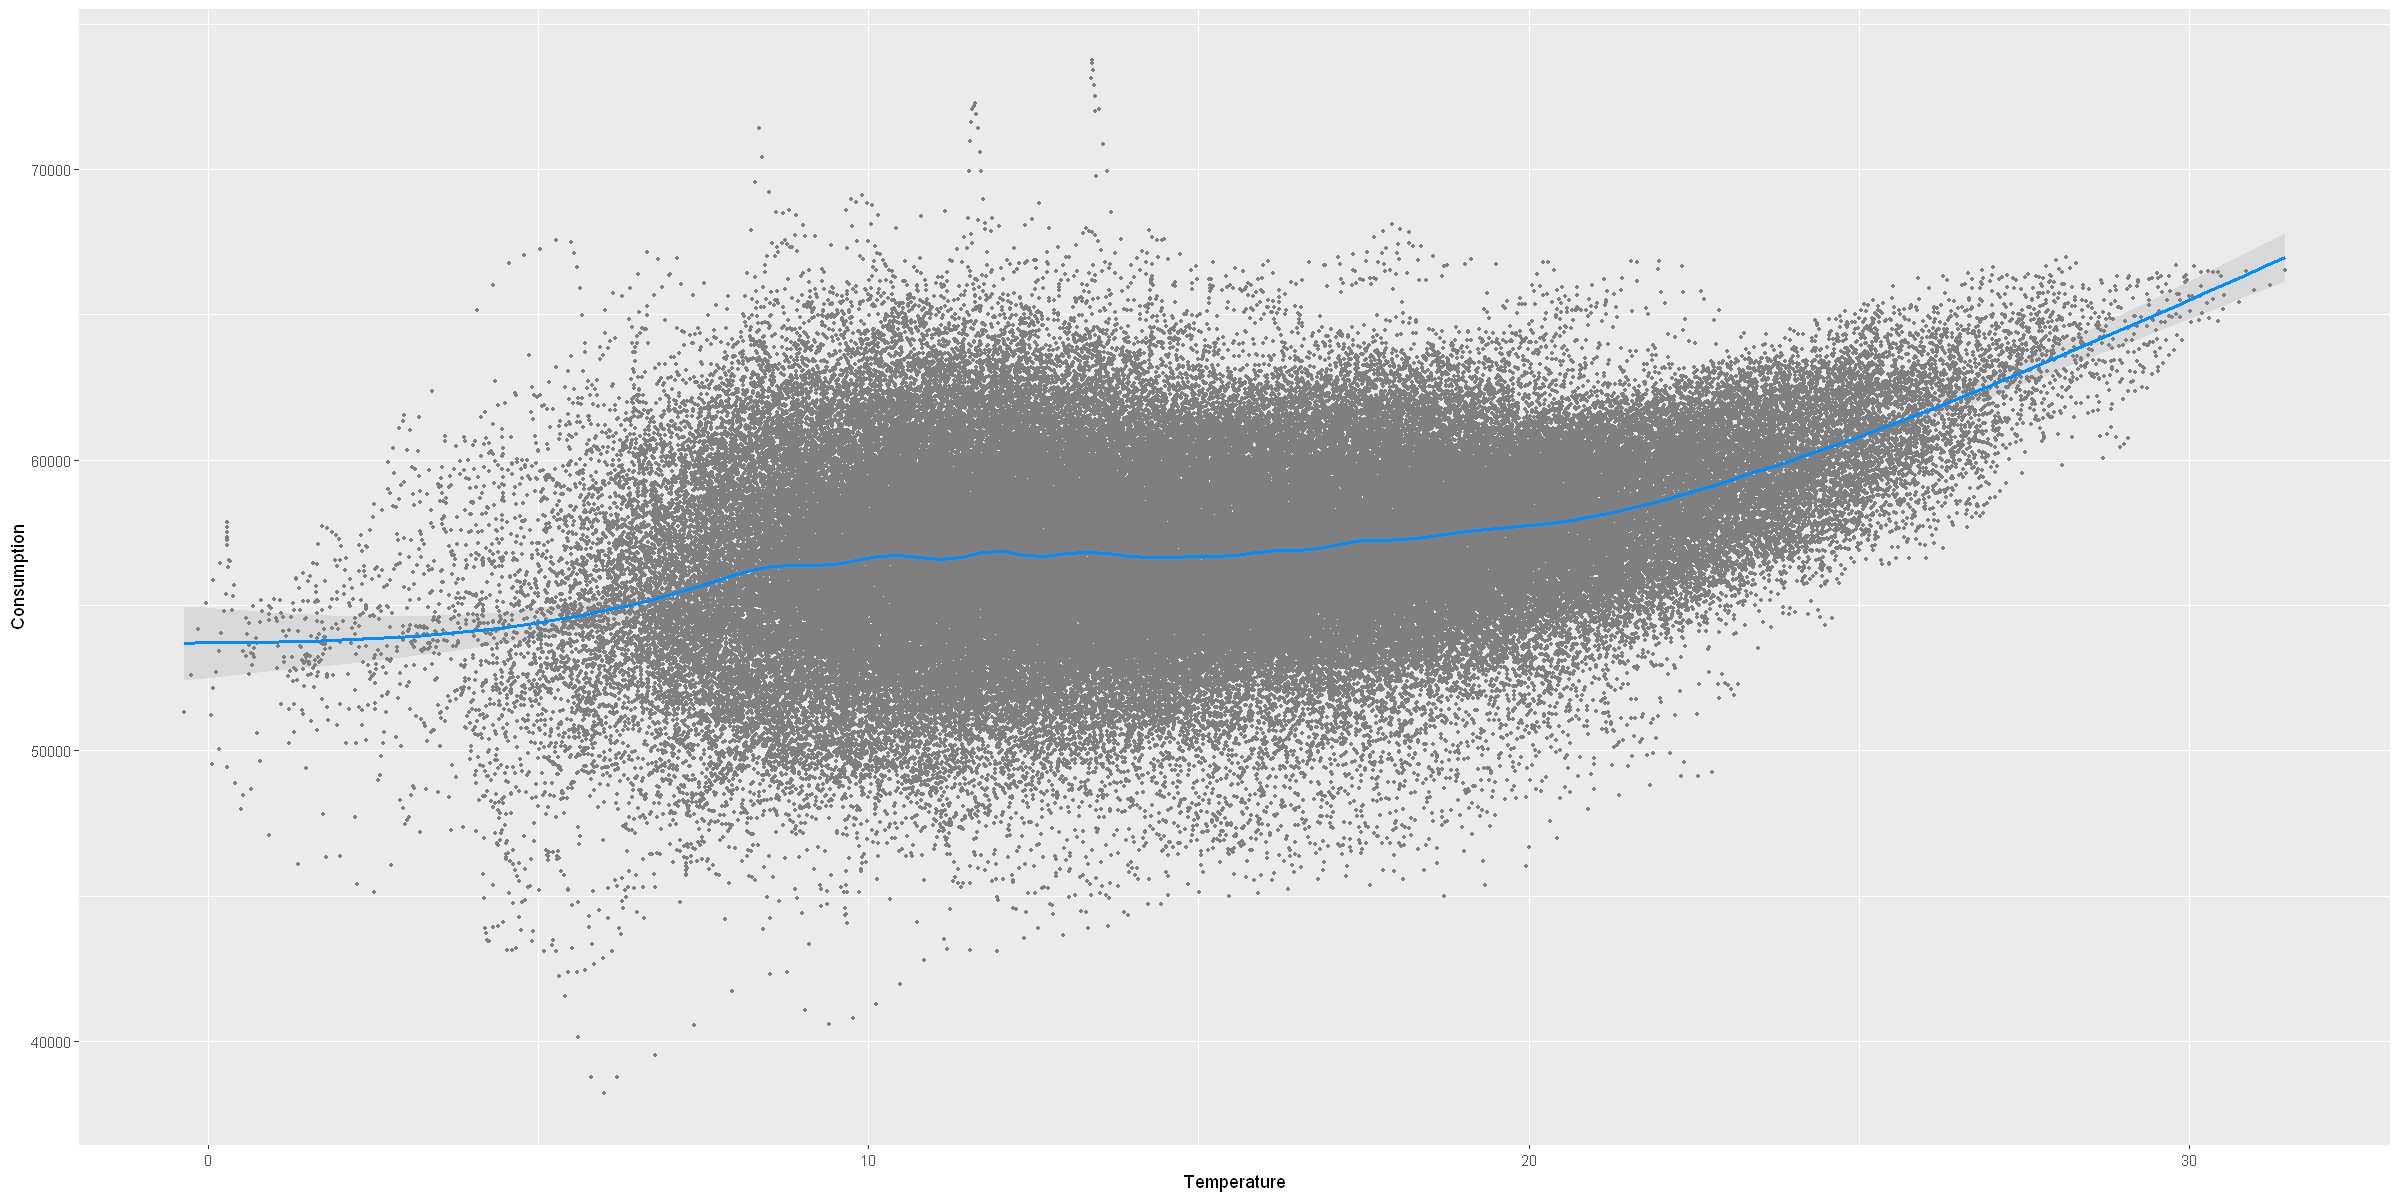

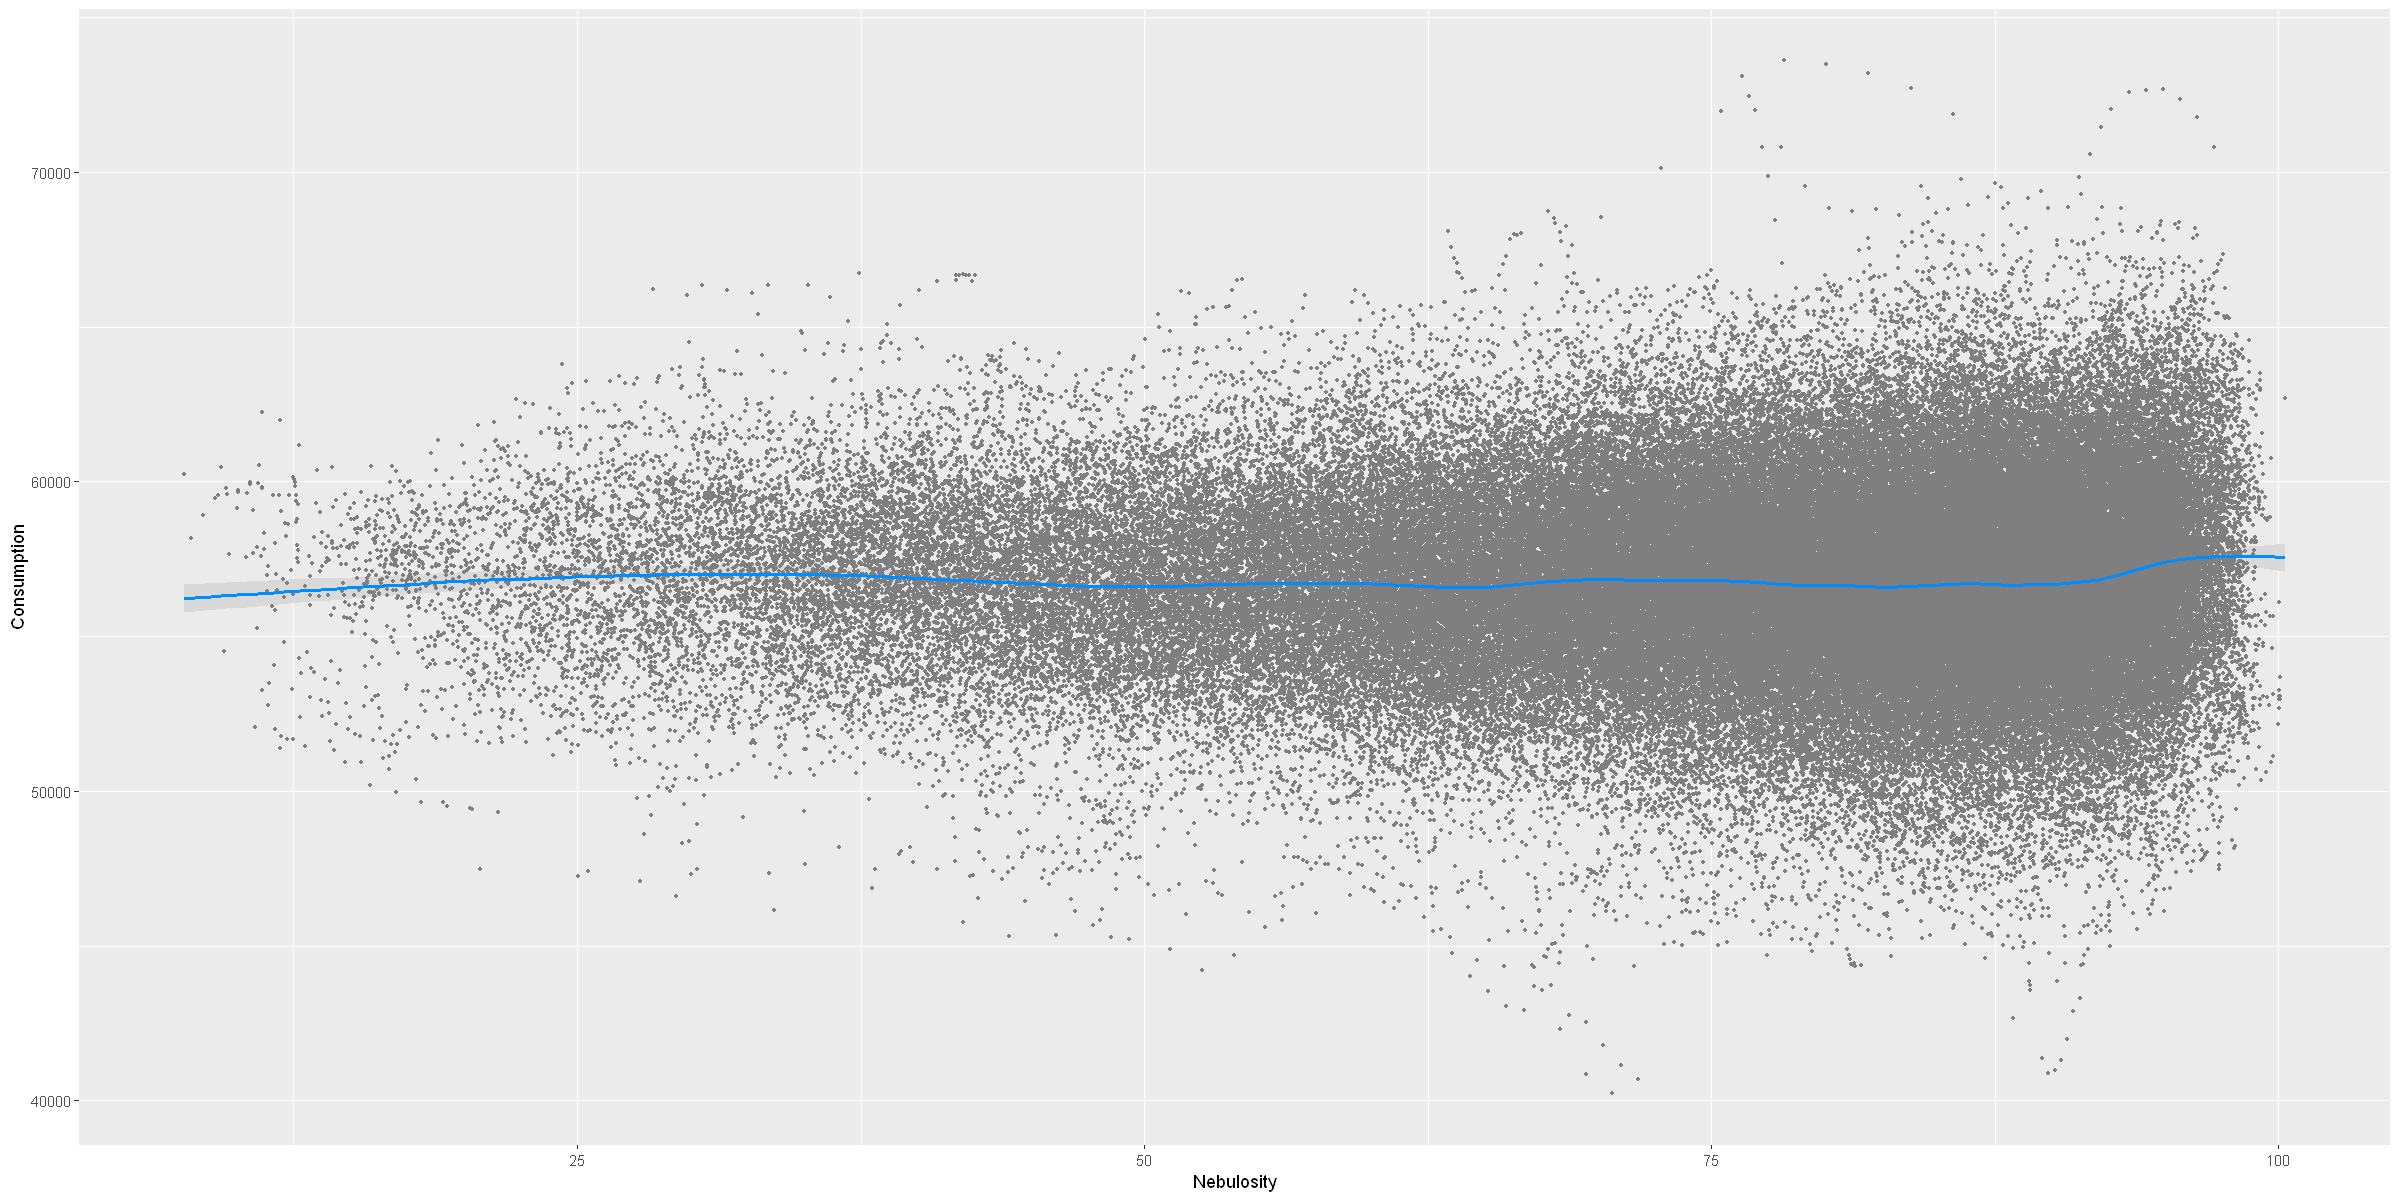

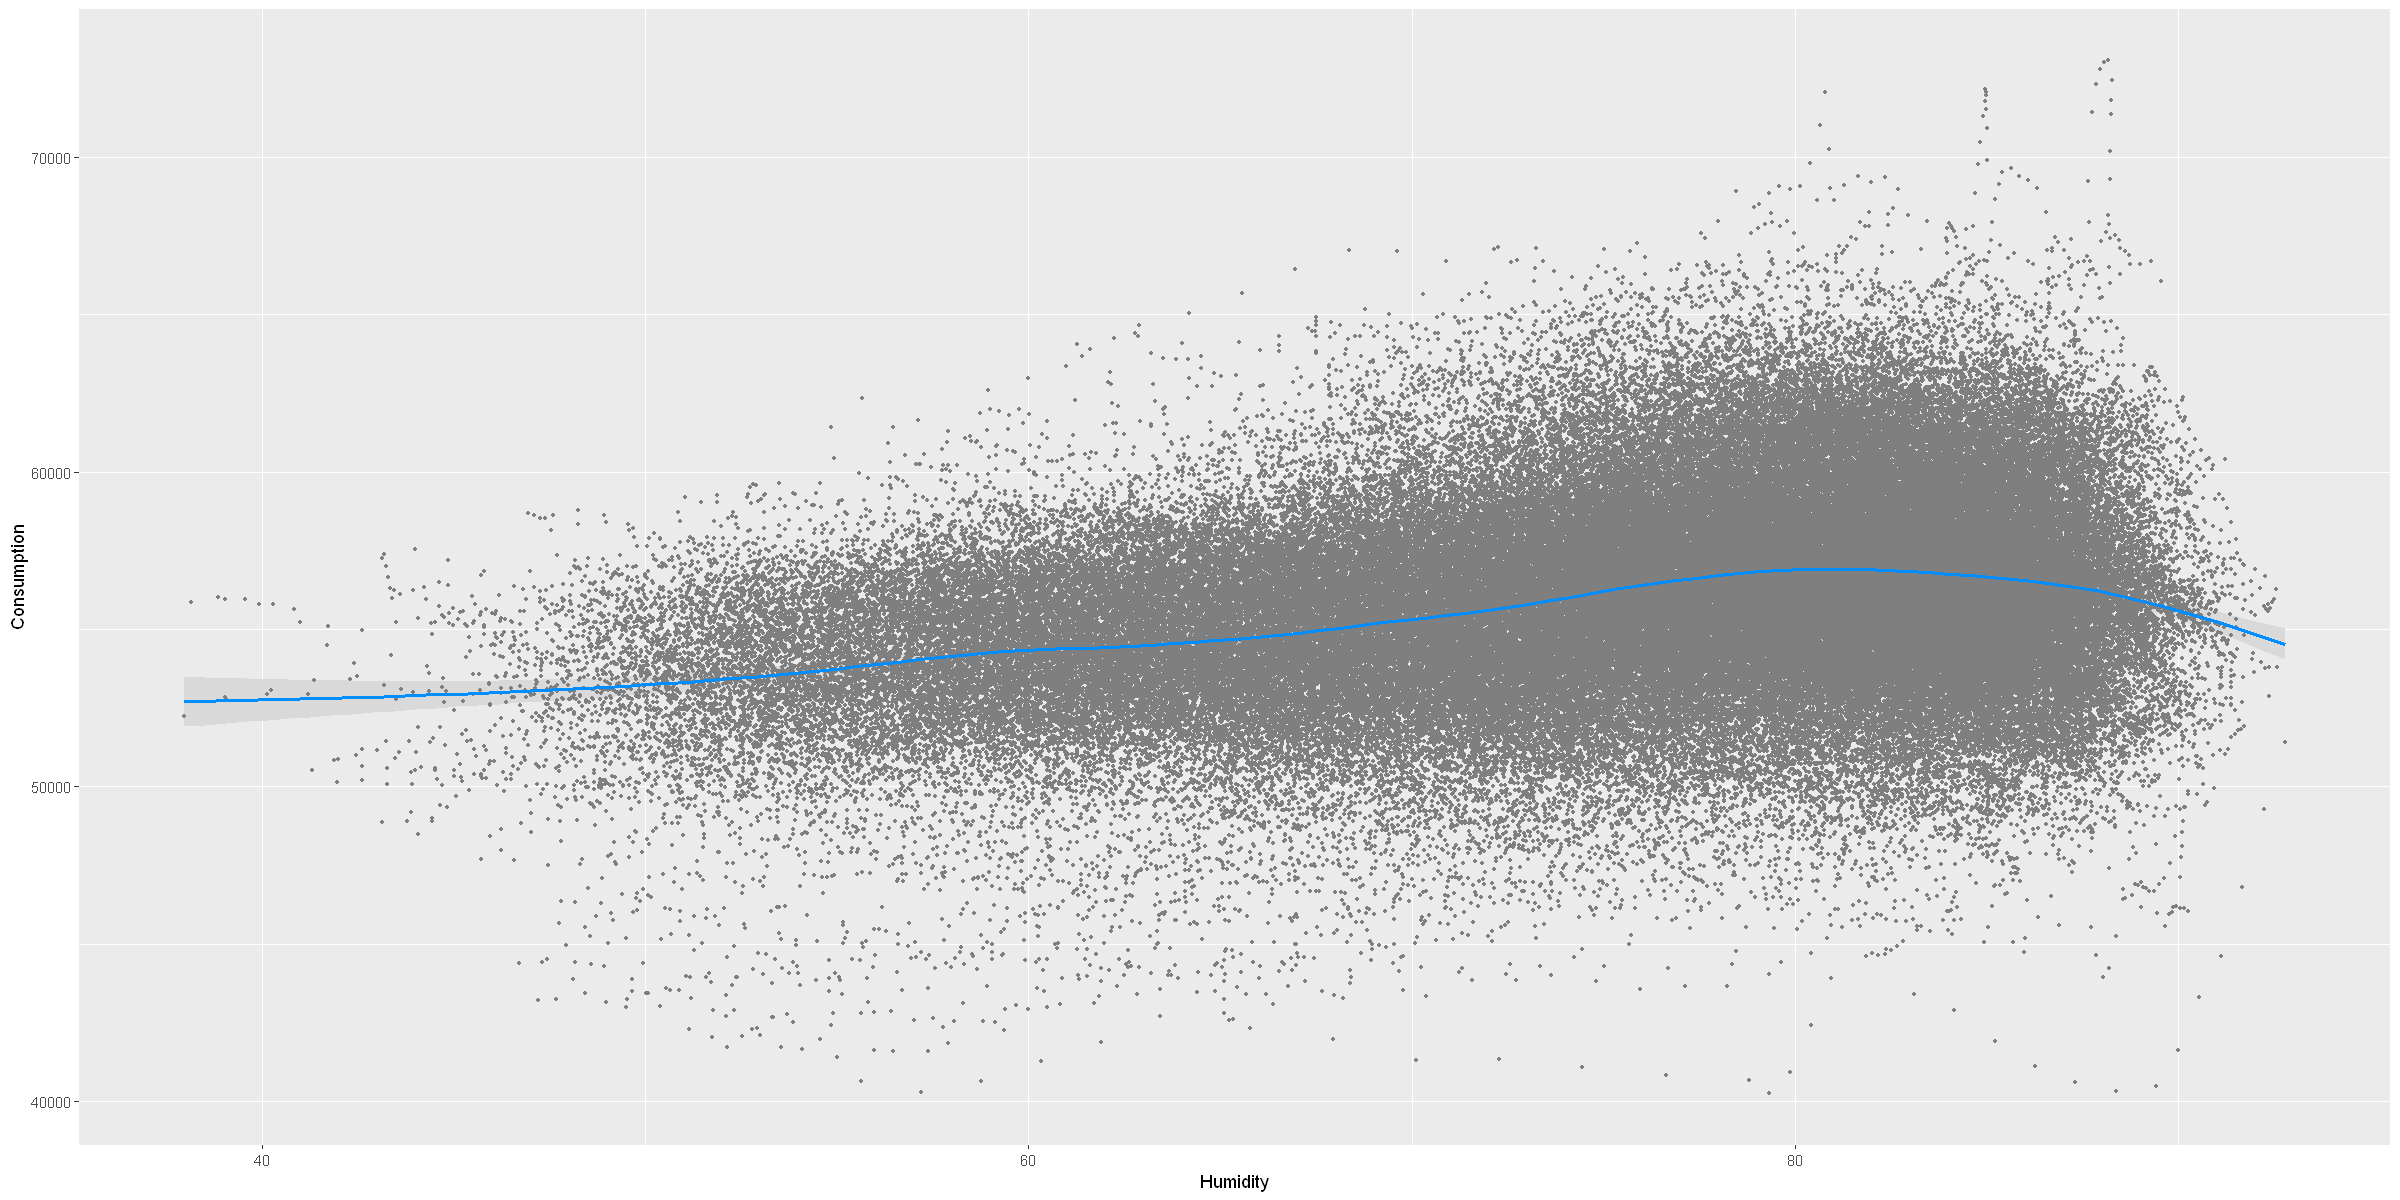

In [143]:
visreg(mod_gam_2,"Temperature_lissee", gg=TRUE,ylab="Consumption")
visreg(mod_gam_2,"Nebulosity", gg=TRUE,ylab="Consumption")
visreg(mod_gam_2,"Humidity", gg=TRUE,ylab="Consumption")

Nous constatons que les corrélogrammes obtenus sont similaires à ceux de la partie Analyses Descriptives des données d'apprentissage. Ce résultat confirme la précision de notre prédiction.

###### Etude des coefficients du modèle et du coefficient de détermination

In [156]:
summary(mod_gam_2)


Family: gaussian 
Link function: identity 

Formula:
Consumption ~ s(Temperature, bs = "cr", k = 24) + s(Temperature_lissee, 
    bs = "cr", k = 24) + s(Humidity, bs = "cr", k = 24) + s(Nebulosity, 
    bs = "cr", k = 24) + s(Position_year, bs = "cc", k = 200) + 
    as.factor(Time_number) + as.factor(Day_number) + as.factor(jour_ferie) + 
    as.factor(Holidays)

Parametric coefficients:
                          Estimate Std. Error  t value Pr(>|t|)    
(Intercept)               56051.10      62.85  891.758  < 2e-16 ***
as.factor(Time_number)2   -2209.30      75.02  -29.448  < 2e-16 ***
as.factor(Time_number)3   -5113.02      75.09  -68.093  < 2e-16 ***
as.factor(Time_number)4   -5748.34      75.18  -76.461  < 2e-16 ***
as.factor(Time_number)5   -6561.37      75.29  -87.143  < 2e-16 ***
as.factor(Time_number)6   -7287.23      75.43  -96.613  < 2e-16 ***
as.factor(Time_number)7   -9185.43      75.58 -121.533  < 2e-16 ***
as.factor(Time_number)8  -10371.88      75.82 -136.794  < 2e-16

Les signes et tendances des coefficients des données introduites en facteur sont cohérents avec les tendances que nous avions obtenues lors de l'analyse descriptive des données.

Nous remarquons que nous obtenons également un coefficient de détermination élevé, de l'ordre de 0.94.

### Conclusion et Limites

Ainsi, l'étude des données nous a permis de construire un modèle GAM de prédiction de la consommation électrique, robuste à notre protocole de validation du modèle. Son erreur MAPE est de 5,12 %. 

L'analyse visuelle de ce modèle a permis néanmoins de montrer que cette erreur MAPE est affectée à la hausse par une mauvaise prédiction de la consommation électrique de la fin du mois d'août 2021 caractérisée par une hausse inattendue de la consommation électrique. Cette hausse, surprenante pour un mois d'août, est imprévisible par le modèle. Cela pourrait expliquer pourquoi notre erreur MAPE est de 5,1% et pourquoi nous n'avons pas réussi à la diminuer à travers nos différents modèles. Ainsi, l'erreur MAPE en dehors du mois d'août 2021 est en moyenne de 4,1 % tandis qu'elle est de 16% au mois d'août 2021. 

Nous pouvons donc supposer qu'à l'exception des événements imprévisibles tels que la hausse de la consommation électrique à la fin du mois d'août 2021, notre modèle de prévision de la consommation électrique a une erreur de prédiction d'environ 4,1 %, constituant donc un modèle plutôt solide de prévision, mais pouvant être encore amélioré.

Nous constatons de plus quelques limites à notre travail. Les principales pistes d'amélioration sont les suivantes:
* automatisation de la construction du modèle par instant
* plus grande automatisation de la procédure k-cross fold validation, notamment concernant le modèle par instant
* introduction des variables catégorielles comme le jour de la semaine en tant que variable binaire dans les modèles et regarder si cela améliore l'erreur de prédiction

Une autre idée d'amélioration serait également la construction d'un algorithme automatique permettant de sélectionner pour chaque variable explicative le nombre optimal de noeuds par spline dans le modèle GAM.

Merci pour votre lecture.